In [1]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation
from landlab.components.conduit_networks.calcite import calcite_diss_palmer_transfer

from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, 
               vmin=0., vmax=0., cmap_name='viridis', 
               magnitude= False, lw=5, 
               pixels_per_node=31, x_name='X', 
               y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixels_per_node)), int(round(grid.number_of_cell_rows*pixels_per_node)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


Populating the interactive namespace from numpy and matplotlib


### Test case 1 (parallel conduits, head gradient boundary)

In [4]:
mg = RasterModelGrid((5,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

#mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.

w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] =  mg.at_link['width'].copy()

#mg.at_node['input__discharge'][12]=0.05

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.


mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.1#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

for i in arange(300):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt_min=5., outflow_bnd_type = 'head')
    


Number of links =  85
Number of nodes =  50
Number of active links =  43
Number of core nodes =  24
Time iteration: 0
dt= 8.75425347893    dt_h= 8.75425347893   dt_Cr= 33.3233416166
average dh= 0.00242169526767   average abs(dQ)= 0.119722454082
num iters= 12
Time iteration: 1
average dh= 0.197436484493   average abs(dQ)= 0.236227171129
num iters= 16
Time iteration: 2
average dh= 0.367684334322   average abs(dQ)= 0.125512639219
num iters= 15
Time iteration: 3
average dh= 0.370872795829   average abs(dQ)= 0.0995303611042
num iters= 15
Time iteration: 4
average dh= 0.344813752352   average abs(dQ)= 0.0940994903138
num iters= 15
Time iteration: 5
average dh= 0.319156757625   average abs(dQ)= 0.0861336618183
num iters= 14
Time iteration: 6
average dh= 0.298431570637   average abs(dQ)= 0.0681959403233
num iters= 14
Time iteration: 7
average dh= 0.282126492286   average abs(dQ)= 0.0657466366281
num iters= 14
Time iteration: 8
average dh= 0.269059487057   average abs(dQ)= 0.058021597059
num it

average dh= 0.00220435346269   average abs(dQ)= 0.000231449298358
num iters= 5
Time iteration: 103
average dh= 0.00194225230152   average abs(dQ)= 0.000204304817474
num iters= 5
Time iteration: 104
average dh= 0.00171115175034   average abs(dQ)= 0.000181717672922
num iters= 5
Time iteration: 105
average dh= 0.00150749112005   average abs(dQ)= 0.000160240926958
num iters= 5
Time iteration: 106
average dh= 0.00273781894633   average abs(dQ)= 0.710522301167
num iters= 50
Time iteration: 107
average dh= 0.00498739854584   average abs(dQ)= 1.1291834878
num iters= 50
Time iteration: 108
average dh= 0.00388822565959   average abs(dQ)= 1.29185937169
num iters= 50
Time iteration: 109
average dh= -0.000363743326847   average abs(dQ)= 1.28774208122
num iters= 50
Time iteration: 110
dt= 5.0    dt_h= 0.365912783386   dt_Cr= 20.8829153292
average dh= -0.00256715262562   average abs(dQ)= 1.34185660628
num iters= 50
Time iteration: 111
average dh= -0.000652305117202   average abs(dQ)= 0.404793839507
n

average dh= 0.00448781503714   average abs(dQ)= 1.28905342139
num iters= 50
Time iteration: 194
average dh= 0.000209804920572   average abs(dQ)= 1.2853025383
num iters= 50
Time iteration: 195
average dh= -0.00202443126516   average abs(dQ)= 1.34006842282
num iters= 50
Time iteration: 196
average dh= -0.00290401880178   average abs(dQ)= 1.29869647325
num iters= 50
Time iteration: 197
average dh= -0.00348497047556   average abs(dQ)= 1.30449287844
num iters= 50
Time iteration: 198
average dh= -0.00357299947228   average abs(dQ)= 1.30213477288
num iters= 50
Time iteration: 199
average dh= -0.00328830169061   average abs(dQ)= 1.30097103934
num iters= 50
Time iteration: 200
dt= 5.0    dt_h= 0.375554209908   dt_Cr= 20.993868173
average dh= -0.00295101166944   average abs(dQ)= 1.29650511406
num iters= 50
Time iteration: 201
average dh= -0.000738706990944   average abs(dQ)= 0.381721851626
num iters= 13
Time iteration: 202
average dh= -0.000661903878488   average abs(dQ)= 0.275742609835
num iter

dt= 20.9938752845    dt_h= 157.046211757   dt_Cr= 20.9938752845
average dh= 0.000615368526801   average abs(dQ)= 0.000221289884552
num iters= 4
Time iteration: 281
average dh= 0.00362346796496   average abs(dQ)= 0.710262166864
num iters= 50
Time iteration: 282
average dh= 0.00569995021968   average abs(dQ)= 1.13545013061
num iters= 50
Time iteration: 283
average dh= 0.00435927129465   average abs(dQ)= 1.28615133794
num iters= 50
Time iteration: 284
average dh= 0.000533346834576   average abs(dQ)= 1.28265435244
num iters= 50
Time iteration: 285
average dh= -0.00215081926338   average abs(dQ)= 1.33766191005
num iters= 50
Time iteration: 286
average dh= -0.00286850239133   average abs(dQ)= 1.30464819489
num iters= 50
Time iteration: 287
average dh= -0.00344512874232   average abs(dQ)= 1.30243863788
num iters= 50
Time iteration: 288
average dh= -0.00349058569966   average abs(dQ)= 1.31106859588
num iters= 50
Time iteration: 289
average dh= -0.00323805229607   average abs(dQ)= 1.29713384734

Node net fluxes =  [ 0.03339788 -0.05891589  0.0500449  -0.05893525  0.05748601 -0.04928796
  0.05669394 -0.01205263 -0.07858187  0.0980103  -0.11655071  0.11002732
 -0.10929593  0.11395538 -0.09015617  0.04872063  0.03339788 -0.05891589
  0.0500449  -0.05893525  0.05748601 -0.04928796  0.05669394 -0.01205263]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           9.15566339   8.3452008    7.4849521    6.66071362
   5.79058209   4.96558326   4.10358896   3.29534961   0.
  10.           9.19727059   8.3171376    7.51983114   6.62813423
   5.82256967   4.9303432    4.13467297   3.2574377    0.
  10.           9.15566339   8.3452008    7.4849521    6.66071362
   5.79058209   4.96558326   4.10358896   3.29534961   0.
  10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
Discharge= [-1.2804822  -1.26050784 -1.30290378 -1.26999214 -1

Text(0, 0.5, 'D_H')

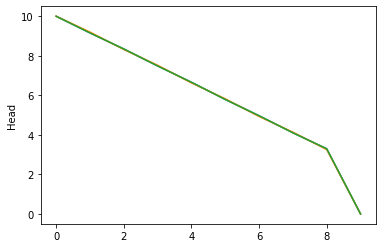

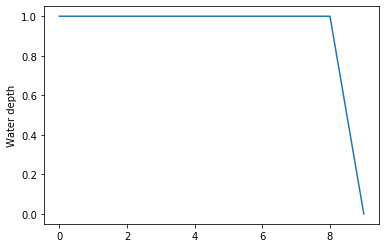

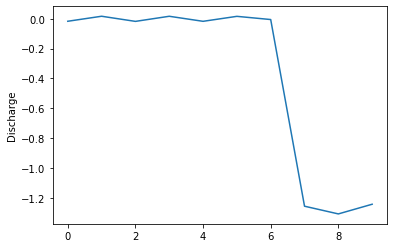

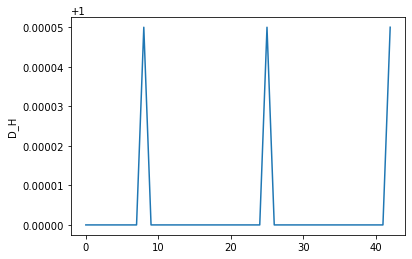

In [5]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx - mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",h)

figure()
plot(h[10:20])
plot(h[20:30])
plot(h[30:40])
ylabel('Head')

print('Discharge=',Q[mg.active_links])
#Discharge from DW equation
L = max(mg.node_x)
deltaH = max(h[mg.nodes_at_left_edge]) - min(h[mg.nodes_at_right_edge])
f=0.1
g=9.8
D_H = 1. 
print('DW discharge = ', D_H**2.*sqrt(2*g*D_H*deltaH/f/L))


figure()
water_depth = mg.at_node['hydraulic__head'][10:20] - mg.at_node['junction__elevation'][10:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')


figure()
plot(Q[mg.active_links][10:20])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')



Normal flow boundary fails in this case, as there is zero slope. Outfall (or fixed head) might be more appropriate here.

### Test Case 2 (single conduit, recharge boundary)

In [6]:
mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

#mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.

w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

mg.at_node['input__discharge'][11]=1.475

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.


mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 0.1#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=10.,outflow_bnd_type='normal')
    


Number of links =  47
Number of nodes =  30
Number of active links =  8
Number of core nodes =  8
Time iteration: 0
max change in h:  0.358597711019
max change in h:  0.133752246008
max change in h:  0.0536795122073
max change in h:  0.0406897141127
max change in h:  0.027090033916
max change in h:  0.0165157250412
max change in h:  0.00940989482334
max change in h:  0.00507617225229
max change in h:  0.00261831354582
max change in h:  0.00130172897964
max change in h:  0.000628061450891
max change in h:  0.000295879970812
max change in h:  0.000136883760508
max change in h:  6.25422011264e-05
average dh= 0.190625196165   average abs(dQ)= 0.147033469017
Time iteration: 1
max change in h:  0.188210884379
max change in h:  0.0992429994833
max change in h:  0.0507376956525
max change in h:  0.022763495259
max change in h:  0.0172655026783
max change in h:  0.0116460472543
max change in h:  0.00710660707314
max change in h:  0.00397075925106
max change in h:  0.00204660411455
max change in

max change in h:  0.00947218661556
max change in h:  0.00466982283636
max change in h:  0.00230179951497
max change in h:  0.00113492271696
max change in h:  0.000559930588668
max change in h:  0.000276474580097
max change in h:  0.000136651432214
max change in h:  6.76309899506e-05
average dh= 0.130337643239   average abs(dQ)= 0.0224960204728
Time iteration: 14
max change in h:  0.0376415493099
max change in h:  0.0186031788595
max change in h:  0.00918350387336
max change in h:  0.00453230868571
max change in h:  0.00223753276106
max change in h:  0.00110538267064
max change in h:  0.000546584165454
max change in h:  0.000270584685061
max change in h:  0.000134137783961
max change in h:  6.65969542721e-05
average dh= 0.118559040713   average abs(dQ)= 0.021175234264
Time iteration: 15
max change in h:  0.0365209176732
max change in h:  0.018067683706
max change in h:  0.00893210540631
max change in h:  0.00441628201378
max change in h:  0.0021848856289
max change in h:  0.001081929889

max change in h:  0.000165542071208
max change in h:  8.16668507415e-05
average dh= 0.0302494947012   average abs(dQ)= 0.00447604721141
Time iteration: 54
max change in h:  0.0111009113256
max change in h:  0.00549342620022
max change in h:  0.00271485184384
max change in h:  0.00134064357064
max change in h:  0.000661740916946
max change in h:  0.000326551972021
max change in h:  0.000161121392773
max change in h:  7.94909232056e-05
average dh= 0.0294502628583   average abs(dQ)= 0.00433631897956
Time iteration: 55
max change in h:  0.0108021611831
max change in h:  0.00534585403942
max change in h:  0.00264206861155
max change in h:  0.0013047779051
max change in h:  0.000644075870408
max change in h:  0.00031785369084
max change in h:  0.000156838993805
max change in h:  7.73827574196e-05
average dh= 0.0286755075332   average abs(dQ)= 0.00420219463268
Time iteration: 56
max change in h:  0.0105128989021
max change in h:  0.00520295188161
max change in h:  0.00257157954446
max change 

max change in h:  0.00609050340303
max change in h:  0.00301629232065
max change in h:  0.00149193668491
max change in h:  0.00073741335223
max change in h:  0.000364323844133
max change in h:  0.000179952138588
max change in h:  8.88717540732e-05
average dh= 0.0163165341709   average abs(dQ)= 0.00222792252387
Time iteration: 78
max change in h:  0.00593952937723
max change in h:  0.00294158615366
max change in h:  0.00145501984128
max change in h:  0.000719184722046
max change in h:  0.000355327030761
max change in h:  0.000175512872204
max change in h:  8.66816301972e-05
average dh= 0.0159163908024   average abs(dQ)= 0.0021685017355
Time iteration: 79
max change in h:  0.00579263531249
max change in h:  0.00286889567356
max change in h:  0.00141909726886
max change in h:  0.000701446090568
max change in h:  0.000346571576264
max change in h:  0.000171192457744
max change in h:  8.45500227165e-05
average dh= 0.0155268315211   average abs(dQ)= 0.00211086080342
Time iteration: 80
max ch

max change in h:  9.76579175358e-05
average dh= 0.00887907682871   average abs(dQ)= 0.00116391004854
Time iteration: 103
max change in h:  0.00322013002014
max change in h:  0.00159536951671
max change in h:  0.000789453501305
max change in h:  0.000390378806353
max change in h:  0.000192959940653
max change in h:  9.53549758709e-05
average dh= 0.00867046382269   average abs(dQ)= 0.00113771439106
Time iteration: 104
max change in h:  0.00314403019846
max change in h:  0.00155767837625
max change in h:  0.000770809802221
max change in h:  0.000381163768653
max change in h:  0.000188407215655
max change in h:  9.31062603922e-05
average dh= 0.00846664631337   average abs(dQ)= 0.00111077888308
Time iteration: 105
max change in h:  0.00306976618186
max change in h:  0.00152089808611
max change in h:  0.000752616905926
max change in h:  0.000372171525196
max change in h:  0.000183964508599
max change in h:  9.09118469785e-05
average dh= 0.00826768378746   average abs(dQ)= 0.00108395365036
Ti

max change in h:  0.0016608501054
max change in h:  0.000823005912418
max change in h:  0.000407346214477
max change in h:  0.000201476584085
max change in h:  9.9611537383e-05
average dh= 0.00448409198507   average abs(dQ)= 0.000576197112758
Time iteration: 132
max change in h:  0.00162290962027
max change in h:  0.000804199262582
max change in h:  0.000398037170957
max change in h:  0.000196872542375
max change in h:  9.73355848934e-05
average dh= 0.00438195071455   average abs(dQ)= 0.000565157114578
Time iteration: 133
max change in h:  0.00158574743812
max change in h:  0.000785783996408
max change in h:  0.000388923436013
max change in h:  0.00019236553417
max change in h:  9.51077173834e-05
average dh= 0.00428187784638   average abs(dQ)= 0.000552955305675
Time iteration: 134
max change in h:  0.00154941090631
max change in h:  0.000767780037524
max change in h:  0.000380013836921
max change in h:  0.000187959622801
max change in h:  9.29298549526e-05
average dh= 0.00418400866506 

max change in h:  0.00019488029427
max change in h:  9.63999865871e-05
average dh= 0.0021486069712   average abs(dQ)= 0.00027655533419
Time iteration: 164
max change in h:  0.000776775739514
max change in h:  0.000384939313376
max change in h:  0.000190542670047
max change in h:  9.42542521418e-05
average dh= 0.00210087602619   average abs(dQ)= 0.000271280220994
Time iteration: 165
max change in h:  0.000759456917542
max change in h:  0.000376356044132
max change in h:  0.000186293996425
max change in h:  9.21526945881e-05
average dh= 0.00205409582955   average abs(dQ)= 0.000265563657971
Time iteration: 166
max change in h:  0.000742511073078
max change in h:  0.000367958494131
max change in h:  0.000182137494459
max change in h:  9.00967938104e-05
average dh= 0.00200831745394   average abs(dQ)= 0.0002597451182
Time iteration: 167
max change in h:  0.000725940176068
max change in h:  0.000359747089542
max change in h:  0.00017807321705
max change in h:  8.8086530571e-05
average dh= 0.0

max change in h:  0.00031842573059
max change in h:  0.000157795027928
max change in h:  7.81086887844e-05
average dh= 0.000862423846231   average abs(dQ)= 0.000113186496779
Time iteration: 205
max change in h:  0.000311575616118
max change in h:  0.00015440059984
max change in h:  7.64285140971e-05
average dh= 0.000843879731668   average abs(dQ)= 0.000110742545803
Time iteration: 206
max change in h:  0.000304873506289
max change in h:  0.000151079507152
max change in h:  7.4784636066e-05
average dh= 0.000825735912044   average abs(dQ)= 0.000108351709874
Time iteration: 207
max change in h:  0.000298316179284
max change in h:  0.000147830153505
max change in h:  7.31762646673e-05
average dh= 0.000807983689926   average abs(dQ)= 0.000106012863253
Time iteration: 208
max change in h:  0.00029190048248
max change in h:  0.000144650976939
max change in h:  7.16026269139e-05
average dh= 0.000790614553596   average abs(dQ)= 0.000103724877535
Time iteration: 209
max change in h:  0.000285623

max change in h:  9.93091507766e-05
average dh= 0.00027001792475   average abs(dQ)= 3.36664355789e-05
Time iteration: 261
max change in h:  9.77049122817e-05
average dh= 0.000265683271425   average abs(dQ)= 3.47004286081e-05
Time iteration: 262
max change in h:  9.60683669433e-05
average dh= 0.000261246150421   average abs(dQ)= 3.48483870224e-05
Time iteration: 263
max change in h:  9.44323507248e-05
average dh= 0.000256803625858   average abs(dQ)= 3.45919273175e-05
Time iteration: 264
max change in h:  9.28117884591e-05
average dh= 0.000252399907235   average abs(dQ)= 3.41538985749e-05
Time iteration: 265
max change in h:  9.12133198447e-05
average dh= 0.000248054746399   average abs(dQ)= 3.36373609992e-05
Time iteration: 266
max change in h:  8.96397559309e-05
average dh= 0.000243776584377   average abs(dQ)= 3.30899239424e-05
Time iteration: 267
max change in h:  8.8092141791e-05
average dh= 0.000239568637812   average abs(dQ)= 3.25335299271e-05
Time iteration: 268
max change in h:  

max change in h:  2.30396775915e-05
average dh= 6.26629037295e-05   average abs(dQ)= 8.50591664175e-06
Time iteration: 345
max change in h:  2.2641996182e-05
average dh= 6.15813323463e-05   average abs(dQ)= 8.3590591908e-06
Time iteration: 346
max change in h:  2.22511812442e-05
average dh= 6.05184344497e-05   average abs(dQ)= 8.21473876186e-06
Time iteration: 347
max change in h:  2.18671141461e-05
average dh= 5.94738874547e-05   average abs(dQ)= 8.07291147634e-06
Time iteration: 348
max change in h:  2.14896783071e-05
average dh= 5.84473743548e-05   average abs(dQ)= 7.9335342158e-06
Time iteration: 349
max change in h:  2.1118759161e-05
average dh= 5.74385836262e-05   average abs(dQ)= 7.7965646097e-06
Time iteration: 350
max change in h:  2.07542441224e-05
average dh= 5.64472091323e-05   average abs(dQ)= 7.66196102206e-06
Time iteration: 351
max change in h:  2.03960225562e-05
average dh= 5.54729500302e-05   average abs(dQ)= 7.52968253756e-06
Time iteration: 352
max change in h:  2.0

max change in h:  5.43191700331e-06
average dh= 1.47740069613e-05   average abs(dQ)= 2.00496899372e-06
Time iteration: 428
max change in h:  5.33818163184e-06
average dh= 1.45190626479e-05   average abs(dQ)= 1.97036825411e-06
Time iteration: 429
max change in h:  5.2460639175e-06
average dh= 1.42685180232e-05   average abs(dQ)= 1.93636471887e-06
Time iteration: 430
max change in h:  5.15553594305e-06
average dh= 1.40222971497e-05   average abs(dQ)= 1.90294807717e-06
Time iteration: 431
max change in h:  5.066570262e-06
average dh= 1.37803254006e-05   average abs(dQ)= 1.87010819694e-06
Time iteration: 432
max change in h:  4.97913991637e-06
average dh= 1.35425294377e-05   average abs(dQ)= 1.83783512067e-06
Time iteration: 433
max change in h:  4.89321840291e-06
average dh= 1.33088371888e-05   average abs(dQ)= 1.80611906306e-06
Time iteration: 434
max change in h:  4.80877967846e-06
average dh= 1.30791778261e-05   average abs(dQ)= 1.77495040779e-06
Time iteration: 435
max change in h:  4

max change in h:  1.57843383874e-06
average dh= 4.29312937012e-06   average abs(dQ)= 5.82587527664e-07
Time iteration: 499
max change in h:  1.55119723289e-06
average dh= 4.21904959775e-06   average abs(dQ)= 5.72534525539e-07


Node net fluxes =  [  6.17436492e-06   5.96410077e-06   5.55073468e-06   4.94834510e-06
   4.17744707e-06   3.26429340e-06   2.23998060e-06   1.13939001e-06]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           9.87078356   8.76191139   7.65304798   6.54419272
   5.43534474   4.32650289   3.21766584   2.10883208   1.
  10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
Discharge= [-1.47499383 -1.47498786 -1.47498231 -1.47497736 -1.47497319 -1.47496992
 -1.47496768 -1.47496654]
DW discharge =  1.47572957475


Text(0, 0.5, 'D_H')

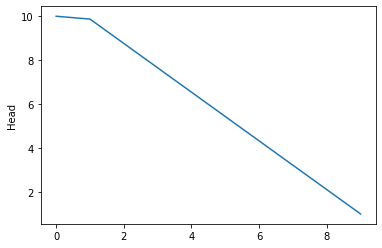

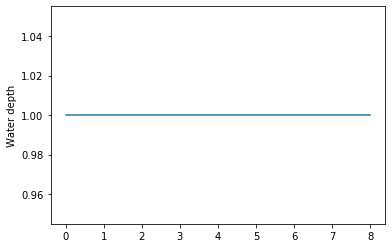

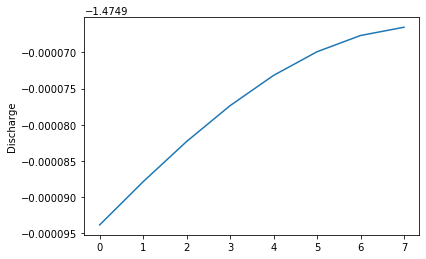

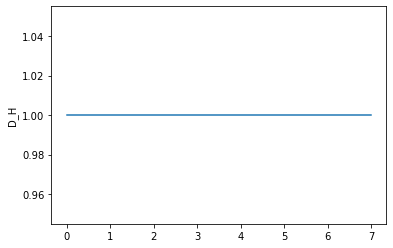

In [7]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",h)

figure()
plot(h[10:20])
#plot(h[20:30])
#plot(h[30:40])
ylabel('Head')

print('Discharge=',Q[mg.active_links])
#Discharge from DW equation
L = max(mg.node_x)
deltaH = max(h[mg.nodes_at_left_edge]) - min(h[mg.nodes_at_right_edge])
f=0.1
g=9.8
D_H = 1. 
print('DW discharge = ', D_H**2.*sqrt(2*g*D_H*deltaH/f/L))

figure()
water_depth = mg.at_node['hydraulic__head'][11:20] - mg.at_node['junction__elevation'][11:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')


figure()
plot(Q[mg.active_links])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')




### Test Case 3 (Single conduit, Recharge boundary, slightly tilted domain)

In [18]:
### Note need to add downstream boundary condition for critical flow depth (free outfall)

#For rectangle, Y_crit = (Q^2/(g w^2))^(1/3)



mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.0001*mg.node_x + 0.09
#mg.at_node['hydraulic__head'] = mg.at_node['junction__elevation'] + 1
#h = mg.at_node['hydraulic__head']


w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

mg.at_node['input__discharge'][11]=0.05

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.0


mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg)

for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=10., outflow_bnd_type='outfall')


Number of links =  47
Number of nodes =  30
Number of active links =  8
Number of core nodes =  8
Time iteration: 0
max change in h:  0.0124999969344
max change in h:  0.006249999997
max change in h:  0.00312500075943
max change in h:  0.00156250075236
max change in h:  0.000781250547912
max change in h:  0.000390625337293
max change in h:  0.000195312680311
max change in h:  9.76563403574e-05
average dh= 0.00625   average abs(dQ)= 7.75505687235e-11
Time iteration: 1
max change in h:  0.0124999998054
max change in h:  0.00621032675835
max change in h:  0.00307053250089
max change in h:  0.00150837404611
max change in h:  0.000737388407855
max change in h:  0.00035911204035
max change in h:  0.000174386569677
max change in h:  8.45062043765e-05
average dh= 0.00625   average abs(dQ)= 6.90603337372e-05
Time iteration: 2
max change in h:  0.0120929331906
max change in h:  0.00584354591622
max change in h:  0.00278803415747
max change in h:  0.00131544556182
max change in h:  0.000614821529

max change in h:  0.00833924535647
max change in h:  0.00421913602139
max change in h:  0.00210397330836
max change in h:  0.00103466825634
max change in h:  0.00050248666834
max change in h:  0.000241446386648
max change in h:  0.000115022133907
max change in h:  5.44394267281e-05
average dh= 0.00625   average abs(dQ)= 0.00124719082461
Time iteration: 26
max change in h:  0.00864432725277
max change in h:  0.00415785893334
max change in h:  0.0019526346963
max change in h:  0.00089865410025
max change in h:  0.000407097493974
max change in h:  0.000182437932728
max change in h:  8.1326693202e-05
average dh= 0.00625   average abs(dQ)= 0.00115943114002
Time iteration: 27
max change in h:  0.00793173731529
max change in h:  0.00364624706965
max change in h:  0.00162158930523
max change in h:  0.000701338672144
max change in h:  0.000320143411528
max change in h:  0.000177882974928
max change in h:  9.6657076099e-05
average dh= 0.00625   average abs(dQ)= 0.00104649509072
Time iteration: 2

max change in h:  0.000766550713529
max change in h:  0.00036057339013
max change in h:  0.000164676926923
max change in h:  7.33849502166e-05
average dh= 0.0016877997342   average abs(dQ)= 0.000350793833469
Time iteration: 52
max change in h:  0.000670205223989
max change in h:  0.000306880671142
max change in h:  0.000136882051188
max change in h:  6.38431675665e-05
average dh= 0.00159730127326   average abs(dQ)= 0.000338157495578
Time iteration: 53
max change in h:  0.000532869971575
max change in h:  0.000257465649885
max change in h:  0.000123149918954
max change in h:  5.79587739733e-05
average dh= 0.00151066605479   average abs(dQ)= 0.000327983465644
Time iteration: 54
max change in h:  0.000499062867854
max change in h:  0.000236707106293
max change in h:  0.000110151898549
max change in h:  5.05377212244e-05
average dh= 0.0014231988163   average abs(dQ)= 0.000317725914796
Time iteration: 55
max change in h:  0.00043769347424
max change in h:  0.000205021595477
max change in h:

max change in h:  1.45171708991e-05
average dh= 5.07209612873e-05   average abs(dQ)= 1.48154763113e-05
Time iteration: 118
max change in h:  1.37444849174e-05
average dh= 4.82053846886e-05   average abs(dQ)= 1.40844096456e-05
Time iteration: 119
max change in h:  1.29957279215e-05
average dh= 4.58138789412e-05   average abs(dQ)= 1.33907760181e-05
Time iteration: 120
max change in h:  1.2293014732e-05
average dh= 4.35367456721e-05   average abs(dQ)= 1.27310651615e-05
Time iteration: 121
max change in h:  1.16542738723e-05
average dh= 4.13667662893e-05   average abs(dQ)= 1.21024216439e-05
Time iteration: 122
max change in h:  1.10656426594e-05
average dh= 3.92991986076e-05   average abs(dQ)= 1.15028301072e-05
Time iteration: 123
max change in h:  1.05314897338e-05
average dh= 3.7331078903e-05   average abs(dQ)= 1.09310427217e-05
Time iteration: 124
max change in h:  1.00312237893e-05
average dh= 3.54601899154e-05   average abs(dQ)= 1.03863189073e-05
Time iteration: 125
max change in h:  

max change in h:  1.85882505832e-07
average dh= 6.58106333885e-07   average abs(dQ)= 1.93185793904e-07
Time iteration: 203
max change in h:  1.76559683873e-07
average dh= 6.2529962632e-07   average abs(dQ)= 1.83558261293e-07
Time iteration: 204
max change in h:  1.67756993241e-07
average dh= 5.94122280932e-07   average abs(dQ)= 1.74410140807e-07
Time iteration: 205
max change in h:  1.59441632008e-07
average dh= 5.64496197251e-07   average abs(dQ)= 1.65716617975e-07
Time iteration: 206
max change in h:  1.51565697992e-07
average dh= 5.36347814956e-07   average abs(dQ)= 1.57454839847e-07
Time iteration: 207
max change in h:  1.44077633157e-07
average dh= 5.09606461126e-07   average abs(dQ)= 1.49603906632e-07
Time iteration: 208
max change in h:  1.36934054984e-07
average dh= 4.84203240415e-07   average abs(dQ)= 1.42144442317e-07
Time iteration: 209
max change in h:  1.30107537855e-07
average dh= 4.60070730617e-07   average abs(dQ)= 1.35057954464e-07
Time iteration: 210
max change in h: 

max change in h:  2.4084928496e-09
average dh= 8.523503184e-09   average abs(dQ)= 2.50222001452e-09
Time iteration: 288
max change in h:  2.28855834283e-09
average dh= 8.09858634956e-09   average abs(dQ)= 2.37750398622e-09
Time iteration: 289
max change in h:  2.17460777163e-09
average dh= 7.69485630563e-09   average abs(dQ)= 2.25900226129e-09
Time iteration: 290
max change in h:  2.06629330313e-09
average dh= 7.31126077532e-09   average abs(dQ)= 2.14639667238e-09
Time iteration: 291
max change in h:  1.96330923741e-09
average dh= 6.94679627768e-09   average abs(dQ)= 2.03939126697e-09
Time iteration: 292
max change in h:  1.86539406144e-09
average dh= 6.60050617237e-09   average abs(dQ)= 1.93771158234e-09
Time iteration: 293
max change in h:  1.77232101217e-09
average dh= 6.27147988975e-09   average abs(dQ)= 1.84110055673e-09
Time iteration: 294
max change in h:  1.6838834771e-09
average dh= 5.95885253266e-09   average abs(dQ)= 1.74931316828e-09
Time iteration: 295
max change in h:  1.

max change in h:  3.63666319281e-11
average dh= 1.28695099594e-10   average abs(dQ)= 3.77808600377e-11
Time iteration: 370
max change in h:  3.4554414885e-11
average dh= 1.22279532801e-10   average abs(dQ)= 3.5897344125e-11
Time iteration: 371
max change in h:  3.2832903063e-11
average dh= 1.16183777408e-10   average abs(dQ)= 3.41078302754e-11
Time iteration: 372
max change in h:  3.11971559697e-11
average dh= 1.1039192534e-10   average abs(dQ)= 3.24076373376e-11
Time iteration: 373
max change in h:  2.96423441348e-11
average dh= 1.04888843375e-10   average abs(dQ)= 3.07922532958e-11
Time iteration: 374
max change in h:  2.81644152444e-11
average dh= 9.96601311719e-11   average abs(dQ)= 2.92573786378e-11
Time iteration: 375
max change in h:  2.67597055625e-11
average dh= 9.46920885973e-11   average abs(dQ)= 2.77989220185e-11
Time iteration: 376
max change in h:  2.54249954423e-11
average dh= 8.99716967075e-11   average abs(dQ)= 2.6413076587e-11
Time iteration: 377
max change in h:  2.4

max change in h:  5.21749310423e-13
average dh= 1.84627845998e-12   average abs(dQ)= 5.42016084792e-13
Time iteration: 453
max change in h:  4.95714580495e-13
average dh= 1.75424102328e-12   average abs(dQ)= 5.14994297207e-13
Time iteration: 454
max change in h:  4.71012118197e-13
average dh= 1.66679130567e-12   average abs(dQ)= 4.89318655039e-13
Time iteration: 455
max change in h:  4.47530901226e-13
average dh= 1.58370032366e-12   average abs(dQ)= 4.64921504073e-13
Time iteration: 456
max change in h:  4.25270929583e-13
average dh= 1.50475253785e-12   average abs(dQ)= 4.41742996349e-13
Time iteration: 457
max change in h:  4.04010158661e-13
average dh= 1.42974035389e-12   average abs(dQ)= 4.19728488077e-13
Time iteration: 458
max change in h:  3.83915121915e-13
average dh= 1.35846797353e-12   average abs(dQ)= 3.9880425351e-13
Time iteration: 459
max change in h:  3.64763774741e-13
average dh= 1.29074978136e-12   average abs(dQ)= 3.78926057198e-13
Time iteration: 460
max change in h: 

Node net fluxes =  [  1.22936383e-13   1.38227207e-13   1.52722279e-13   1.65751857e-13
   1.76854087e-13   1.84270377e-13   1.85655935e-13   1.74837922e-13]
Node head =  [ 10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  10.           0.39419266   0.37695369   0.3585211    0.33853012
   0.31641148   0.29119247   0.26095962   0.22084202   0.06340016
  10.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
Discharge= [-0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05 -0.05]
D_H= [ 0.76630509  0.75426259  0.73980123  0.72199704  0.69927493  0.66857689
  0.62240133  0.43043965]


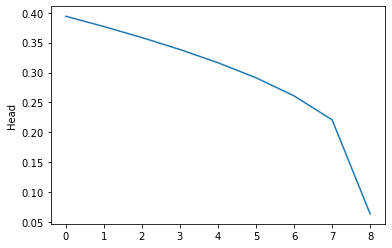

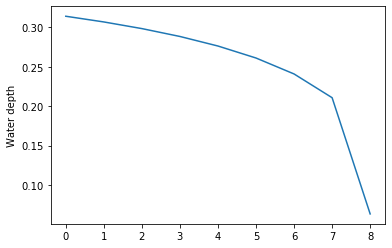

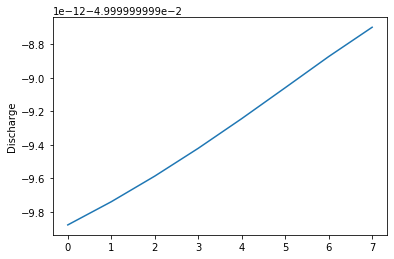

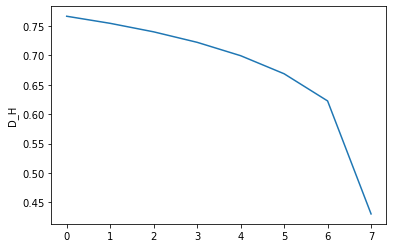

In [19]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",mg.at_node['hydraulic__head'])

figure()
plot(mg.at_node['hydraulic__head'][11:20])
ylabel('Head')

figure()
water_depth = mg.at_node['hydraulic__head'][11:20] - mg.at_node['junction__elevation'][11:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')


figure()
plot(Q[mg.active_links])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')



print('Discharge=',Q[mg.active_links])
print('D_H=',mg.at_link['hydraulic__diameter'][mg.active_links])

Need to think about downstream bndy cond. It can produce some weird effects to have an artificially low fixed head boundary. 

For fully open channel solution iteration seems to get stuck with low dQ before head ever reaches appropriate range. 

### Test Case 4 (Single conduit, Recharge boundary, steeply tilted domain)

In [3]:
mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.1*mg.node_x + 90.
mg.at_node['hydraulic__head'] = mg.at_node['junction__elevation'] + 2.1
#h = mg.at_node['hydraulic__head']


w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

mg.at_node['input__discharge'][11]=1.

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
h[mg.nodes_at_left_edge] = 100.
h[mg.nodes_at_right_edge] = 0.0


mg.set_closed_boundaries_at_grid_edges(False,True,True,True)
Q[mg.active_links] = -.1#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg,dt=1.)

for i in arange(2500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt_min=0.01, dt_max=0.01, outflow_bnd_type='head', Cr=0.5)


Number of links =  47
Number of nodes =  30
Number of active links =  8
Number of core nodes =  8
Time iteration: 0
dt= 0.01    dt_h= 5.45319849796   dt_Cr= 12.3043556228
average dh= 0.00574451688149   average abs(dQ)= 0.933550667859
num iters= 4
Time iteration: 1
average dh= 1.95333003187e-06   average abs(dQ)= 0.0093272483711
num iters= 2
Time iteration: 2
average dh= 1.07963929249e-06   average abs(dQ)= 0.00932031556142
num iters= 2
Time iteration: 3
average dh= 2.06599509871e-07   average abs(dQ)= 0.00931333847577
num iters= 2
Time iteration: 4
average dh= -6.65785235203e-07   average abs(dQ)= 0.00930631725762
num iters= 2
Time iteration: 5
average dh= -1.53751087533e-06   average abs(dQ)= 0.00929925205121
num iters= 2
Time iteration: 6
average dh= -2.40857335653e-06   average abs(dQ)= 0.00929214300148
num iters= 2
Time iteration: 7
average dh= -3.27896863832e-06   average abs(dQ)= 0.00928499025412
num iters= 2
Time iteration: 8
average dh= -4.14869269381e-06   average abs(dQ)= 0.0

average dh= -8.31709857359e-05   average abs(dQ)= 0.00841927164019
num iters= 2
Time iteration: 104
average dh= -8.39597903578e-05   average abs(dQ)= 0.00840866105582
num iters= 2
Time iteration: 105
average dh= -8.47476056634e-05   average abs(dQ)= 0.00839802352231
num iters= 2
Time iteration: 106
average dh= -8.55344291795e-05   average abs(dQ)= 0.00838735922508
num iters= 2
Time iteration: 107
average dh= -8.63202584504e-05   average abs(dQ)= 0.0083766683496
num iters= 2
Time iteration: 108
average dh= -8.71050910374e-05   average abs(dQ)= 0.00836595108145
num iters= 2
Time iteration: 109
average dh= -8.7888924519e-05   average abs(dQ)= 0.00835520760627
num iters= 2
Time iteration: 110
dt= 0.01    dt_h= 466.308907034   dt_Cr= 10.3128537178
average dh= -8.8671756491e-05   average abs(dQ)= 0.00834443810976
num iters= 2
Time iteration: 111
average dh= -8.94535845661e-05   average abs(dQ)= 0.00833364277765
num iters= 2
Time iteration: 112
average dh= -9.02344063745e-05   average abs(dQ)

average dh= -0.000159536266301   average abs(dQ)= 0.00720503872352
num iters= 2
Time iteration: 208
average dh= -0.000160212044377   average abs(dQ)= 0.00719260721491
num iters= 2
Time iteration: 209
average dh= -0.00016088666671   average abs(dQ)= 0.0071801674688
num iters= 2
Time iteration: 210
dt= 0.01    dt_h= 257.230079474   dt_Cr= 9.20957021505
average dh= -0.000161560132554   average abs(dQ)= 0.00716771965078
num iters= 2
Time iteration: 211
average dh= -0.000162232441181   average abs(dQ)= 0.00715526392601
num iters= 2
Time iteration: 212
average dh= -0.000162903591879   average abs(dQ)= 0.00714280045921
num iters= 2
Time iteration: 213
average dh= -0.000163573583947   average abs(dQ)= 0.00713032941471
num iters= 2
Time iteration: 214
average dh= -0.000164242416704   average abs(dQ)= 0.00711785095641
num iters= 2
Time iteration: 215
average dh= -0.000164910089482   average abs(dQ)= 0.00710536524776
num iters= 2
Time iteration: 216
average dh= -0.000165576601627   average abs(dQ

average dh= -0.000223557868426   average abs(dQ)= 0.00589604000662
num iters= 2
Time iteration: 312
average dh= -0.000224112047062   average abs(dQ)= 0.00588355130299
num iters= 2
Time iteration: 313
average dh= -0.000224665066322   average abs(dQ)= 0.00587106892447
num iters= 2
Time iteration: 314
average dh= -0.000225216926802   average abs(dQ)= 0.00585859298216
num iters= 2
Time iteration: 315
average dh= -0.000225767629114   average abs(dQ)= 0.00584612358657
num iters= 2
Time iteration: 316
average dh= -0.000226317173874   average abs(dQ)= 0.00583366084761
num iters= 2
Time iteration: 317
average dh= -0.000226865561714   average abs(dQ)= 0.00582120487463
num iters= 2
Time iteration: 318
average dh= -0.000227412793273   average abs(dQ)= 0.00580875577641
num iters= 2
Time iteration: 319
average dh= -0.000227958869199   average abs(dQ)= 0.00579631366111
num iters= 2
Time iteration: 320
dt= 0.01    dt_h= 182.970845388   dt_Cr= 8.38788373927
average dh= -0.000228503790153   average abs(

average dh= -0.000275572448414   average abs(dQ)= 0.00463732869965
num iters= 2
Time iteration: 417
average dh= -0.000276009826039   average abs(dQ)= 0.00462600307145
num iters= 2
Time iteration: 418
average dh= -0.00027644615311   average abs(dQ)= 0.00461469232953
num iters= 2
Time iteration: 419
average dh= -0.000276881431015   average abs(dQ)= 0.00460339652682
num iters= 2
Time iteration: 420
dt= 0.01    dt_h= 151.781528776   dt_Cr= 7.87236978221
average dh= -0.000277315661145   average abs(dQ)= 0.00459211571573
num iters= 2
Time iteration: 421
average dh= -0.000277748844897   average abs(dQ)= 0.00458084994818
num iters= 2
Time iteration: 422
average dh= -0.000278180983673   average abs(dQ)= 0.00456959927559
num iters= 2
Time iteration: 423
average dh= -0.000278612078879   average abs(dQ)= 0.00455836374888
num iters= 2
Time iteration: 424
average dh= -0.000279042131925   average abs(dQ)= 0.00454714341851
num iters= 2
Time iteration: 425
average dh= -0.000279471144227   average abs(d

average dh= -0.000316375488983   average abs(dQ)= 0.00352754745938
num iters= 2
Time iteration: 523
average dh= -0.000316709951791   average abs(dQ)= 0.00351800604599
num iters= 2
Time iteration: 524
average dh= -0.000317043530011   average abs(dQ)= 0.00350848266663
num iters= 2
Time iteration: 525
average dh= -0.000317376225317   average abs(dQ)= 0.00349897733055
num iters= 2
Time iteration: 526
average dh= -0.000317708039387   average abs(dQ)= 0.00348949004666
num iters= 2
Time iteration: 527
average dh= -0.000318038973898   average abs(dQ)= 0.00348002082358
num iters= 2
Time iteration: 528
average dh= -0.000318369030528   average abs(dQ)= 0.00347056966959
num iters= 2
Time iteration: 529
average dh= -0.000318698210956   average abs(dQ)= 0.00346113659267
num iters= 2
Time iteration: 530
dt= 0.01    dt_h= 133.098595372   dt_Cr= 7.47971611453
average dh= -0.000319026516862   average abs(dQ)= 0.00345172160049
num iters= 2
Time iteration: 531
average dh= -0.000319353949925   average abs(

average dh= -0.000346979765515   average abs(dQ)= 0.00262453062692
num iters= 2
Time iteration: 628
average dh= -0.000347230526837   average abs(dQ)= 0.00261688125778
num iters= 2
Time iteration: 629
average dh= -0.000347480579295   average abs(dQ)= 0.00260924945561
num iters= 2
Time iteration: 630
dt= 0.01    dt_h= 123.230401238   dt_Cr= 7.23142307605
average dh= -0.000347729924522   average abs(dQ)= 0.00260163520489
num iters= 2
Time iteration: 631
average dh= -0.000347978564145   average abs(dQ)= 0.00259403848993
num iters= 2
Time iteration: 632
average dh= -0.000348226499794   average abs(dQ)= 0.00258645929489
num iters= 2
Time iteration: 633
average dh= -0.000348473733095   average abs(dQ)= 0.00257889760377
num iters= 2
Time iteration: 634
average dh= -0.000348720265674   average abs(dQ)= 0.00257135340044
num iters= 2
Time iteration: 635
average dh= -0.000348966099152   average abs(dQ)= 0.00256382666859
num iters= 2
Time iteration: 636
average dh= -0.000349211235154   average abs(

average dh= -0.000369551453803   average abs(dQ)= 0.00191964539897
num iters= 2
Time iteration: 732
average dh= -0.000369736908558   average abs(dQ)= 0.00191371667969
num iters= 2
Time iteration: 733
average dh= -0.000369921814173   average abs(dQ)= 0.00190780328319
num iters= 2
Time iteration: 734
average dh= -0.000370106172073   average abs(dQ)= 0.00190190518365
num iters= 2
Time iteration: 735
average dh= -0.000370289983676   average abs(dQ)= 0.00189602235518
num iters= 2
Time iteration: 736
average dh= -0.0003704732504   average abs(dQ)= 0.00189015477183
num iters= 2
Time iteration: 737
average dh= -0.00037065597366   average abs(dQ)= 0.00188430240763
num iters= 2
Time iteration: 738
average dh= -0.000370838154868   average abs(dQ)= 0.00187846523654
num iters= 2
Time iteration: 739
average dh= -0.000371019795435   average abs(dQ)= 0.00187264323249
num iters= 2
Time iteration: 740
dt= 0.01    dt_h= 116.734474322   dt_Cr= 7.04032637125
average dh= -0.000371200896768   average abs(dQ)

average dh= -0.000386145196618   average abs(dQ)= 0.00153748272827
num iters= 2
Time iteration: 836
average dh= -0.000386280706358   average abs(dQ)= 0.00153029960027
num iters= 2
Time iteration: 837
average dh= -0.000386415801486   average abs(dQ)= 0.00152312848441
num iters= 2
Time iteration: 838
average dh= -0.00038655048316   average abs(dQ)= 0.00151596938687
num iters= 2
Time iteration: 839
average dh= -0.000386684752539   average abs(dQ)= 0.00150882231379
num iters= 2
Time iteration: 840
dt= 0.01    dt_h= 111.734967391   dt_Cr= 6.91867271469
average dh= -0.000386818610776   average abs(dQ)= 0.00150168727134
num iters= 2
Time iteration: 841
average dh= -0.000386952059025   average abs(dQ)= 0.00149456426569
num iters= 2
Time iteration: 842
average dh= -0.000387085098434   average abs(dQ)= 0.00148745330299
num iters= 2
Time iteration: 843
average dh= -0.00038721773015   average abs(dQ)= 0.00148035438939
num iters= 2
Time iteration: 844
average dh= -0.000387349955319   average abs(dQ

average dh= -0.000398413143083   average abs(dQ)= 0.00097406347074
num iters= 2
Time iteration: 942
average dh= -0.000398510674295   average abs(dQ)= 0.00097421843193
num iters= 2
Time iteration: 943
average dh= -0.000398607899986   average abs(dQ)= 0.000974377392864
num iters= 2
Time iteration: 944
average dh= -0.000398704821057   average abs(dQ)= 0.000974540302581
num iters= 2
Time iteration: 945
average dh= -0.000398801438406   average abs(dQ)= 0.000974707110205
num iters= 2
Time iteration: 946
average dh= -0.00039889775293   average abs(dQ)= 0.000974877764942
num iters= 2
Time iteration: 947
average dh= -0.000398993765522   average abs(dQ)= 0.000975052216086
num iters= 2
Time iteration: 948
average dh= -0.000399089477075   average abs(dQ)= 0.000975230413015
num iters= 2
Time iteration: 949
average dh= -0.000399184888477   average abs(dQ)= 0.000975412305194
num iters= 2
Time iteration: 950
dt= 0.01    dt_h= 109.785909481   dt_Cr= 6.49913943282
average dh= -0.000399280000615   averag

average dh= -0.000407560432019   average abs(dQ)= 0.00100493732014
num iters= 2
Time iteration: 1053
average dh= -0.000407629062698   average abs(dQ)= 0.00100524635219
num iters= 2
Time iteration: 1054
average dh= -0.00040769747466   average abs(dQ)= 0.00100555433549
num iters= 2
Time iteration: 1055
average dh= -0.000407765668572   average abs(dQ)= 0.00100586123105
num iters= 2
Time iteration: 1056
average dh= -0.000407833645104   average abs(dQ)= 0.00100616699997
num iters= 2
Time iteration: 1057
average dh= -0.00040790140492   average abs(dQ)= 0.00100647160352
num iters= 2
Time iteration: 1058
average dh= -0.000407968948683   average abs(dQ)= 0.00100677500309
num iters= 2
Time iteration: 1059
average dh= -0.000408036277056   average abs(dQ)= 0.00100707716018
num iters= 2
Time iteration: 1060
dt= 0.01    dt_h= 115.941374641   dt_Cr= 6.18905585698
average dh= -0.000408103390698   average abs(dQ)= 0.00100737803647
num iters= 2
Time iteration: 1061
average dh= -0.000408170290267   avera

average dh= -0.000413932723064   average abs(dQ)= 0.0010250466927
num iters= 2
Time iteration: 1163
average dh= -0.000413980926541   average abs(dQ)= 0.00102503781767
num iters= 2
Time iteration: 1164
average dh= -0.000414028974576   average abs(dQ)= 0.00102502449976
num iters= 2
Time iteration: 1165
average dh= -0.000414076867655   average abs(dQ)= 0.0010250067174
num iters= 2
Time iteration: 1166
average dh= -0.000414124606265   average abs(dQ)= 0.00102498444921
num iters= 2
Time iteration: 1167
average dh= -0.00041417219089   average abs(dQ)= 0.00102495767398
num iters= 2
Time iteration: 1168
average dh= -0.000414219622013   average abs(dQ)= 0.00102492637072
num iters= 2
Time iteration: 1169
average dh= -0.000414266900117   average abs(dQ)= 0.00102489051859
num iters= 2
Time iteration: 1170
dt= 0.01    dt_h= 130.883476577   dt_Cr= 6.00209999201
average dh= -0.000414314025681   average abs(dQ)= 0.00102485009696
num iters= 2
Time iteration: 1171
average dh= -0.000414360999184   averag

average dh= -0.000418022116104   average abs(dQ)= 0.000999955013854
num iters= 2
Time iteration: 1262
average dh= -0.000418057083258   average abs(dQ)= 0.000999432003199
num iters= 2
Time iteration: 1263
average dh= -0.000418091936803   average abs(dQ)= 0.000998903363716
num iters= 2
Time iteration: 1264
average dh= -0.000418126677101   average abs(dQ)= 0.000998369093571
num iters= 2
Time iteration: 1265
average dh= -0.000418161304514   average abs(dQ)= 0.000997829191136
num iters= 2
Time iteration: 1266
average dh= -0.0004181958194   average abs(dQ)= 0.000997283654986
num iters= 2
Time iteration: 1267
average dh= -0.000418230222118   average abs(dQ)= 0.000996732483903
num iters= 2
Time iteration: 1268
average dh= -0.000418264513025   average abs(dQ)= 0.000996175676875
num iters= 2
Time iteration: 1269
average dh= -0.000418298692479   average abs(dQ)= 0.000995613233091
num iters= 2
Time iteration: 1270
dt= 0.01    dt_h= 154.507876302   dt_Cr= 5.95060812186
average dh= -0.00041833276083

average dh= -0.00042080603076   average abs(dQ)= 0.000741832620159
num iters= 2
Time iteration: 1354
average dh= -0.000420831930183   average abs(dQ)= 0.000738777768014
num iters= 2
Time iteration: 1355
average dh= -0.00042085774503   average abs(dQ)= 0.000735736811493
num iters= 2
Time iteration: 1356
average dh= -0.000420883475573   average abs(dQ)= 0.00073270966686
num iters= 2
Time iteration: 1357
average dh= -0.000420909122085   average abs(dQ)= 0.000729696251045
num iters= 2
Time iteration: 1358
average dh= -0.000420934684835   average abs(dQ)= 0.000726696481641
num iters= 2
Time iteration: 1359
average dh= -0.000420960164092   average abs(dQ)= 0.000723710276893
num iters= 2
Time iteration: 1360
dt= 0.01    dt_h= 182.440627605   dt_Cr= 6.35559917109
average dh= -0.000420985560127   average abs(dQ)= 0.000720737555696
num iters= 2
Time iteration: 1361
average dh= -0.000421010873207   average abs(dQ)= 0.000717778237587
num iters= 2
Time iteration: 1362
average dh= -0.000421036103598

dt= 0.01    dt_h= 190.643546855   dt_Cr= 6.65264123924
average dh= -0.000422961834458   average abs(dQ)= 0.000501306603371
num iters= 2
Time iteration: 1451
average dh= -0.000422980680354   average abs(dQ)= 0.00049959903578
num iters= 2
Time iteration: 1452
average dh= -0.000422999464468   average abs(dQ)= 0.000497898933873
num iters= 2
Time iteration: 1453
average dh= -0.000423018186998   average abs(dQ)= 0.000496206256812
num iters= 2
Time iteration: 1454
average dh= -0.000423036848145   average abs(dQ)= 0.000494520964038
num iters= 2
Time iteration: 1455
average dh= -0.000423055448108   average abs(dQ)= 0.000492843015273
num iters= 2
Time iteration: 1456
average dh= -0.000423073987086   average abs(dQ)= 0.000491172370511
num iters= 2
Time iteration: 1457
average dh= -0.000423092465277   average abs(dQ)= 0.000489508990023
num iters= 2
Time iteration: 1458
average dh= -0.000423110882877   average abs(dQ)= 0.000487852834348
num iters= 2
Time iteration: 1459
average dh= -0.0004231292400

average dh= -0.000424488323005   average abs(dQ)= 0.000368695709654
num iters= 2
Time iteration: 1545
average dh= -0.000424502157702   average abs(dQ)= 0.000367542895296
num iters= 2
Time iteration: 1546
average dh= -0.000424515946919   average abs(dQ)= 0.00036639467616
num iters= 2
Time iteration: 1547
average dh= -0.000424529690803   average abs(dQ)= 0.00036525102993
num iters= 2
Time iteration: 1548
average dh= -0.000424543389503   average abs(dQ)= 0.00036411193443
num iters= 2
Time iteration: 1549
average dh= -0.000424557043167   average abs(dQ)= 0.000362977367608
num iters= 2
Time iteration: 1550
dt= 0.01    dt_h= 173.773853978   dt_Cr= 6.64127456229
average dh= -0.000424570651942   average abs(dQ)= 0.000361847307552
num iters= 2
Time iteration: 1551
average dh= -0.000424584215973   average abs(dQ)= 0.000360721732473
num iters= 2
Time iteration: 1552
average dh= -0.000424597735407   average abs(dQ)= 0.000359600620718
num iters= 2
Time iteration: 1553
average dh= -0.000424611210389

average dh= -0.000425747580616   average abs(dQ)= 0.00026680862871
num iters= 2
Time iteration: 1653
average dh= -0.000425757270955   average abs(dQ)= 0.000266046012528
num iters= 2
Time iteration: 1654
average dh= -0.000425766929364   average abs(dQ)= 0.000265286191639
num iters= 2
Time iteration: 1655
average dh= -0.00042577655595   average abs(dQ)= 0.000264529153875
num iters= 2
Time iteration: 1656
average dh= -0.000425786150816   average abs(dQ)= 0.000263774887134
num iters= 2
Time iteration: 1657
average dh= -0.000425795714067   average abs(dQ)= 0.000263023379377
num iters= 2
Time iteration: 1658
average dh= -0.000425805245805   average abs(dQ)= 0.000262274618626
num iters= 2
Time iteration: 1659
average dh= -0.000425814746135   average abs(dQ)= 0.000261528592968
num iters= 2
Time iteration: 1660
dt= 0.01    dt_h= 163.859808474   dt_Cr= 6.63244474148
average dh= -0.000425824215159   average abs(dQ)= 0.000260785290552
num iters= 2
Time iteration: 1661
average dh= -0.00042583365298

Time iteration: 1741
average dh= -0.000426496086783   average abs(dQ)= 0.000208641043458
num iters= 2
Time iteration: 1742
average dh= -0.000426503309234   average abs(dQ)= 0.00020808593361
num iters= 2
Time iteration: 1743
average dh= -0.000426510507856   average abs(dQ)= 0.000207532746571
num iters= 2
Time iteration: 1744
average dh= -0.000426517682727   average abs(dQ)= 0.000206981474558
num iters= 2
Time iteration: 1745
average dh= -0.000426524833925   average abs(dQ)= 0.000206432109825
num iters= 2
Time iteration: 1746
average dh= -0.000426531961528   average abs(dQ)= 0.000205884644665
num iters= 2
Time iteration: 1747
average dh= -0.000426539065614   average abs(dQ)= 0.000205339071403
num iters= 2
Time iteration: 1748
average dh= -0.000426546146259   average abs(dQ)= 0.000204795382406
num iters= 2
Time iteration: 1749
average dh= -0.000426553203541   average abs(dQ)= 0.000204253570074
num iters= 2
Time iteration: 1750
dt= 0.01    dt_h= 159.388644652   dt_Cr= 6.62727129986
average

average dh= -0.000427117286615   average abs(dQ)= 0.000161124851489
num iters= 2
Time iteration: 1843
average dh= -0.000427122458389   average abs(dQ)= 0.000160730075734
num iters= 2
Time iteration: 1844
average dh= -0.00042712761308   average abs(dQ)= 0.000160336594263
num iters= 2
Time iteration: 1845
average dh= -0.000427132750745   average abs(dQ)= 0.00015994440218
num iters= 2
Time iteration: 1846
average dh= -0.00042713787144   average abs(dQ)= 0.000159553494605
num iters= 2
Time iteration: 1847
average dh= -0.00042714297522   average abs(dQ)= 0.000159163866684
num iters= 2
Time iteration: 1848
average dh= -0.000427148062142   average abs(dQ)= 0.00015877551358
num iters= 2
Time iteration: 1849
average dh= -0.000427153132262   average abs(dQ)= 0.00015838843048
num iters= 2
Time iteration: 1850
dt= 0.01    dt_h= 156.749732074   dt_Cr= 6.62307431196
average dh= -0.000427158185633   average abs(dQ)= 0.000158002612593
num iters= 2
Time iteration: 1851
average dh= -0.000427163222312   

average dh= -0.000427591315435   average abs(dQ)= 0.000312048208889
num iters= 2
Time iteration: 1952
average dh= -0.000427594920822   average abs(dQ)= 0.0003113955208
num iters= 2
Time iteration: 1953
average dh= -0.00042759851429   average abs(dQ)= 0.000310745442331
num iters= 2
Time iteration: 1954
average dh= -0.000427602095878   average abs(dQ)= 0.00031009797892
num iters= 2
Time iteration: 1955
average dh= -0.000427605665627   average abs(dQ)= 0.000309453136004
num iters= 2
Time iteration: 1956
average dh= -0.000427609223573   average abs(dQ)= 0.000308810919022
num iters= 2
Time iteration: 1957
average dh= -0.000427612769758   average abs(dQ)= 0.000308171333414
num iters= 2
Time iteration: 1958
average dh= -0.000427616304219   average abs(dQ)= 0.000307534384619
num iters= 2
Time iteration: 1959
average dh= -0.000427619826996   average abs(dQ)= 0.00030690007808
num iters= 2
Time iteration: 1960
dt= 0.01    dt_h= 151.892777889   dt_Cr= 6.61981309022
average dh= -0.000427623338126  

average dh= -0.000427858858831   average abs(dQ)= 0.000317169773327
num iters= 2
Time iteration: 2037
average dh= -0.000427861579554   average abs(dQ)= 0.000321444537528
num iters= 2
Time iteration: 2038
average dh= -0.000427864291278   average abs(dQ)= 0.000325717647347
num iters= 2
Time iteration: 2039
average dh= -0.000427866994033   average abs(dQ)= 0.000329989098123
num iters= 2
Time iteration: 2040
dt= 0.01    dt_h= 143.665979949   dt_Cr= 6.43491572021
average dh= -0.000427869687849   average abs(dQ)= 0.000334258885369
num iters= 2
Time iteration: 2041
average dh= -0.000427872372756   average abs(dQ)= 0.000338527004776
num iters= 2
Time iteration: 2042
average dh= -0.000427875048782   average abs(dQ)= 0.00034279345221
num iters= 2
Time iteration: 2043
average dh= -0.000427877715957   average abs(dQ)= 0.000347058223719
num iters= 2
Time iteration: 2044
average dh= -0.000427880374311   average abs(dQ)= 0.000351321315527
num iters= 2
Time iteration: 2045
average dh= -0.0004278830238

average dh= -0.000428098607439   average abs(dQ)= 0.000752950522443
num iters= 2
Time iteration: 2141
average dh= -0.000428100535043   average abs(dQ)= 0.000757065925582
num iters= 2
Time iteration: 2142
average dh= -0.000428102456269   average abs(dQ)= 0.000761180374982
num iters= 2
Time iteration: 2143
average dh= -0.000428104371138   average abs(dQ)= 0.000765293892558
num iters= 2
Time iteration: 2144
average dh= -0.000428106279671   average abs(dQ)= 0.000769406500613
num iters= 2
Time iteration: 2145
average dh= -0.000428108181888   average abs(dQ)= 0.000773541298755
num iters= 2
Time iteration: 2146
average dh= -0.000428110077812   average abs(dQ)= 0.000777683118834
num iters= 2
Time iteration: 2147
average dh= -0.000428111967462   average abs(dQ)= 0.000781824288224
num iters= 2
Time iteration: 2148
average dh= -0.00042811385086   average abs(dQ)= 0.000785964832448
num iters= 2
Time iteration: 2149
average dh= -0.000428115728025   average abs(dQ)= 0.000790104777432
num iters= 2
Ti

average dh= -0.00042824742086   average abs(dQ)= 0.00112257921906
num iters= 2
Time iteration: 2230
dt= 0.01    dt_h= 128.781508302   dt_Cr= 6.07049299734
average dh= -0.000428248855998   average abs(dQ)= 0.00112680598268
num iters= 2
Time iteration: 2231
average dh= -0.000428250286387   average abs(dQ)= 0.00113103630929
num iters= 2
Time iteration: 2232
average dh= -0.000428251712042   average abs(dQ)= 0.0011352702869
num iters= 2
Time iteration: 2233
average dh= -0.000428253132977   average abs(dQ)= 0.00113950800488
num iters= 2
Time iteration: 2234
average dh= -0.00042825454921   average abs(dQ)= 0.00114374955399
num iters= 2
Time iteration: 2235
average dh= -0.000428255960756   average abs(dQ)= 0.00114799502637
num iters= 2
Time iteration: 2236
average dh= -0.000428257367629   average abs(dQ)= 0.00115224451562
num iters= 2
Time iteration: 2237
average dh= -0.000428258769847   average abs(dQ)= 0.00115649811676
num iters= 2
Time iteration: 2238
average dh= -0.000428260167423   averag

average dh= -0.000428372851762   average abs(dQ)= 0.00160172073501
num iters= 2
Time iteration: 2333
average dh= -0.000428373871712   average abs(dQ)= 0.00160721828879
num iters= 2
Time iteration: 2334
average dh= -0.000428374888285   average abs(dQ)= 0.00161274547787
num iters= 2
Time iteration: 2335
average dh= -0.000428375901493   average abs(dQ)= 0.00161830294549
num iters= 2
Time iteration: 2336
average dh= -0.000428376911347   average abs(dQ)= 0.00162389135187
num iters= 2
Time iteration: 2337
average dh= -0.000428377917858   average abs(dQ)= 0.00162951137486
num iters= 2
Time iteration: 2338
average dh= -0.000428378921037   average abs(dQ)= 0.00163516371052
num iters= 2
Time iteration: 2339
average dh= -0.000428379920895   average abs(dQ)= 0.00164084907379
num iters= 2
Time iteration: 2340
dt= 0.01    dt_h= 119.607109613   dt_Cr= 5.70053768889
average dh= -0.000428380917442   average abs(dQ)= 0.00164656819914
num iters= 2
Time iteration: 2341
average dh= -0.000428381910691   ave

average dh= -0.000428457399742   average abs(dQ)= 0.00255126299079
num iters= 3
Time iteration: 2424
average dh= -0.000428458262662   average abs(dQ)= 0.00257911067428
num iters= 3
Time iteration: 2425
average dh= -0.000428459122251   average abs(dQ)= 0.00260842140499
num iters= 3
Time iteration: 2426
average dh= -0.000428459978522   average abs(dQ)= 0.00263936400198
num iters= 3
Time iteration: 2427
average dh= -0.000428460861727   average abs(dQ)= 0.00269220913722
num iters= 4
Time iteration: 2428
average dh= -0.000428461771639   average abs(dQ)= 0.00272799612851
num iters= 4
Time iteration: 2429
average dh= -0.000428462677789   average abs(dQ)= 0.00276640193597
num iters= 4
Time iteration: 2430
dt= 0.01    dt_h= 84.7718898835   dt_Cr= 4.2936352748
average dh= -0.000428463580191   average abs(dQ)= 0.00280785884126
num iters= 4
Time iteration: 2431
average dh= -0.000428464478862   average abs(dQ)= 0.00285292656448
num iters= 4
Time iteration: 2432
average dh= -0.000428465373817   aver

Seems to be trouble with stability of steep runs, perhaps particularly with outfall boundary.

Node net fluxes =  [  9.99991440e-01  -2.93255562e+00  -1.47078418e+00  -2.42445531e-02
  -5.39470588e-04  -1.11345446e-05  -1.67911805e-07  -1.86200396e-09]
Node head =  [ 92.1         82.1         72.1         62.1         52.1
  42.1         32.1         22.1         12.1          2.1
  92.1         79.18331311  69.82598317  61.83782829  52.09490664
  42.09988775  32.09999811  22.09999998  12.1          2.1
  92.1         82.1         72.1         62.1         52.1
  42.1         32.1         22.1         12.1          2.1       ]
Discharge= [ -8.56040241e-06  -2.93256418e+00  -4.40334836e+00  -4.42759292e+00
  -4.42813239e+00  -4.42814352e+00  -4.42814369e+00  -4.42814369e+00]
D_H= [  3.99920016e-04   1.00005000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00]


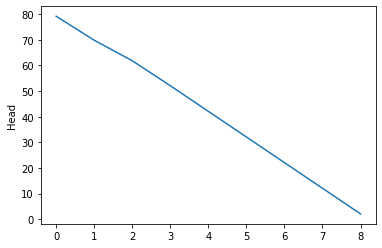

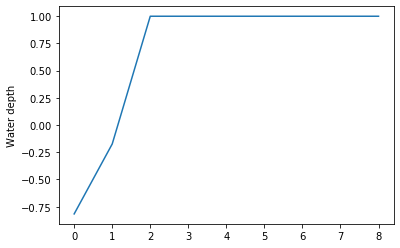

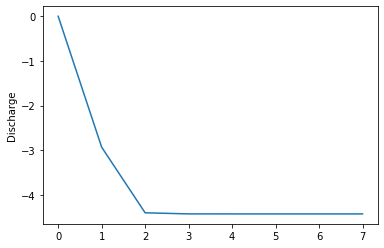

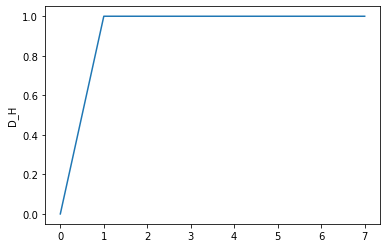

In [4]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",mg.at_node['hydraulic__head'])

figure()
plot(mg.at_node['hydraulic__head'][11:20])
ylabel('Head')

figure()
water_depth = mg.at_node['hydraulic__head'][11:20] - mg.at_node['junction__elevation'][11:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')

figure()
plot(Q[mg.active_links])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')

print('Discharge=',Q[mg.active_links])
print('D_H=',mg.at_link['hydraulic__diameter'][mg.active_links])

### Test Case 5 (single conduit, steep, head boundary)

In [6]:
mg = RasterModelGrid((3,10),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=1000.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.1*mg.node_x + 90.
#mg.at_node['hydraulic__head'] = mg.at_node['junction__elevation'] + 1.5
#h = mg.at_node['hydraulic__head']

w = mg.add_zeros('link','width')
mg.at_link['width']= 1.0*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = mg.at_link['width'].copy()

#mg.at_node['input__discharge'][11]=1.

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= mg.at_link['width']#applicable for square conduits

#print(mg.at_link['maximum__depth'])

#set heads at edges
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.
mg.at_node['hydraulic__head'][mg.nodes_at_left_edge] = mg.at_node['junction__elevation'][mg.nodes_at_left_edge] + 0.5 #100.
mg.at_node['hydraulic__head'][mg.nodes_at_right_edge] = mg.at_node['junction__elevation'][mg.nodes_at_right_edge] + 0.5


mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

pfn = PresFlowNetwork(mg,dt=1.)

for i in arange(15000):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt_min=0.01, dt_max=5.01, outflow_bnd_type='outfall', Cr=0.5)


Number of links =  47
Number of nodes =  30
Number of active links =  9
Number of core nodes =  8
Time iteration: 0
dt= 5.01    dt_h= 365.969494979   dt_Cr= 6.68840354663
average dh= 9.49640507876e-05   average abs(dQ)= 0.172276569457
num iters= 4
Time iteration: 1
average dh= 0.00130601488547   average abs(dQ)= 0.125812459046
num iters= 7
Time iteration: 2
average dh= 0.00171169563133   average abs(dQ)= 0.0181771313665
num iters= 8
Time iteration: 3
average dh= 0.00177680608596   average abs(dQ)= 0.0049379052582
num iters= 8
Time iteration: 4
average dh= 0.00179784512321   average abs(dQ)= 0.00253366026981
num iters= 8
Time iteration: 5
average dh= 0.00180941597965   average abs(dQ)= 0.00158639071445
num iters= 8
Time iteration: 6
average dh= 0.00181665482437   average abs(dQ)= 0.00103682886907
num iters= 8
Time iteration: 7
average dh= 0.00182119704776   average abs(dQ)= 0.00066294024928
num iters= 8
Time iteration: 8
average dh= 0.00182399082467   average abs(dQ)= 0.000419595318325


average dh= 0.00145775544809   average abs(dQ)= 3.69432541134e-05
num iters= 7
Time iteration: 110
dt= 4.04083863777    dt_h= 23.0856015209   dt_Cr= 4.04083863777
average dh= 0.00145758998134   average abs(dQ)= 3.69432021714e-05
num iters= 7
Time iteration: 111
average dh= 0.00145819641368   average abs(dQ)= 3.69626362673e-05
num iters= 7
Time iteration: 112
average dh= 0.00145803077192   average abs(dQ)= 3.6962654019e-05
num iters= 7
Time iteration: 113
average dh= 0.00145786512997   average abs(dQ)= 3.69626182115e-05
num iters= 7
Time iteration: 114
average dh= 0.00145769948796   average abs(dQ)= 3.69625731145e-05
num iters= 7
Time iteration: 115
average dh= 0.00145753384592   average abs(dQ)= 3.69625252879e-05
num iters= 7
Time iteration: 116
average dh= 0.00145736820387   average abs(dQ)= 3.69624760799e-05
num iters= 7
Time iteration: 117
average dh= 0.00145720256181   average abs(dQ)= 3.6962426e-05
num iters= 7
Time iteration: 118
average dh= 0.00145703691974   average abs(dQ)= 3.

average dh= 0.00144795156665   average abs(dQ)= 3.7154828004e-05
num iters= 7
Time iteration: 220
dt= 4.06459578243    dt_h= 23.1054338075   dt_Cr= 4.06459578243
average dh= 0.0014477841506   average abs(dQ)= 3.71547766211e-05
num iters= 7
Time iteration: 221
average dh= 0.00144839247489   average abs(dQ)= 3.7174554822e-05
num iters= 7
Time iteration: 222
average dh= 0.00144822487968   average abs(dQ)= 3.71745729847e-05
num iters= 7
Time iteration: 223
average dh= 0.00144805728426   average abs(dQ)= 3.71745371238e-05
num iters= 7
Time iteration: 224
average dh= 0.00144788968879   average abs(dQ)= 3.7174492027e-05
num iters= 7
Time iteration: 225
average dh= 0.00144772209329   average abs(dQ)= 3.71744442231e-05
num iters= 7
Time iteration: 226
average dh= 0.00144755449778   average abs(dQ)= 3.7174394998e-05
num iters= 7
Time iteration: 227
average dh= 0.00144738690225   average abs(dQ)= 3.71743448213e-05
num iters= 7
Time iteration: 228
average dh= 0.00144721930671   average abs(dQ)= 3.

dt= 4.08656072327    dt_h= 23.1237985154   dt_Cr= 4.08656072327
average dh= 0.00143871811071   average abs(dQ)= 3.73501776196e-05
num iters= 7
Time iteration: 321
average dh= 0.00143932811191   average abs(dQ)= 3.73702727785e-05
num iters= 7
Time iteration: 322
average dh= 0.00143915870033   average abs(dQ)= 3.7370286659e-05
num iters= 7
Time iteration: 323
average dh= 0.00143898928856   average abs(dQ)= 3.73702461579e-05
num iters= 7
Time iteration: 324
average dh= 0.00143881987673   average abs(dQ)= 3.73701965602e-05
num iters= 7
Time iteration: 325
average dh= 0.00143865046487   average abs(dQ)= 3.73701443684e-05
num iters= 7
Time iteration: 326
average dh= 0.00143848105299   average abs(dQ)= 3.73700908059e-05
num iters= 7
Time iteration: 327
average dh= 0.0014383116411   average abs(dQ)= 3.73700362999e-05
num iters= 7
Time iteration: 328
average dh= 0.00143814222919   average abs(dQ)= 3.73699811002e-05
num iters= 7
Time iteration: 329
average dh= 0.00143797281728   average abs(dQ)=

average dh= 0.00142960139378   average abs(dQ)= 3.75686357667e-05
num iters= 7
Time iteration: 425
average dh= 0.00142943012569   average abs(dQ)= 3.75685775338e-05
num iters= 7
Time iteration: 426
average dh= 0.00142925885758   average abs(dQ)= 3.75685180098e-05
num iters= 7
Time iteration: 427
average dh= 0.00142908758946   average abs(dQ)= 3.75684575745e-05
num iters= 7
Time iteration: 428
average dh= 0.00142891632132   average abs(dQ)= 3.7568396448e-05
num iters= 7
Time iteration: 429
average dh= 0.00142874505317   average abs(dQ)= 3.75683347875e-05
num iters= 7
Time iteration: 430
dt= 4.1111382368    dt_h= 23.1443814171   dt_Cr= 4.1111382368
average dh= 0.00142857378502   average abs(dQ)= 3.75682727099e-05
num iters= 7
Time iteration: 431
average dh= 0.00142918557907   average abs(dQ)= 3.75887245587e-05
num iters= 7
Time iteration: 432
average dh= 0.0014290141234   average abs(dQ)= 3.75887317823e-05
num iters= 7
Time iteration: 433
average dh= 0.00142884266753   average abs(dQ)= 3

average dh= 0.00141936429847   average abs(dQ)= 3.7769417347e-05
num iters= 7
Time iteration: 530
dt= 4.1338704871    dt_h= 23.1634513187   dt_Cr= 4.1338704871
average dh= 0.00141919113286   average abs(dQ)= 3.77693480548e-05
num iters= 7
Time iteration: 531
average dh= 0.00141980450561   average abs(dQ)= 3.77901321278e-05
num iters= 7
Time iteration: 532
average dh= 0.0014196311483   average abs(dQ)= 3.77901318858e-05
num iters= 7
Time iteration: 533
average dh= 0.00141945779078   average abs(dQ)= 3.77900764698e-05
num iters= 7
Time iteration: 534
average dh= 0.00141928443321   average abs(dQ)= 3.77900123188e-05
num iters= 7
Time iteration: 535
average dh= 0.00141911107561   average abs(dQ)= 3.77899459e-05
num iters= 7
Time iteration: 536
average dh= 0.00141893771799   average abs(dQ)= 3.77898783049e-05
num iters= 7
Time iteration: 537
average dh= 0.00141876436035   average abs(dQ)= 3.77898098584e-05
num iters= 7
Time iteration: 538
average dh= 0.00141859100269   average abs(dQ)= 3.77

average dh= 0.00141087690215   average abs(dQ)= 3.79735855027e-05
num iters= 7
Time iteration: 624
average dh= 0.00141070179655   average abs(dQ)= 3.7973513272e-05
num iters= 7
Time iteration: 625
average dh= 0.00141052669093   average abs(dQ)= 3.79734389415e-05
num iters= 7
Time iteration: 626
average dh= 0.00141035158528   average abs(dQ)= 3.79733635488e-05
num iters= 7
Time iteration: 627
average dh= 0.00141017647961   average abs(dQ)= 3.79732873738e-05
num iters= 7
Time iteration: 628
average dh= 0.00141000137392   average abs(dQ)= 3.79732105672e-05
num iters= 7
Time iteration: 629
average dh= 0.00140982626822   average abs(dQ)= 3.79731332397e-05
num iters= 7
Time iteration: 630
dt= 4.15698396791    dt_h= 23.1828732217   dt_Cr= 4.15698396791
average dh= 0.00140965116251   average abs(dQ)= 3.79730554786e-05
num iters= 7
Time iteration: 631
average dh= 0.001410266061   average abs(dQ)= 3.79941796643e-05
num iters= 7
Time iteration: 632
average dh= 0.00141009075925   average abs(dQ)= 

average dh= 0.00140110388728   average abs(dQ)= 3.81586942235e-05
num iters= 7
Time iteration: 720
dt= 4.17812094979    dt_h= 23.2006629022   dt_Cr= 4.17812094979
average dh= 0.00140092699774   average abs(dQ)= 3.81586077061e-05
num iters= 7
Time iteration: 721
average dh= 0.00140154322046   average abs(dQ)= 3.81800449467e-05
num iters= 7
Time iteration: 722
average dh= 0.00140136613086   average abs(dQ)= 3.81800267731e-05
num iters= 7
Time iteration: 723
average dh= 0.00140118904105   average abs(dQ)= 3.81799525762e-05
num iters= 7
Time iteration: 724
average dh= 0.00140101195118   average abs(dQ)= 3.81798699942e-05
num iters= 7
Time iteration: 725
average dh= 0.00140083486128   average abs(dQ)= 3.81797855117e-05
num iters= 7
Time iteration: 726
average dh= 0.00140065777135   average abs(dQ)= 3.81797001137e-05
num iters= 7
Time iteration: 727
average dh= 0.00140048068141   average abs(dQ)= 3.81796140312e-05
num iters= 7
Time iteration: 728
average dh= 0.00140030359144   average abs(dQ

average dh= 0.00139161241567   average abs(dQ)= 3.83674895077e-05
num iters= 7
Time iteration: 818
average dh= 0.00139143350067   average abs(dQ)= 3.83673928199e-05
num iters= 7
Time iteration: 819
average dh= 0.00139125458565   average abs(dQ)= 3.83672956967e-05
num iters= 7
Time iteration: 820
dt= 4.20198881072    dt_h= 23.2207840088   dt_Cr= 4.20198881072
average dh= 0.0013910756706   average abs(dQ)= 3.83671981871e-05
num iters= 7
Time iteration: 821
average dh= 0.00139169330592   average abs(dQ)= 3.83889913239e-05
num iters= 7
Time iteration: 822
average dh= 0.00139151418617   average abs(dQ)= 3.83889617277e-05
num iters= 7
Time iteration: 823
average dh= 0.00139133506621   average abs(dQ)= 3.83888755756e-05
num iters= 7
Time iteration: 824
average dh= 0.00139115594619   average abs(dQ)= 3.83887812072e-05
num iters= 7
Time iteration: 825
average dh= 0.00139097682614   average abs(dQ)= 3.8388685144e-05
num iters= 7
Time iteration: 826
average dh= 0.00139079770605   average abs(dQ)=

average dh= 0.00138022293077   average abs(dQ)= 3.85996777536e-05
num iters= 7
Time iteration: 930
dt= 4.22872172573    dt_h= 23.2433621824   dt_Cr= 4.22872172573
average dh= 0.00138004173248   average abs(dQ)= 3.85995671459e-05
num iters= 7
Time iteration: 931
average dh= 0.00138066084392   average abs(dQ)= 3.86217625966e-05
num iters= 7
Time iteration: 932
average dh= 0.00138047943561   average abs(dQ)= 3.86217195124e-05
num iters= 7
Time iteration: 933
average dh= 0.00138029802708   average abs(dQ)= 3.86216191996e-05
num iters= 7
Time iteration: 934
average dh= 0.00138011661849   average abs(dQ)= 3.86215108289e-05
num iters= 7
Time iteration: 935
average dh= 0.00137993520984   average abs(dQ)= 3.86214009902e-05
num iters= 7
Time iteration: 936
average dh= 0.00137975380116   average abs(dQ)= 3.86212905958e-05
num iters= 7
Time iteration: 937
average dh= 0.00137957239243   average abs(dQ)= 3.8621179798e-05
num iters= 7
Time iteration: 938
average dh= 0.00137939098366   average abs(dQ)

average dh= 0.00136923100879   average abs(dQ)= 3.88577276311e-05
num iters= 7
Time iteration: 1043
average dh= 0.00136904724965   average abs(dQ)= 3.88576163942e-05
num iters= 7
Time iteration: 1044
average dh= 0.00136886349041   average abs(dQ)= 3.88574972754e-05
num iters= 7
Time iteration: 1045
average dh= 0.00136867973107   average abs(dQ)= 3.88573769639e-05
num iters= 7
Time iteration: 1046
average dh= 0.00136849597166   average abs(dQ)= 3.8857256364e-05
num iters= 7
Time iteration: 1047
average dh= 0.00136831221215   average abs(dQ)= 3.88571356083e-05
num iters= 7
Time iteration: 1048
average dh= 0.00136812845257   average abs(dQ)= 3.88570147247e-05
num iters= 7
Time iteration: 1049
average dh= 0.00136794469289   average abs(dQ)= 3.88568937274e-05
num iters= 7
Time iteration: 1050
dt= 4.25847476881    dt_h= 23.2685432293   dt_Cr= 4.25847476881
average dh= 0.00136776093313   average abs(dQ)= 3.88567726278e-05
num iters= 7
Time iteration: 1051
average dh= 0.00136838155166   averag

average dh= 0.00135720268211   average abs(dQ)= 3.9098591582e-05
num iters= 7
Time iteration: 1156
average dh= 0.00135701649653   average abs(dQ)= 3.90985081528e-05
num iters= 7
Time iteration: 1157
average dh= 0.00135683031057   average abs(dQ)= 3.90984259687e-05
num iters= 7
Time iteration: 1158
average dh= 0.00135664412422   average abs(dQ)= 3.90983450859e-05
num iters= 7
Time iteration: 1159
average dh= 0.00135645793748   average abs(dQ)= 3.90982655488e-05
num iters= 7
Time iteration: 1160
dt= 4.28630729755    dt_h= 23.292148796   dt_Cr= 4.28630729755
average dh= 0.00135627175034   average abs(dQ)= 3.90981874003e-05
num iters= 7
Time iteration: 1161
average dh= 0.00135689363468   average abs(dQ)= 3.91213303537e-05
num iters= 7
Time iteration: 1162
average dh= 0.00135670722498   average abs(dQ)= 3.91213232666e-05
num iters= 7
Time iteration: 1163
average dh= 0.00135652081467   average abs(dQ)= 3.9121258736e-05
num iters= 7
Time iteration: 1164
average dh= 0.0013563344039   average a

average dh= 0.00135132673823   average abs(dQ)= 1.97360405305e-05
num iters= 7
Time iteration: 1257
average dh= 0.00135123253976   average abs(dQ)= 1.97360402676e-05
num iters= 7
Time iteration: 1258
average dh= 0.00135113834128   average abs(dQ)= 1.97360400026e-05
num iters= 7
Time iteration: 1259
average dh= 0.00135104414281   average abs(dQ)= 1.97360397375e-05
num iters= 7
Time iteration: 1260
dt= 4.31208884983    dt_h= 23.3140580893   dt_Cr= 4.31208884983
average dh= 0.00135094994433   average abs(dQ)= 1.97360394725e-05
num iters= 7
Time iteration: 1261
average dh= 0.00135167043542   average abs(dQ)= 1.97478624405e-05
num iters= 7
Time iteration: 1262
average dh= 0.00135157612351   average abs(dQ)= 1.97479314401e-05
num iters= 7
Time iteration: 1263
average dh= 0.0013514818114   average abs(dQ)= 1.97479404286e-05
num iters= 7
Time iteration: 1264
average dh= 0.00135138749928   average abs(dQ)= 1.97479414007e-05
num iters= 7
Time iteration: 1265
average dh= 0.00135129318715   averag

dt= 4.33569435854    dt_h= 23.3341547453   dt_Cr= 4.33569435854
average dh= 0.00134978663408   average abs(dQ)= 1.98439266494e-05
num iters= 7
Time iteration: 1351
average dh= 0.00135051432051   average abs(dQ)= 1.98559447074e-05
num iters= 7
Time iteration: 1352
average dh= 0.00135041897321   average abs(dQ)= 1.98560148523e-05
num iters= 7
Time iteration: 1353
average dh= 0.00135032362572   average abs(dQ)= 1.9856024017e-05
num iters= 7
Time iteration: 1354
average dh= 0.0013502282782   average abs(dQ)= 1.98560250298e-05
num iters= 7
Time iteration: 1355
average dh= 0.00135013293068   average abs(dQ)= 1.98560249528e-05
num iters= 7
Time iteration: 1356
average dh= 0.00135003758316   average abs(dQ)= 1.98560247303e-05
num iters= 7
Time iteration: 1357
average dh= 0.00134994223564   average abs(dQ)= 1.98560244886e-05
num iters= 7
Time iteration: 1358
average dh= 0.00134984688811   average abs(dQ)= 1.98560242444e-05
num iters= 7
Time iteration: 1359
average dh= 0.00134975154059   average

average dh= 0.0013490854161   average abs(dQ)= 1.99536056262e-05
num iters= 7
Time iteration: 1436
average dh= 0.00134898912896   average abs(dQ)= 1.99536054183e-05
num iters= 7
Time iteration: 1437
average dh= 0.00134889284182   average abs(dQ)= 1.99536051907e-05
num iters= 7
Time iteration: 1438
average dh= 0.00134879655468   average abs(dQ)= 1.99536049606e-05
num iters= 7
Time iteration: 1439
average dh= 0.00134870026754   average abs(dQ)= 1.99536047304e-05
num iters= 7
Time iteration: 1440
dt= 4.35969174403    dt_h= 23.3546209792   dt_Cr= 4.35969174403
average dh= 0.0013486039804   average abs(dQ)= 1.99536045002e-05
num iters= 7
Time iteration: 1441
average dh= 0.00134933900987   average abs(dQ)= 1.99658230697e-05
num iters= 7
Time iteration: 1442
average dh= 0.0013492426042   average abs(dQ)= 1.99658943879e-05
num iters= 7
Time iteration: 1443
average dh= 0.00134914619834   average abs(dQ)= 1.99659037304e-05
num iters= 7
Time iteration: 1444
average dh= 0.00134904979244   average 

average dh= 0.00134788827456   average abs(dQ)= 2.00651238403e-05
num iters= 7
Time iteration: 1526
average dh= 0.00134779090797   average abs(dQ)= 2.00651236465e-05
num iters= 7
Time iteration: 1527
average dh= 0.00134769354138   average abs(dQ)= 2.00651234326e-05
num iters= 7
Time iteration: 1528
average dh= 0.00134759617478   average abs(dQ)= 2.00651232162e-05
num iters= 7
Time iteration: 1529
average dh= 0.00134749880819   average abs(dQ)= 2.00651229995e-05
num iters= 7
Time iteration: 1530
dt= 4.38409196903    dt_h= 23.3754680526   dt_Cr= 4.38409196903
average dh= 0.0013474014416   average abs(dQ)= 2.00651227829e-05
num iters= 7
Time iteration: 1531
average dh= 0.00134814396642   average abs(dQ)= 2.00775474991e-05
num iters= 7
Time iteration: 1532
average dh= 0.00134804647863   average abs(dQ)= 2.00776200205e-05
num iters= 7
Time iteration: 1533
average dh= 0.00134794899064   average abs(dQ)= 2.00776295432e-05
num iters= 7
Time iteration: 1534
average dh= 0.00134785150261   averag

average dh= 0.00134676927762   average abs(dQ)= 2.0178534304e-05
num iters= 7
Time iteration: 1615
average dh= 0.0013466708071   average abs(dQ)= 2.01785342759e-05
num iters= 7
Time iteration: 1616
average dh= 0.00134657233659   average abs(dQ)= 2.01785340942e-05
num iters= 7
Time iteration: 1617
average dh= 0.00134647386607   average abs(dQ)= 2.01785338921e-05
num iters= 7
Time iteration: 1618
average dh= 0.00134637539555   average abs(dQ)= 2.01785336872e-05
num iters= 7
Time iteration: 1619
average dh= 0.00134627692503   average abs(dQ)= 2.01785334823e-05
num iters= 7
Time iteration: 1620
dt= 4.40890643043    dt_h= 23.3967077059   dt_Cr= 4.40890643043
average dh= 0.00134617845452   average abs(dQ)= 2.01785332774e-05
num iters= 7
Time iteration: 1621
average dh= 0.00134692863184   average abs(dQ)= 2.01911700005e-05
num iters= 7
Time iteration: 1622
average dh= 0.00134683003735   average abs(dQ)= 2.01912437563e-05
num iters= 7
Time iteration: 1623
average dh= 0.00134673144266   average

average dh= 0.00134559269881   average abs(dQ)= 2.03068197263e-05
num iters= 7
Time iteration: 1713
average dh= 0.00134549297202   average abs(dQ)= 2.03068296186e-05
num iters= 7
Time iteration: 1714
average dh= 0.00134539324519   average abs(dQ)= 2.03068307768e-05
num iters= 7
Time iteration: 1715
average dh= 0.00134529351836   average abs(dQ)= 2.03068307638e-05
num iters= 7
Time iteration: 1716
average dh= 0.00134519379153   average abs(dQ)= 2.03068305937e-05
num iters= 7
Time iteration: 1717
average dh= 0.0013450940647   average abs(dQ)= 2.03068304027e-05
num iters= 7
Time iteration: 1718
average dh= 0.00134499433787   average abs(dQ)= 2.03068302092e-05
num iters= 7
Time iteration: 1719
average dh= 0.00134489461104   average abs(dQ)= 2.03068300152e-05
num iters= 7
Time iteration: 1720
dt= 4.43697832015    dt_h= 23.4207826663   dt_Cr= 4.43697832015
average dh= 0.00134479488421   average abs(dQ)= 2.03068298213e-05
num iters= 7
Time iteration: 1721
average dh= 0.00134555375473   averag

average dh= 0.00134372854652   average abs(dQ)= 2.04244150329e-05
num iters= 7
Time iteration: 1809
average dh= 0.00134362766128   average abs(dQ)= 2.04244148476e-05
num iters= 7
Time iteration: 1810
dt= 4.46270679169    dt_h= 23.4428919649   dt_Cr= 4.46270679169
average dh= 0.00134352677605   average abs(dQ)= 2.04244146622e-05
num iters= 7
Time iteration: 1811
average dh= 0.00134429364761   average abs(dQ)= 2.04375192785e-05
num iters= 7
Time iteration: 1812
average dh= 0.00134419263225   average abs(dQ)= 2.04375957515e-05
num iters= 7
Time iteration: 1813
average dh= 0.00134409161667   average abs(dQ)= 2.04376058557e-05
num iters= 7
Time iteration: 1814
average dh= 0.00134399060107   average abs(dQ)= 2.04376070518e-05
num iters= 7
Time iteration: 1815
average dh= 0.00134388958546   average abs(dQ)= 2.04376070523e-05
num iters= 7
Time iteration: 1816
average dh= 0.00134378856985   average abs(dQ)= 2.04376068922e-05
num iters= 7
Time iteration: 1817
average dh= 0.00134368755424   avera

average dh= 0.00134290915984   average abs(dQ)= 2.05574810219e-05
num iters= 7
Time iteration: 1903
average dh= 0.00134280695556   average abs(dQ)= 2.05574913216e-05
num iters= 7
Time iteration: 1904
average dh= 0.00134270475124   average abs(dQ)= 2.05574925515e-05
num iters= 7
Time iteration: 1905
average dh= 0.00134260254692   average abs(dQ)= 2.0557492563e-05
num iters= 7
Time iteration: 1906
average dh= 0.0013425003426   average abs(dQ)= 2.0557492411e-05
num iters= 7
Time iteration: 1907
average dh= 0.00134239813827   average abs(dQ)= 2.05574922369e-05
num iters= 7
Time iteration: 1908
average dh= 0.00134229593395   average abs(dQ)= 2.05574920602e-05
num iters= 7
Time iteration: 1909
average dh= 0.00134219372963   average abs(dQ)= 2.0557491883e-05
num iters= 7
Time iteration: 1910
dt= 4.49182553054    dt_h= 23.467965671   dt_Cr= 4.49182553054
average dh= 0.00134209152531   average abs(dQ)= 2.05574917059e-05
num iters= 7
Time iteration: 1911
average dh= 0.00134286749069   average ab

average dh= 0.00134098229647   average abs(dQ)= 2.06795129772e-05
num iters= 7
Time iteration: 1999
average dh= 0.00134087887513   average abs(dQ)= 2.06795128065e-05
num iters= 7
Time iteration: 2000
dt= 4.51852552706    dt_h= 23.4910044164   dt_Cr= 4.51852552706
average dh= 0.00134077545379   average abs(dQ)= 2.06795126359e-05
num iters= 7
Time iteration: 2001
average dh= 0.00134155979332   average abs(dQ)= 2.06931147408e-05
num iters= 7
Time iteration: 2002
average dh= 0.00134145623523   average abs(dQ)= 2.06931940944e-05
num iters= 7
Time iteration: 2003
average dh= 0.00134135267691   average abs(dQ)= 2.06932046167e-05
num iters= 7
Time iteration: 2004
average dh= 0.00134124911856   average abs(dQ)= 2.0693205884e-05
num iters= 7
Time iteration: 2005
average dh= 0.00134114556021   average abs(dQ)= 2.06932059069e-05
num iters= 7
Time iteration: 2006
average dh= 0.00134104200185   average abs(dQ)= 2.06932057627e-05
num iters= 7
Time iteration: 2007
average dh= 0.0013409384435   average

average dh= 0.00134001888181   average abs(dQ)= 2.08176733338e-05
num iters= 7
Time iteration: 2094
average dh= 0.00133991407379   average abs(dQ)= 2.08176746349e-05
num iters= 7
Time iteration: 2095
average dh= 0.00133980926577   average abs(dQ)= 2.08176746675e-05
num iters= 7
Time iteration: 2096
average dh= 0.00133970445774   average abs(dQ)= 2.08176745292e-05
num iters= 7
Time iteration: 2097
average dh= 0.00133959964972   average abs(dQ)= 2.0817674368e-05
num iters= 7
Time iteration: 2098
average dh= 0.0013394948417   average abs(dQ)= 2.08176742039e-05
num iters= 7
Time iteration: 2099
average dh= 0.00133939003367   average abs(dQ)= 2.08176740394e-05
num iters= 7
Time iteration: 2100
dt= 4.54875782875    dt_h= 23.5171464626   dt_Cr= 4.54875782875
average dh= 0.00133928522565   average abs(dQ)= 2.0817673875e-05
num iters= 7
Time iteration: 2101
average dh= 0.0013400790882   average abs(dQ)= 2.0831550601e-05
num iters= 7
Time iteration: 2102
average dh= 0.00133997413973   average ab

average dh= 0.00133872072823   average abs(dQ)= 2.09585483129e-05
num iters= 7
Time iteration: 2192
average dh= 0.00133861449611   average abs(dQ)= 2.09586307269e-05
num iters= 7
Time iteration: 2193
average dh= 0.00133850826376   average abs(dQ)= 2.09586416907e-05
num iters= 7
Time iteration: 2194
average dh= 0.00133840203137   average abs(dQ)= 2.09586430297e-05
num iters= 7
Time iteration: 2195
average dh= 0.00133829579897   average abs(dQ)= 2.09586430721e-05
num iters= 7
Time iteration: 2196
average dh= 0.00133818956658   average abs(dQ)= 2.09586429399e-05
num iters= 7
Time iteration: 2197
average dh= 0.00133808333419   average abs(dQ)= 2.09586427843e-05
num iters= 7
Time iteration: 2198
average dh= 0.00133797710179   average abs(dQ)= 2.09586426254e-05
num iters= 7
Time iteration: 2199
average dh= 0.0013378708694   average abs(dQ)= 2.09586424664e-05
num iters= 7
Time iteration: 2200
dt= 4.57960504987    dt_h= 23.5438810424   dt_Cr= 4.57960504987
average dh= 0.00133776463701   averag

average dh= 0.00133669193042   average abs(dQ)= 2.10879939513e-05
num iters= 7
Time iteration: 2288
average dh= 0.00133658438259   average abs(dQ)= 2.10879937967e-05
num iters= 7
Time iteration: 2289
average dh= 0.00133647683475   average abs(dQ)= 2.10879936418e-05
num iters= 7
Time iteration: 2290
dt= 4.60791074743    dt_h= 23.5684671644   dt_Cr= 4.60791074743
average dh= 0.00133636928692   average abs(dQ)= 2.10879934868e-05
num iters= 7
Time iteration: 2291
average dh= 0.00133718190727   average abs(dQ)= 2.11024181674e-05
num iters= 7
Time iteration: 2292
average dh= 0.00133707421155   average abs(dQ)= 2.11025022704e-05
num iters= 7
Time iteration: 2293
average dh= 0.00133696651559   average abs(dQ)= 2.11025134771e-05
num iters= 7
Time iteration: 2294
average dh= 0.00133685881959   average abs(dQ)= 2.11025148543e-05
num iters= 7
Time iteration: 2295
average dh= 0.00133675112358   average abs(dQ)= 2.11025149061e-05
num iters= 7
Time iteration: 2296
average dh= 0.00133664342758   avera

average dh= 0.00133555143135   average abs(dQ)= 2.12345638358e-05
num iters= 7
Time iteration: 2384
average dh= 0.00133544238319   average abs(dQ)= 2.12345652481e-05
num iters= 7
Time iteration: 2385
average dh= 0.00133533333503   average abs(dQ)= 2.1234565308e-05
num iters= 7
Time iteration: 2386
average dh= 0.00133522428686   average abs(dQ)= 2.12345651855e-05
num iters= 7
Time iteration: 2387
average dh= 0.0013351152387   average abs(dQ)= 2.12345650382e-05
num iters= 7
Time iteration: 2388
average dh= 0.00133500619053   average abs(dQ)= 2.12345648877e-05
num iters= 7
Time iteration: 2389
average dh= 0.00133489714237   average abs(dQ)= 2.12345647367e-05
num iters= 7
Time iteration: 2390
dt= 4.6399853773    dt_h= 23.596389887   dt_Cr= 4.6399853773
average dh= 0.00133478809421   average abs(dQ)= 2.12345645859e-05
num iters= 7
Time iteration: 2391
average dh= 0.00133561095421   average abs(dQ)= 2.12492923182e-05
num iters= 7
Time iteration: 2392
average dh= 0.00133550175401   average ab

average dh= 0.00133366768871   average abs(dQ)= 2.13691259455e-05
num iters= 7
Time iteration: 2478
average dh= 0.00133355725401   average abs(dQ)= 2.13691257982e-05
num iters= 7
Time iteration: 2479
average dh= 0.00133344681931   average abs(dQ)= 2.13691256506e-05
num iters= 7
Time iteration: 2480
dt= 4.66943248102    dt_h= 23.6220842741   dt_Cr= 4.66943248102
average dh= 0.00133333638461   average abs(dQ)= 2.13691255029e-05
num iters= 7
Time iteration: 2481
average dh= 0.00133416868754   average abs(dQ)= 2.13841351664e-05
num iters= 7
Time iteration: 2482
average dh= 0.0013340580969   average abs(dQ)= 2.13842226395e-05
num iters= 7
Time iteration: 2483
average dh= 0.001333947506   average abs(dQ)= 2.13842343299e-05
num iters= 7
Time iteration: 2484
average dh= 0.00133383691506   average abs(dQ)= 2.13842357819e-05
num iters= 7
Time iteration: 2485
average dh= 0.00133372632412   average abs(dQ)= 2.13842358504e-05
num iters= 7
Time iteration: 2486
average dh= 0.00133361573318   average 

average dh= 0.0013326396399   average abs(dQ)= 2.15062765427e-05
num iters= 7
Time iteration: 2564
average dh= 0.00133252778295   average abs(dQ)= 2.15062780269e-05
num iters= 7
Time iteration: 2565
average dh= 0.00133241592601   average abs(dQ)= 2.15062781022e-05
num iters= 7
Time iteration: 2566
average dh= 0.00133230406906   average abs(dQ)= 2.15062779867e-05
num iters= 7
Time iteration: 2567
average dh= 0.00133219221211   average abs(dQ)= 2.15062778457e-05
num iters= 7
Time iteration: 2568
average dh= 0.00133208035516   average abs(dQ)= 2.15062777011e-05
num iters= 7
Time iteration: 2569
average dh= 0.00133196849821   average abs(dQ)= 2.15062775562e-05
num iters= 7
Time iteration: 2570
dt= 4.69944730274    dt_h= 23.6483324229   dt_Cr= 4.69944730274
average dh= 0.00133185664126   average abs(dQ)= 2.15062774112e-05
num iters= 7
Time iteration: 2571
average dh= 0.00133269861039   average abs(dQ)= 2.15215781158e-05
num iters= 7
Time iteration: 2572
average dh= 0.00133258659346   averag

average dh= 0.00133102784865   average abs(dQ)= 2.16461050697e-05
num iters= 7
Time iteration: 2655
average dh= 0.00133091453235   average abs(dQ)= 2.1646105152e-05
num iters= 7
Time iteration: 2656
average dh= 0.00133080121605   average abs(dQ)= 2.16461050398e-05
num iters= 7
Time iteration: 2657
average dh= 0.00133068789975   average abs(dQ)= 2.16461049014e-05
num iters= 7
Time iteration: 2658
average dh= 0.00133057458345   average abs(dQ)= 2.16461047591e-05
num iters= 7
Time iteration: 2659
average dh= 0.00133046126716   average abs(dQ)= 2.16461046167e-05
num iters= 7
Time iteration: 2660
dt= 4.73004831938    dt_h= 23.6751540972   dt_Cr= 4.73004831938
average dh= 0.00133034795086   average abs(dQ)= 2.1646104474e-05
num iters= 7
Time iteration: 2661
average dh= 0.00133119981751   average abs(dQ)= 2.16617057466e-05
num iters= 7
Time iteration: 2662
average dh= 0.00133108633702   average abs(dQ)= 2.16617966228e-05
num iters= 7
Time iteration: 2663
average dh= 0.00133097285626   average

dt= 4.76125486075    dt_h= 23.7025700497   dt_Cr= 4.76125486075
average dh= 0.00132880935788   average abs(dQ)= 2.1788694738e-05
num iters= 7
Time iteration: 2751
average dh= 0.00132967136187   average abs(dQ)= 2.1804606548e-05
num iters= 7
Time iteration: 2752
average dh= 0.00132955637909   average abs(dQ)= 2.18046992087e-05
num iters= 7
Time iteration: 2753
average dh= 0.00132944139602   average abs(dQ)= 2.18047116428e-05
num iters= 7
Time iteration: 2754
average dh= 0.00132932641292   average abs(dQ)= 2.18047132063e-05
num iters= 7
Time iteration: 2755
average dh= 0.00132921142981   average abs(dQ)= 2.18047132968e-05
num iters= 7
Time iteration: 2756
average dh= 0.0013290964467   average abs(dQ)= 2.18047131876e-05
num iters= 7
Time iteration: 2757
average dh= 0.00132898146359   average abs(dQ)= 2.18047130514e-05
num iters= 7
Time iteration: 2758
average dh= 0.00132886648048   average abs(dQ)= 2.18047129116e-05
num iters= 7
Time iteration: 2759
average dh= 0.00132875149738   average 

average dh= 0.00132718004679   average abs(dQ)= 2.19504815371e-05
num iters= 7
Time iteration: 2850
dt= 4.79666362117    dt_h= 23.7337557723   dt_Cr= 4.79666362117
average dh= 0.00132706352107   average abs(dQ)= 2.19504813984e-05
num iters= 7
Time iteration: 2851
average dh= 0.00132793708086   average abs(dQ)= 2.1966750514e-05
num iters= 7
Time iteration: 2852
average dh= 0.00132782038152   average abs(dQ)= 2.19668452264e-05
num iters= 7
Time iteration: 2853
average dh= 0.00132770368189   average abs(dQ)= 2.19668579548e-05
num iters= 7
Time iteration: 2854
average dh= 0.00132758698222   average abs(dQ)= 2.19668595617e-05
num iters= 7
Time iteration: 2855
average dh= 0.00132747028254   average abs(dQ)= 2.19668596601e-05
num iters= 7
Time iteration: 2856
average dh= 0.00132735358287   average abs(dQ)= 2.19668595536e-05
num iters= 7
Time iteration: 2857
average dh= 0.00132723688319   average abs(dQ)= 2.19668594194e-05
num iters= 7
Time iteration: 2858
average dh= 0.00132712018351   averag

average dh= 0.00132551466849   average abs(dQ)= 2.21159263478e-05
num iters= 7
Time iteration: 2949
average dh= 0.0013253963795   average abs(dQ)= 2.21159262107e-05
num iters= 7
Time iteration: 2950
dt= 4.83287409597    dt_h= 23.7657336641   dt_Cr= 4.83287409597
average dh= 0.0013252780905   average abs(dQ)= 2.21159260737e-05
num iters= 7
Time iteration: 2951
average dh= 0.00132616352601   average abs(dQ)= 2.21325660682e-05
num iters= 7
Time iteration: 2952
average dh= 0.00132604505809   average abs(dQ)= 2.21326629087e-05
num iters= 7
Time iteration: 2953
average dh= 0.00132592658987   average abs(dQ)= 2.21326759424e-05
num iters= 7
Time iteration: 2954
average dh= 0.00132580812162   average abs(dQ)= 2.21326775942e-05
num iters= 7
Time iteration: 2955
average dh= 0.00132568965335   average abs(dQ)= 2.21326777e-05
num iters= 7
Time iteration: 2956
average dh= 0.00132557118509   average abs(dQ)= 2.21326775961e-05
num iters= 7
Time iteration: 2957
average dh= 0.00132545271682   average ab

average dh= 0.0013235716543   average abs(dQ)= 2.22851687816e-05
num iters= 7
Time iteration: 3050
dt= 4.86991699796    dt_h= 23.7985371075   dt_Cr= 4.86991699796
average dh= 0.00132345154785   average abs(dQ)= 2.22851686458e-05
num iters= 7
Time iteration: 3051
average dh= 0.00132434919256   average abs(dQ)= 2.23021938253e-05
num iters= 7
Time iteration: 3052
average dh= 0.00132422890165   average abs(dQ)= 2.23022928744e-05
num iters= 7
Time iteration: 3053
average dh= 0.00132410861042   average abs(dQ)= 2.23023062251e-05
num iters= 7
Time iteration: 3054
average dh= 0.00132398831916   average abs(dQ)= 2.23023079232e-05
num iters= 7
Time iteration: 3055
average dh= 0.00132386802788   average abs(dQ)= 2.23023080367e-05
num iters= 7
Time iteration: 3056
average dh= 0.00132374773661   average abs(dQ)= 2.23023079348e-05
num iters= 7
Time iteration: 3057
average dh= 0.00132362744534   average abs(dQ)= 2.23023078036e-05
num iters= 7
Time iteration: 3058
average dh= 0.00132350715407   averag

average dh= 0.00132207021449   average abs(dQ)= 2.24583571413e-05
num iters= 7
Time iteration: 3147
average dh= 0.00132194823387   average abs(dQ)= 2.2458357011e-05
num iters= 7
Time iteration: 3148
average dh= 0.00132182625326   average abs(dQ)= 2.24583568766e-05
num iters= 7
Time iteration: 3149
average dh= 0.00132170427264   average abs(dQ)= 2.24583567419e-05
num iters= 7
Time iteration: 3150
dt= 4.90782471259    dt_h= 23.8322014625   dt_Cr= 4.90782471259
average dh= 0.00132158229203   average abs(dQ)= 2.24583566069e-05
num iters= 7
Time iteration: 3151
average dh= 0.00132249249382   average abs(dQ)= 2.24757820622e-05
num iters= 7
Time iteration: 3152
average dh= 0.00132237032293   average abs(dQ)= 2.24758834049e-05
num iters= 7
Time iteration: 3153
average dh= 0.00132224815173   average abs(dQ)= 2.24758970849e-05
num iters= 7
Time iteration: 3154
average dh= 0.00132212598048   average abs(dQ)= 2.24758988309e-05
num iters= 7
Time iteration: 3155
average dh= 0.00132200380923   averag

average dh= 0.00132048063779   average abs(dQ)= 2.2617728171e-05
num iters= 7
Time iteration: 3236
average dh= 0.00132035691972   average abs(dQ)= 2.26177280723e-05
num iters= 7
Time iteration: 3237
average dh= 0.00132023320165   average abs(dQ)= 2.26177279428e-05
num iters= 7
Time iteration: 3238
average dh= 0.00132010948357   average abs(dQ)= 2.2617727809e-05
num iters= 7
Time iteration: 3239
average dh= 0.0013199857655   average abs(dQ)= 2.26177276748e-05
num iters= 7
Time iteration: 3240
dt= 4.94270927884    dt_h= 23.8632663998   dt_Cr= 4.94270927884
average dh= 0.00131986204743   average abs(dQ)= 2.26177275404e-05
num iters= 7
Time iteration: 3241
average dh= 0.00132078386055   average abs(dQ)= 2.26355268402e-05
num iters= 7
Time iteration: 3242
average dh= 0.00132065994674   average abs(dQ)= 2.26356303235e-05
num iters= 7
Time iteration: 3243
average dh= 0.00132053603261   average abs(dQ)= 2.26356443112e-05
num iters= 7
Time iteration: 3244
average dh= 0.00132041211844   average 

average dh= 0.00131878685592   average abs(dQ)= 2.27988464004e-05
num iters= 7
Time iteration: 3334
average dh= 0.00131866114837   average abs(dQ)= 2.2798848237e-05
num iters= 7
Time iteration: 3335
average dh= 0.00131853544082   average abs(dQ)= 2.27988483719e-05
num iters= 7
Time iteration: 3336
average dh= 0.00131840973327   average abs(dQ)= 2.27988482747e-05
num iters= 7
Time iteration: 3337
average dh= 0.00131828402571   average abs(dQ)= 2.27988481457e-05
num iters= 7
Time iteration: 3338
average dh= 0.00131815831816   average abs(dQ)= 2.27988480125e-05
num iters= 7
Time iteration: 3339
average dh= 0.00131803261061   average abs(dQ)= 2.27988478786e-05
num iters= 7
Time iteration: 3340
dt= 4.98235588026    dt_h= 23.8986716642   dt_Cr= 4.98235588026
average dh= 0.00131790690306   average abs(dQ)= 2.27988477447e-05
num iters= 7
Time iteration: 3341
average dh= 0.00131884197682   average abs(dQ)= 2.28170783594e-05
num iters= 7
Time iteration: 3342
average dh= 0.00131871606718   averag

average dh= 0.0013149833709   average abs(dQ)= 2.29437899578e-05
num iters= 7
Time iteration: 3430
dt= 5.01    dt_h= 23.9541267274   dt_Cr= 5.01886102887
average dh= 0.00131485605982   average abs(dQ)= 2.29437898242e-05
num iters= 7
Time iteration: 3431
average dh= 0.00131472874873   average abs(dQ)= 2.29437896904e-05
num iters= 7
Time iteration: 3432
average dh= 0.00131460143765   average abs(dQ)= 2.29437895569e-05
num iters= 7
Time iteration: 3433
average dh= 0.00131447412656   average abs(dQ)= 2.29437894233e-05
num iters= 7
Time iteration: 3434
average dh= 0.00131434681548   average abs(dQ)= 2.29437892898e-05
num iters= 7
Time iteration: 3435
average dh= 0.0013142195044   average abs(dQ)= 2.29437891561e-05
num iters= 7
Time iteration: 3436
average dh= 0.00131409219332   average abs(dQ)= 2.29437890226e-05
num iters= 7
Time iteration: 3437
average dh= 0.00131396488223   average abs(dQ)= 2.2943788889e-05
num iters= 7
Time iteration: 3438
average dh= 0.00131383757115   average abs(dQ)= 

average dh= 0.00130288881885   average abs(dQ)= 2.2943777316e-05
num iters= 7
Time iteration: 3525
average dh= 0.00130276150779   average abs(dQ)= 2.29437771835e-05
num iters= 7
Time iteration: 3526
average dh= 0.00130263419673   average abs(dQ)= 2.2943777051e-05
num iters= 7
Time iteration: 3527
average dh= 0.00130250688566   average abs(dQ)= 2.29437769185e-05
num iters= 7
Time iteration: 3528
average dh= 0.0013023795746   average abs(dQ)= 2.29437767859e-05
num iters= 7
Time iteration: 3529
average dh= 0.00130225226354   average abs(dQ)= 2.29437766535e-05
num iters= 7
Time iteration: 3530
dt= 5.01    dt_h= 24.1883345224   dt_Cr= 5.06015537568
average dh= 0.00130212495247   average abs(dQ)= 2.2943776521e-05
num iters= 7
Time iteration: 3531
average dh= 0.00130199764141   average abs(dQ)= 2.29437763885e-05
num iters= 7
Time iteration: 3532
average dh= 0.00130187033035   average abs(dQ)= 2.29437762562e-05
num iters= 7
Time iteration: 3533
average dh= 0.00130174301929   average abs(dQ)= 2

average dh= 0.00129053964666   average abs(dQ)= 2.29437645023e-05
num iters= 7
Time iteration: 3622
average dh= 0.00129041233562   average abs(dQ)= 2.29437643707e-05
num iters= 7
Time iteration: 3623
average dh= 0.00129028502457   average abs(dQ)= 2.2943764239e-05
num iters= 7
Time iteration: 3624
average dh= 0.00129015771353   average abs(dQ)= 2.29437641073e-05
num iters= 7
Time iteration: 3625
average dh= 0.00129003040249   average abs(dQ)= 2.29437639757e-05
num iters= 7
Time iteration: 3626
average dh= 0.00128990309145   average abs(dQ)= 2.29437638439e-05
num iters= 7
Time iteration: 3627
average dh= 0.0012897757804   average abs(dQ)= 2.29437637122e-05
num iters= 7
Time iteration: 3628
average dh= 0.00128964846936   average abs(dQ)= 2.29437635807e-05
num iters= 7
Time iteration: 3629
average dh= 0.00128952115832   average abs(dQ)= 2.29437634489e-05
num iters= 7
Time iteration: 3630
dt= 5.01    dt_h= 24.4271672937   dt_Cr= 5.10213487867
average dh= 0.00128939384728   average abs(dQ)=

average dh= 0.00127806316548   average abs(dQ)= 2.2943751625e-05
num iters= 7
Time iteration: 3720
dt= 5.01    dt_h= 24.6461853873   dt_Cr= 5.14051643951
average dh= 0.00127793585445   average abs(dQ)= 2.29437514938e-05
num iters= 7
Time iteration: 3721
average dh= 0.00127780854343   average abs(dQ)= 2.29437513627e-05
num iters= 7
Time iteration: 3722
average dh= 0.00127768123241   average abs(dQ)= 2.29437512314e-05
num iters= 7
Time iteration: 3723
average dh= 0.00127755392139   average abs(dQ)= 2.29437511005e-05
num iters= 7
Time iteration: 3724
average dh= 0.00127742661037   average abs(dQ)= 2.29437509692e-05
num iters= 7
Time iteration: 3725
average dh= 0.00127729929935   average abs(dQ)= 2.29437508382e-05
num iters= 7
Time iteration: 3726
average dh= 0.00127717198833   average abs(dQ)= 2.29437507071e-05
num iters= 7
Time iteration: 3727
average dh= 0.00127704467731   average abs(dQ)= 2.29437505759e-05
num iters= 7
Time iteration: 3728
average dh= 0.00127691736629   average abs(dQ)

average dh= 0.00126635055238   average abs(dQ)= 2.29437395739e-05
num iters= 7
Time iteration: 3812
average dh= 0.00126622324138   average abs(dQ)= 2.29437394431e-05
num iters= 7
Time iteration: 3813
average dh= 0.00126609593038   average abs(dQ)= 2.29437393122e-05
num iters= 7
Time iteration: 3814
average dh= 0.00126596861938   average abs(dQ)= 2.29437391813e-05
num iters= 7
Time iteration: 3815
average dh= 0.00126584130838   average abs(dQ)= 2.29437390505e-05
num iters= 7
Time iteration: 3816
average dh= 0.00126571399738   average abs(dQ)= 2.29437389196e-05
num iters= 7
Time iteration: 3817
average dh= 0.00126558668637   average abs(dQ)= 2.29437387887e-05
num iters= 7
Time iteration: 3818
average dh= 0.00126545937537   average abs(dQ)= 2.29437386579e-05
num iters= 7
Time iteration: 3819
average dh= 0.00126533206437   average abs(dQ)= 2.2943738527e-05
num iters= 7
Time iteration: 3820
dt= 5.01    dt_h= 24.8941914106   dt_Cr= 5.18384558995
average dh= 0.00126520475337   average abs(dQ)

average dh= 0.00125438331917   average abs(dQ)= 2.29437272757e-05
num iters= 7
Time iteration: 3906
average dh= 0.00125425600819   average abs(dQ)= 2.29437271448e-05
num iters= 7
Time iteration: 3907
average dh= 0.00125412869721   average abs(dQ)= 2.2943727014e-05
num iters= 7
Time iteration: 3908
average dh= 0.00125400138623   average abs(dQ)= 2.29437268832e-05
num iters= 7
Time iteration: 3909
average dh= 0.00125387407525   average abs(dQ)= 2.29437267525e-05
num iters= 7
Time iteration: 3910
dt= 5.01    dt_h= 25.1217032162   dt_Cr= 5.22347111756
average dh= 0.00125374676427   average abs(dQ)= 2.29437266215e-05
num iters= 7
Time iteration: 3911
average dh= 0.00125361945329   average abs(dQ)= 2.29437264907e-05
num iters= 7
Time iteration: 3912
average dh= 0.00125349214231   average abs(dQ)= 2.29437263598e-05
num iters= 7
Time iteration: 3913
average dh= 0.00125336483133   average abs(dQ)= 2.2943726229e-05
num iters= 7
Time iteration: 3914
average dh= 0.00125323752035   average abs(dQ)=

average dh= 0.00124330726463   average abs(dQ)= 2.2943715887e-05
num iters= 7
Time iteration: 3993
average dh= 0.00124317995366   average abs(dQ)= 2.29437157561e-05
num iters= 7
Time iteration: 3994
average dh= 0.0012430526427   average abs(dQ)= 2.2943715625e-05
num iters= 7
Time iteration: 3995
average dh= 0.00124292533174   average abs(dQ)= 2.2943715494e-05
num iters= 7
Time iteration: 3996
average dh= 0.00124279802078   average abs(dQ)= 2.2943715363e-05
num iters= 7
Time iteration: 3997
average dh= 0.00124267070982   average abs(dQ)= 2.2943715232e-05
num iters= 7
Time iteration: 3998
average dh= 0.00124254339886   average abs(dQ)= 2.29437151009e-05
num iters= 7
Time iteration: 3999
average dh= 0.0012424160879   average abs(dQ)= 2.29437149699e-05
num iters= 7
Time iteration: 4000
dt= 5.01    dt_h= 25.3534118222   dt_Cr= 5.26370710361
average dh= 0.00124228877694   average abs(dQ)= 2.29437148389e-05
num iters= 7
Time iteration: 4001
average dh= 0.00124216146598   average abs(dQ)= 2.29

average dh= 0.00123197658987   average abs(dQ)= 2.29437042116e-05
num iters= 7
Time iteration: 4082
average dh= 0.00123184927892   average abs(dQ)= 2.29437040802e-05
num iters= 7
Time iteration: 4083
average dh= 0.00123172196798   average abs(dQ)= 2.29437039489e-05
num iters= 7
Time iteration: 4084
average dh= 0.00123159465704   average abs(dQ)= 2.29437038174e-05
num iters= 7
Time iteration: 4085
average dh= 0.0012314673461   average abs(dQ)= 2.2943703686e-05
num iters= 7
Time iteration: 4086
average dh= 0.00123134003516   average abs(dQ)= 2.29437035546e-05
num iters= 7
Time iteration: 4087
average dh= 0.00123121272422   average abs(dQ)= 2.29437034231e-05
num iters= 7
Time iteration: 4088
average dh= 0.00123108541327   average abs(dQ)= 2.29437032917e-05
num iters= 7
Time iteration: 4089
average dh= 0.00123095810233   average abs(dQ)= 2.29437031603e-05
num iters= 7
Time iteration: 4090
dt= 5.01    dt_h= 25.5894344356   dt_Cr= 5.30456776436
average dh= 0.00123083079139   average abs(dQ)=

average dh= 0.00122039129502   average abs(dQ)= 2.29436922286e-05
num iters= 7
Time iteration: 4173
average dh= 0.0012202639841   average abs(dQ)= 2.29436920965e-05
num iters= 7
Time iteration: 4174
average dh= 0.00122013667318   average abs(dQ)= 2.29436919646e-05
num iters= 7
Time iteration: 4175
average dh= 0.00122000936226   average abs(dQ)= 2.29436918324e-05
num iters= 7
Time iteration: 4176
average dh= 0.00121988205133   average abs(dQ)= 2.29436917005e-05
num iters= 7
Time iteration: 4177
average dh= 0.00121975474041   average abs(dQ)= 2.29436915684e-05
num iters= 7
Time iteration: 4178
average dh= 0.00121962742949   average abs(dQ)= 2.29436914364e-05
num iters= 7
Time iteration: 4179
average dh= 0.00121950011857   average abs(dQ)= 2.29436913043e-05
num iters= 7
Time iteration: 4180
dt= 5.01    dt_h= 25.8298926685   dt_Cr= 5.34606776095
average dh= 0.00121937280765   average abs(dQ)= 2.29436911722e-05
num iters= 7
Time iteration: 4181
average dh= 0.00121924549673   average abs(dQ)

average dh= 0.00120906062383   average abs(dQ)= 2.2943680446e-05
num iters= 7
Time iteration: 4262
average dh= 0.00120893331293   average abs(dQ)= 2.29436803132e-05
num iters= 7
Time iteration: 4263
average dh= 0.00120880600203   average abs(dQ)= 2.29436801803e-05
num iters= 7
Time iteration: 4264
average dh= 0.00120867869112   average abs(dQ)= 2.29436800475e-05
num iters= 7
Time iteration: 4265
average dh= 0.00120855138022   average abs(dQ)= 2.29436799147e-05
num iters= 7
Time iteration: 4266
average dh= 0.00120842406932   average abs(dQ)= 2.29436797818e-05
num iters= 7
Time iteration: 4267
average dh= 0.00120829675842   average abs(dQ)= 2.2943679649e-05
num iters= 7
Time iteration: 4268
average dh= 0.00120816944752   average abs(dQ)= 2.29436795161e-05
num iters= 7
Time iteration: 4269
average dh= 0.00120804213662   average abs(dQ)= 2.29436793832e-05
num iters= 7
Time iteration: 4270
dt= 5.01    dt_h= 26.0749127476   dt_Cr= 5.38822221692
average dh= 0.00120791482572   average abs(dQ)=

average dh= 0.00119671146737   average abs(dQ)= 2.2943667512e-05
num iters= 7
Time iteration: 4359
average dh= 0.00119658415649   average abs(dQ)= 2.2943667378e-05
num iters= 7
Time iteration: 4360
dt= 5.01    dt_h= 26.3246257345   dt_Cr= 5.43104673661
average dh= 0.00119645684561   average abs(dQ)= 2.29436672441e-05
num iters= 7
Time iteration: 4361
average dh= 0.00119632953474   average abs(dQ)= 2.29436671101e-05
num iters= 7
Time iteration: 4362
average dh= 0.00119620222386   average abs(dQ)= 2.29436669762e-05
num iters= 7
Time iteration: 4363
average dh= 0.00119607491298   average abs(dQ)= 2.29436668422e-05
num iters= 7
Time iteration: 4364
average dh= 0.0011959476021   average abs(dQ)= 2.29436667083e-05
num iters= 7
Time iteration: 4365
average dh= 0.00119582029122   average abs(dQ)= 2.29436665742e-05
num iters= 7
Time iteration: 4366
average dh= 0.00119569298034   average abs(dQ)= 2.29436664402e-05
num iters= 7
Time iteration: 4367
average dh= 0.00119556566946   average abs(dQ)= 

average dh= 0.00118512617821   average abs(dQ)= 2.294365527e-05
num iters= 7
Time iteration: 4450
dt= 5.01    dt_h= 26.5791677598   dt_Cr= 5.47455742438
average dh= 0.00118499886735   average abs(dQ)= 2.29436551348e-05
num iters= 7
Time iteration: 4451
average dh= 0.00118487155649   average abs(dQ)= 2.29436549996e-05
num iters= 7
Time iteration: 4452
average dh= 0.00118474424563   average abs(dQ)= 2.29436548644e-05
num iters= 7
Time iteration: 4453
average dh= 0.00118461693477   average abs(dQ)= 2.29436547292e-05
num iters= 7
Time iteration: 4454
average dh= 0.00118448962392   average abs(dQ)= 2.29436545939e-05
num iters= 7
Time iteration: 4455
average dh= 0.00118436231306   average abs(dQ)= 2.29436544587e-05
num iters= 7
Time iteration: 4456
average dh= 0.0011842350022   average abs(dQ)= 2.29436543234e-05
num iters= 7
Time iteration: 4457
average dh= 0.00118410769134   average abs(dQ)= 2.29436541881e-05
num iters= 7
Time iteration: 4458
average dh= 0.00118398038048   average abs(dQ)= 

dt= 5.01    dt_h= 26.8386802706   dt_Cr= 5.51877090485
average dh= 0.00117354089094   average abs(dQ)= 2.29436429034e-05
num iters= 7
Time iteration: 4541
average dh= 0.00117341358011   average abs(dQ)= 2.29436427668e-05
num iters= 7
Time iteration: 4542
average dh= 0.00117328626927   average abs(dQ)= 2.29436426302e-05
num iters= 7
Time iteration: 4543
average dh= 0.00117315895843   average abs(dQ)= 2.29436424935e-05
num iters= 7
Time iteration: 4544
average dh= 0.00117303164759   average abs(dQ)= 2.29436423567e-05
num iters= 7
Time iteration: 4545
average dh= 0.00117290433675   average abs(dQ)= 2.29436422199e-05
num iters= 7
Time iteration: 4546
average dh= 0.00117277702592   average abs(dQ)= 2.29436420833e-05
num iters= 7
Time iteration: 4547
average dh= 0.00117264971508   average abs(dQ)= 2.29436419464e-05
num iters= 7
Time iteration: 4548
average dh= 0.00117252240424   average abs(dQ)= 2.29436418097e-05
num iters= 7
Time iteration: 4549
average dh= 0.00117239509341   average abs(dQ

average dh= 0.00116221022723   average abs(dQ)= 2.29436306691e-05
num iters= 7
Time iteration: 4630
dt= 5.01    dt_h= 27.1033102927   dt_Cr= 5.56370434405
average dh= 0.00116208291641   average abs(dQ)= 2.29436305307e-05
num iters= 7
Time iteration: 4631
average dh= 0.00116195560559   average abs(dQ)= 2.29436303924e-05
num iters= 7
Time iteration: 4632
average dh= 0.00116182829478   average abs(dQ)= 2.29436302541e-05
num iters= 7
Time iteration: 4633
average dh= 0.00116170098396   average abs(dQ)= 2.29436301157e-05
num iters= 7
Time iteration: 4634
average dh= 0.00116157367314   average abs(dQ)= 2.29436299773e-05
num iters= 7
Time iteration: 4635
average dh= 0.00116144636233   average abs(dQ)= 2.29436298389e-05
num iters= 7
Time iteration: 4636
average dh= 0.00116131905151   average abs(dQ)= 2.29436297004e-05
num iters= 7
Time iteration: 4637
average dh= 0.00116119174069   average abs(dQ)= 2.2943629562e-05
num iters= 7
Time iteration: 4638
average dh= 0.00116106442988   average abs(dQ)

average dh= 0.00115049763298   average abs(dQ)= 2.2943617857e-05
num iters= 7
Time iteration: 4722
average dh= 0.00115037032218   average abs(dQ)= 2.29436177167e-05
num iters= 7
Time iteration: 4723
average dh= 0.00115024301138   average abs(dQ)= 2.29436175764e-05
num iters= 7
Time iteration: 4724
average dh= 0.00115011570059   average abs(dQ)= 2.29436174361e-05
num iters= 7
Time iteration: 4725
average dh= 0.00114998838979   average abs(dQ)= 2.29436172958e-05
num iters= 7
Time iteration: 4726
average dh= 0.001149861079   average abs(dQ)= 2.29436171554e-05
num iters= 7
Time iteration: 4727
average dh= 0.0011497337682   average abs(dQ)= 2.29436170151e-05
num iters= 7
Time iteration: 4728
average dh= 0.00114960645741   average abs(dQ)= 2.29436168747e-05
num iters= 7
Time iteration: 4729
average dh= 0.00114947914661   average abs(dQ)= 2.29436167343e-05
num iters= 7
Time iteration: 4730
dt= 5.01    dt_h= 27.4035318228   dt_Cr= 5.61449636752
average dh= 0.00114935183582   average abs(dQ)= 2

average dh= 0.00113853041917   average abs(dQ)= 2.29436045707e-05
num iters= 7
Time iteration: 4816
average dh= 0.0011384031084   average abs(dQ)= 2.29436044282e-05
num iters= 7
Time iteration: 4817
average dh= 0.00113827579762   average abs(dQ)= 2.29436042857e-05
num iters= 7
Time iteration: 4818
average dh= 0.00113814848685   average abs(dQ)= 2.29436041432e-05
num iters= 7
Time iteration: 4819
average dh= 0.00113802117607   average abs(dQ)= 2.29436040006e-05
num iters= 7
Time iteration: 4820
dt= 5.01    dt_h= 27.6794750279   dt_Cr= 5.66100865764
average dh= 0.0011378938653   average abs(dQ)= 2.2943603858e-05
num iters= 7
Time iteration: 4821
average dh= 0.00113776655453   average abs(dQ)= 2.29436037154e-05
num iters= 7
Time iteration: 4822
average dh= 0.00113763924376   average abs(dQ)= 2.29436035728e-05
num iters= 7
Time iteration: 4823
average dh= 0.00113751193298   average abs(dQ)= 2.29436034301e-05
num iters= 7
Time iteration: 4824
average dh= 0.00113738462221   average abs(dQ)= 

average dh= 0.00112592665372   average abs(dQ)= 2.29435903383e-05
num iters= 7
Time iteration: 4915
average dh= 0.00112579934297   average abs(dQ)= 2.29435901932e-05
num iters= 7
Time iteration: 4916
average dh= 0.00112567203222   average abs(dQ)= 2.2943590048e-05
num iters= 7
Time iteration: 4917
average dh= 0.00112554472147   average abs(dQ)= 2.29435899029e-05
num iters= 7
Time iteration: 4918
average dh= 0.00112541741072   average abs(dQ)= 2.29435897577e-05
num iters= 7
Time iteration: 4919
average dh= 0.00112529009997   average abs(dQ)= 2.29435896125e-05
num iters= 7
Time iteration: 4920
dt= 5.01    dt_h= 27.9926700356   dt_Cr= 5.71360121101
average dh= 0.00112516278922   average abs(dQ)= 2.29435894673e-05
num iters= 7
Time iteration: 4921
average dh= 0.00112503547847   average abs(dQ)= 2.2943589322e-05
num iters= 7
Time iteration: 4922
average dh= 0.00112490816772   average abs(dQ)= 2.29435891767e-05
num iters= 7
Time iteration: 4923
average dh= 0.00112478085697   average abs(dQ)=

average dh= 0.00111332289063   average abs(dQ)= 2.29435758325e-05
num iters= 7
Time iteration: 5014
average dh= 0.0011131955799   average abs(dQ)= 2.29435756845e-05
num iters= 7
Time iteration: 5015
average dh= 0.00111306826918   average abs(dQ)= 2.29435755365e-05
num iters= 7
Time iteration: 5016
average dh= 0.00111294095845   average abs(dQ)= 2.29435753884e-05
num iters= 7
Time iteration: 5017
average dh= 0.00111281364773   average abs(dQ)= 2.29435752403e-05
num iters= 7
Time iteration: 5018
average dh= 0.001112686337   average abs(dQ)= 2.29435750922e-05
num iters= 7
Time iteration: 5019
average dh= 0.00111255902628   average abs(dQ)= 2.29435749439e-05
num iters= 7
Time iteration: 5020
dt= 5.01    dt_h= 28.313033684   dt_Cr= 5.76718012054
average dh= 0.00111243171555   average abs(dQ)= 2.29435747958e-05
num iters= 7
Time iteration: 5021
average dh= 0.00111230440483   average abs(dQ)= 2.29435746475e-05
num iters= 7
Time iteration: 5022
average dh= 0.0011121770941   average abs(dQ)= 2.

average dh= 0.00110084644064   average abs(dQ)= 2.29435611752e-05
num iters= 7
Time iteration: 5112
average dh= 0.00110071912994   average abs(dQ)= 2.29435610239e-05
num iters= 7
Time iteration: 5113
average dh= 0.00110059181924   average abs(dQ)= 2.29435608728e-05
num iters= 7
Time iteration: 5114
average dh= 0.00110046450853   average abs(dQ)= 2.29435607215e-05
num iters= 7
Time iteration: 5115
average dh= 0.00110033719783   average abs(dQ)= 2.29435605702e-05
num iters= 7
Time iteration: 5116
average dh= 0.00110020988713   average abs(dQ)= 2.29435604188e-05
num iters= 7
Time iteration: 5117
average dh= 0.00110008257643   average abs(dQ)= 2.29435602675e-05
num iters= 7
Time iteration: 5118
average dh= 0.00109995526573   average abs(dQ)= 2.29435601161e-05
num iters= 7
Time iteration: 5119
average dh= 0.00109982795503   average abs(dQ)= 2.29435599647e-05
num iters= 7
Time iteration: 5120
dt= 5.01    dt_h= 28.6408149448   dt_Cr= 5.82177339696
average dh= 0.00109970064433   average abs(dQ

average dh= 0.00108811537167   average abs(dQ)= 2.29435458821e-05
num iters= 7
Time iteration: 5212
average dh= 0.001087988061   average abs(dQ)= 2.29435457273e-05
num iters= 7
Time iteration: 5213
average dh= 0.00108786075032   average abs(dQ)= 2.29435455725e-05
num iters= 7
Time iteration: 5214
average dh= 0.00108773343964   average abs(dQ)= 2.29435454177e-05
num iters= 7
Time iteration: 5215
average dh= 0.00108760612897   average abs(dQ)= 2.29435452628e-05
num iters= 7
Time iteration: 5216
average dh= 0.00108747881829   average abs(dQ)= 2.29435451079e-05
num iters= 7
Time iteration: 5217
average dh= 0.00108735150761   average abs(dQ)= 2.29435449529e-05
num iters= 7
Time iteration: 5218
average dh= 0.00108722419694   average abs(dQ)= 2.2943544798e-05
num iters= 7
Time iteration: 5219
average dh= 0.00108709688626   average abs(dQ)= 2.2943544643e-05
num iters= 7
Time iteration: 5220
dt= 5.01    dt_h= 28.976274454   dt_Cr= 5.87741012172
average dh= 0.00108696957559   average abs(dQ)= 2.

average dh= 0.00107563892652   average abs(dQ)= 2.29435305333e-05
num iters= 7
Time iteration: 5310
dt= 5.01    dt_h= 29.2849782748   dt_Cr= 5.92840026173
average dh= 0.00107551161587   average abs(dQ)= 2.29435303748e-05
num iters= 7
Time iteration: 5311
average dh= 0.00107538430522   average abs(dQ)= 2.29435302162e-05
num iters= 7
Time iteration: 5312
average dh= 0.00107525699457   average abs(dQ)= 2.29435300575e-05
num iters= 7
Time iteration: 5313
average dh= 0.00107512968391   average abs(dQ)= 2.29435298988e-05
num iters= 7
Time iteration: 5314
average dh= 0.00107500237326   average abs(dQ)= 2.294352974e-05
num iters= 7
Time iteration: 5315
average dh= 0.00107487506261   average abs(dQ)= 2.29435295813e-05
num iters= 7
Time iteration: 5316
average dh= 0.00107474775196   average abs(dQ)= 2.29435294224e-05
num iters= 7
Time iteration: 5317
average dh= 0.00107462044131   average abs(dQ)= 2.29435292636e-05
num iters= 7
Time iteration: 5318
average dh= 0.00107449313066   average abs(dQ)=

average dh= 0.00106341710507   average abs(dQ)= 2.29435151193e-05
num iters= 7
Time iteration: 5406
average dh= 0.00106328979444   average abs(dQ)= 2.29435149567e-05
num iters= 7
Time iteration: 5407
average dh= 0.00106316248381   average abs(dQ)= 2.29435147939e-05
num iters= 7
Time iteration: 5408
average dh= 0.00106303517319   average abs(dQ)= 2.29435146312e-05
num iters= 7
Time iteration: 5409
average dh= 0.00106290786256   average abs(dQ)= 2.29435144684e-05
num iters= 7
Time iteration: 5410
dt= 5.01    dt_h= 29.635789355   dt_Cr= 5.98610372155
average dh= 0.00106278055193   average abs(dQ)= 2.29435143056e-05
num iters= 7
Time iteration: 5411
average dh= 0.00106265324131   average abs(dQ)= 2.29435141427e-05
num iters= 7
Time iteration: 5412
average dh= 0.00106252593068   average abs(dQ)= 2.29435139798e-05
num iters= 7
Time iteration: 5413
average dh= 0.00106239862006   average abs(dQ)= 2.29435138168e-05
num iters= 7
Time iteration: 5414
average dh= 0.00106227130943   average abs(dQ)

average dh= 0.00105081335419   average abs(dQ)= 2.29434987968e-05
num iters= 7
Time iteration: 5505
average dh= 0.00105068604359   average abs(dQ)= 2.29434986295e-05
num iters= 7
Time iteration: 5506
average dh= 0.00105055873299   average abs(dQ)= 2.29434984623e-05
num iters= 7
Time iteration: 5507
average dh= 0.00105043142239   average abs(dQ)= 2.2943498295e-05
num iters= 7
Time iteration: 5508
average dh= 0.00105030411178   average abs(dQ)= 2.29434981276e-05
num iters= 7
Time iteration: 5509
average dh= 0.00105017680118   average abs(dQ)= 2.29434979602e-05
num iters= 7
Time iteration: 5510
dt= 5.01    dt_h= 29.9951070945   dt_Cr= 6.04494151142
average dh= 0.00105004949058   average abs(dQ)= 2.29434977928e-05
num iters= 7
Time iteration: 5511
average dh= 0.00104992217998   average abs(dQ)= 2.29434976252e-05
num iters= 7
Time iteration: 5512
average dh= 0.00104979486938   average abs(dQ)= 2.29434974577e-05
num iters= 7
Time iteration: 5513
average dh= 0.00104966755878   average abs(dQ)

average dh= 0.00103833691646   average abs(dQ)= 2.29434821759e-05
num iters= 7
Time iteration: 5603
average dh= 0.00103820960588   average abs(dQ)= 2.29434820038e-05
num iters= 7
Time iteration: 5604
average dh= 0.0010380822953   average abs(dQ)= 2.29434818316e-05
num iters= 7
Time iteration: 5605
average dh= 0.00103795498473   average abs(dQ)= 2.29434816594e-05
num iters= 7
Time iteration: 5606
average dh= 0.00103782767415   average abs(dQ)= 2.29434814871e-05
num iters= 7
Time iteration: 5607
average dh= 0.00103770036358   average abs(dQ)= 2.29434813148e-05
num iters= 7
Time iteration: 5608
average dh= 0.001037573053   average abs(dQ)= 2.29434811425e-05
num iters= 7
Time iteration: 5609
average dh= 0.00103744574243   average abs(dQ)= 2.294348097e-05
num iters= 7
Time iteration: 5610
dt= 5.01    dt_h= 30.363244702   dt_Cr= 6.10494741104
average dh= 0.00103731843186   average abs(dQ)= 2.29434807975e-05
num iters= 7
Time iteration: 5611
average dh= 0.00103719112128   average abs(dQ)= 2.2

average dh= 0.00102573317073   average abs(dQ)= 2.29434648783e-05
num iters= 7
Time iteration: 5702
average dh= 0.00102560586018   average abs(dQ)= 2.29434647008e-05
num iters= 7
Time iteration: 5703
average dh= 0.00102547854963   average abs(dQ)= 2.29434645233e-05
num iters= 7
Time iteration: 5704
average dh= 0.00102535123908   average abs(dQ)= 2.29434643457e-05
num iters= 7
Time iteration: 5705
average dh= 0.00102522392853   average abs(dQ)= 2.29434641681e-05
num iters= 7
Time iteration: 5706
average dh= 0.00102509661798   average abs(dQ)= 2.29434639904e-05
num iters= 7
Time iteration: 5707
average dh= 0.00102496930744   average abs(dQ)= 2.29434638127e-05
num iters= 7
Time iteration: 5708
average dh= 0.00102484199689   average abs(dQ)= 2.29434636349e-05
num iters= 7
Time iteration: 5709
average dh= 0.00102471468634   average abs(dQ)= 2.2943463457e-05
num iters= 7
Time iteration: 5710
dt= 5.01    dt_h= 30.7405309534   dt_Cr= 6.16615655478
average dh= 0.00102458737579   average abs(dQ)

dt= 5.01    dt_h= 31.0881957205   dt_Cr= 6.2223037422
average dh= 0.00101312942765   average abs(dQ)= 2.29434470292e-05
num iters= 7
Time iteration: 5801
average dh= 0.00101300211713   average abs(dQ)= 2.29434468459e-05
num iters= 7
Time iteration: 5802
average dh= 0.00101287480661   average abs(dQ)= 2.29434466626e-05
num iters= 7
Time iteration: 5803
average dh= 0.00101274749609   average abs(dQ)= 2.29434464792e-05
num iters= 7
Time iteration: 5804
average dh= 0.00101262018557   average abs(dQ)= 2.29434462958e-05
num iters= 7
Time iteration: 5805
average dh= 0.00101249287504   average abs(dQ)= 2.29434461123e-05
num iters= 7
Time iteration: 5806
average dh= 0.00101236556452   average abs(dQ)= 2.29434459287e-05
num iters= 7
Time iteration: 5807
average dh= 0.001012238254   average abs(dQ)= 2.29434457451e-05
num iters= 7
Time iteration: 5808
average dh= 0.00101211094348   average abs(dQ)= 2.29434455614e-05
num iters= 7
Time iteration: 5809
average dh= 0.00101198363296   average abs(dQ)= 

average dh= 0.00100065299777   average abs(dQ)= 2.29434287732e-05
num iters= 7
Time iteration: 5899
average dh= 0.00100052568727   average abs(dQ)= 2.29434285838e-05
num iters= 7
Time iteration: 5900
dt= 5.01    dt_h= 31.483830282   dt_Cr= 6.28590100109
average dh= 0.00100039837678   average abs(dQ)= 2.29434283942e-05
num iters= 7
Time iteration: 5901
average dh= 0.00100027106628   average abs(dQ)= 2.29434282046e-05
num iters= 7
Time iteration: 5902
average dh= 0.00100014375579   average abs(dQ)= 2.2943428015e-05
num iters= 7
Time iteration: 5903
average dh= 0.0010000164453   average abs(dQ)= 2.29434278253e-05
num iters= 7
Time iteration: 5904
average dh= 0.000999889134802   average abs(dQ)= 2.29434276355e-05
num iters= 7
Time iteration: 5905
average dh= 0.000999761824308   average abs(dQ)= 2.29434274457e-05
num iters= 7
Time iteration: 5906
average dh= 0.000999634513815   average abs(dQ)= 2.29434272557e-05
num iters= 7
Time iteration: 5907
average dh= 0.000999507203322   average abs(d

average dh= 0.00098830388104   average abs(dQ)= 2.29434100828e-05
num iters= 7
Time iteration: 5996
average dh= 0.000988176570572   average abs(dQ)= 2.29434098868e-05
num iters= 7
Time iteration: 5997
average dh= 0.000988049260104   average abs(dQ)= 2.29434096906e-05
num iters= 7
Time iteration: 5998
average dh= 0.000987921949637   average abs(dQ)= 2.29434094944e-05
num iters= 7
Time iteration: 5999
average dh= 0.00098779463917   average abs(dQ)= 2.29434092981e-05
num iters= 7
Time iteration: 6000
dt= 5.01    dt_h= 31.8896643484   dt_Cr= 6.35081170688
average dh= 0.000987667328703   average abs(dQ)= 2.29434091018e-05
num iters= 7
Time iteration: 6001
average dh= 0.000987540018237   average abs(dQ)= 2.29434089054e-05
num iters= 7
Time iteration: 6002
average dh= 0.00098741270777   average abs(dQ)= 2.29434087089e-05
num iters= 7
Time iteration: 6003
average dh= 0.000987285397305   average abs(dQ)= 2.29434085123e-05
num iters= 7
Time iteration: 6004
average dh= 0.000987158086839   average

average dh= 0.000975954766989   average abs(dQ)= 2.29433907268e-05
num iters= 7
Time iteration: 6093
average dh= 0.000975827456549   average abs(dQ)= 2.29433905236e-05
num iters= 7
Time iteration: 6094
average dh= 0.000975700146109   average abs(dQ)= 2.29433903204e-05
num iters= 7
Time iteration: 6095
average dh= 0.00097557283567   average abs(dQ)= 2.2943390117e-05
num iters= 7
Time iteration: 6096
average dh= 0.000975445525231   average abs(dQ)= 2.29433899136e-05
num iters= 7
Time iteration: 6097
average dh= 0.000975318214792   average abs(dQ)= 2.29433897102e-05
num iters= 7
Time iteration: 6098
average dh= 0.000975190904353   average abs(dQ)= 2.29433895066e-05
num iters= 7
Time iteration: 6099
average dh= 0.000975063593915   average abs(dQ)= 2.29433893029e-05
num iters= 7
Time iteration: 6100
dt= 5.01    dt_h= 32.3060974865   dt_Cr= 6.41707697294
average dh= 0.000974936283477   average abs(dQ)= 2.29433890992e-05
num iters= 7
Time iteration: 6101
average dh= 0.000974808973039   averag

average dh= 0.000963860276489   average abs(dQ)= 2.29433710756e-05
num iters= 7
Time iteration: 6188
average dh= 0.000963732966077   average abs(dQ)= 2.29433708649e-05
num iters= 7
Time iteration: 6189
average dh= 0.000963605655665   average abs(dQ)= 2.29433706542e-05
num iters= 7
Time iteration: 6190
dt= 5.01    dt_h= 32.6902967772   dt_Cr= 6.47790923748
average dh= 0.000963478345253   average abs(dQ)= 2.29433704433e-05
num iters= 7
Time iteration: 6191
average dh= 0.000963351034842   average abs(dQ)= 2.29433702323e-05
num iters= 7
Time iteration: 6192
average dh= 0.000963223724431   average abs(dQ)= 2.29433700214e-05
num iters= 7
Time iteration: 6193
average dh= 0.00096309641402   average abs(dQ)= 2.29433698103e-05
num iters= 7
Time iteration: 6194
average dh= 0.00096296910361   average abs(dQ)= 2.29433695991e-05
num iters= 7
Time iteration: 6195
average dh= 0.000962841793199   average abs(dQ)= 2.29433693879e-05
num iters= 7
Time iteration: 6196
average dh= 0.00096271448279   average

average dh= 0.000951129236735   average abs(dQ)= 2.29433495909e-05
num iters= 7
Time iteration: 6288
average dh= 0.000951001926353   average abs(dQ)= 2.29433493717e-05
num iters= 7
Time iteration: 6289
average dh= 0.00095087461597   average abs(dQ)= 2.29433491524e-05
num iters= 7
Time iteration: 6290
dt= 5.01    dt_h= 33.128045835   dt_Cr= 6.54686772002
average dh= 0.000950747305589   average abs(dQ)= 2.29433489331e-05
num iters= 7
Time iteration: 6291
average dh= 0.000950619995207   average abs(dQ)= 2.29433487135e-05
num iters= 7
Time iteration: 6292
average dh= 0.000950492684826   average abs(dQ)= 2.29433484941e-05
num iters= 7
Time iteration: 6293
average dh= 0.000950365374445   average abs(dQ)= 2.29433482744e-05
num iters= 7
Time iteration: 6294
average dh= 0.000950238064064   average abs(dQ)= 2.29433480547e-05
num iters= 7
Time iteration: 6295
average dh= 0.000950110753684   average abs(dQ)= 2.29433478348e-05
num iters= 7
Time iteration: 6296
average dh= 0.000949983443304   averag

average dh= 0.000938525510342   average abs(dQ)= 2.29433274514e-05
num iters= 7
Time iteration: 6387
average dh= 0.000938398199989   average abs(dQ)= 2.29433272231e-05
num iters= 7
Time iteration: 6388
average dh= 0.000938270889637   average abs(dQ)= 2.29433269948e-05
num iters= 7
Time iteration: 6389
average dh= 0.000938143579285   average abs(dQ)= 2.29433267663e-05
num iters= 7
Time iteration: 6390
dt= 5.01    dt_h= 33.577677463   dt_Cr= 6.61731013296
average dh= 0.000938016268934   average abs(dQ)= 2.29433265377e-05
num iters= 7
Time iteration: 6391
average dh= 0.000937888958583   average abs(dQ)= 2.29433263091e-05
num iters= 7
Time iteration: 6392
average dh= 0.000937761648232   average abs(dQ)= 2.29433260804e-05
num iters= 7
Time iteration: 6393
average dh= 0.000937634337881   average abs(dQ)= 2.29433258515e-05
num iters= 7
Time iteration: 6394
average dh= 0.000937507027531   average abs(dQ)= 2.29433256226e-05
num iters= 7
Time iteration: 6395
average dh= 0.000937379717181   avera

average dh= 0.000926049097277   average abs(dQ)= 2.29433046173e-05
num iters= 7
Time iteration: 6485
average dh= 0.000925921786955   average abs(dQ)= 2.29433043793e-05
num iters= 7
Time iteration: 6486
average dh= 0.000925794476633   average abs(dQ)= 2.29433041413e-05
num iters= 7
Time iteration: 6487
average dh= 0.000925667166312   average abs(dQ)= 2.29433039031e-05
num iters= 7
Time iteration: 6488
average dh= 0.000925539855991   average abs(dQ)= 2.29433036648e-05
num iters= 7
Time iteration: 6489
average dh= 0.00092541254567   average abs(dQ)= 2.29433034265e-05
num iters= 7
Time iteration: 6490
dt= 5.01    dt_h= 34.0396821404   dt_Cr= 6.68928489642
average dh= 0.00092528523535   average abs(dQ)= 2.2943303188e-05
num iters= 7
Time iteration: 6491
average dh= 0.00092515792503   average abs(dQ)= 2.29433029495e-05
num iters= 7
Time iteration: 6492
average dh= 0.00092503061471   average abs(dQ)= 2.29433027108e-05
num iters= 7
Time iteration: 6493
average dh= 0.00092490330439   average ab

average dh= 0.000913572687219   average abs(dQ)= 2.29432807991e-05
num iters= 7
Time iteration: 6583
average dh= 0.000913445376928   average abs(dQ)= 2.29432805507e-05
num iters= 7
Time iteration: 6584
average dh= 0.000913318066637   average abs(dQ)= 2.29432803023e-05
num iters= 7
Time iteration: 6585
average dh= 0.000913190756347   average abs(dQ)= 2.29432800537e-05
num iters= 7
Time iteration: 6586
average dh= 0.000913063446057   average abs(dQ)= 2.2943279805e-05
num iters= 7
Time iteration: 6587
average dh= 0.000912936135767   average abs(dQ)= 2.29432795562e-05
num iters= 7
Time iteration: 6588
average dh= 0.000912808825478   average abs(dQ)= 2.29432793073e-05
num iters= 7
Time iteration: 6589
average dh= 0.000912681515188   average abs(dQ)= 2.29432790583e-05
num iters= 7
Time iteration: 6590
dt= 5.01    dt_h= 34.514577717   dt_Cr= 6.7628425602
average dh= 0.0009125542049   average abs(dQ)= 2.29432788091e-05
num iters= 7
Time iteration: 6591
average dh= 0.000912426894611   average a

dt= 5.01    dt_h= 34.9534570408   dt_Cr= 6.83044142642
average dh= 0.000901096280229   average abs(dQ)= 2.29432559216e-05
num iters= 7
Time iteration: 6681
average dh= 0.00090096896997   average abs(dQ)= 2.2943255662e-05
num iters= 7
Time iteration: 6682
average dh= 0.000900841659711   average abs(dQ)= 2.29432554023e-05
num iters= 7
Time iteration: 6683
average dh= 0.000900714349452   average abs(dQ)= 2.29432551424e-05
num iters= 7
Time iteration: 6684
average dh= 0.000900587039194   average abs(dQ)= 2.29432548825e-05
num iters= 7
Time iteration: 6685
average dh= 0.000900459728936   average abs(dQ)= 2.29432546224e-05
num iters= 7
Time iteration: 6686
average dh= 0.000900332418678   average abs(dQ)= 2.29432543622e-05
num iters= 7
Time iteration: 6687
average dh= 0.000900205108421   average abs(dQ)= 2.2943254102e-05
num iters= 7
Time iteration: 6688
average dh= 0.000900077798164   average abs(dQ)= 2.29432538416e-05
num iters= 7
Time iteration: 6689
average dh= 0.000899950487907   average

average dh= 0.000888747186601   average abs(dQ)= 2.29432301745e-05
num iters= 7
Time iteration: 6778
average dh= 0.000888619876374   average abs(dQ)= 2.2943229903e-05
num iters= 7
Time iteration: 6779
average dh= 0.000888492566147   average abs(dQ)= 2.29432296314e-05
num iters= 7
Time iteration: 6780
dt= 5.01    dt_h= 35.4543786562   dt_Cr= 6.90715401892
average dh= 0.00088836525592   average abs(dQ)= 2.29432293595e-05
num iters= 7
Time iteration: 6781
average dh= 0.000888237945694   average abs(dQ)= 2.29432290876e-05
num iters= 7
Time iteration: 6782
average dh= 0.000888110635468   average abs(dQ)= 2.29432288156e-05
num iters= 7
Time iteration: 6783
average dh= 0.000887983325242   average abs(dQ)= 2.29432285433e-05
num iters= 7
Time iteration: 6784
average dh= 0.000887856015017   average abs(dQ)= 2.29432282711e-05
num iters= 7
Time iteration: 6785
average dh= 0.000887728704792   average abs(dQ)= 2.29432279986e-05
num iters= 7
Time iteration: 6786
average dh= 0.000887601394567   averag

average dh= 0.000875761545141   average abs(dQ)= 2.29432018009e-05
num iters= 7
Time iteration: 6880
dt= 5.01    dt_h= 35.9698663448   dt_Cr= 6.98560927888
average dh= 0.000875634234948   average abs(dQ)= 2.29432015158e-05
num iters= 7
Time iteration: 6881
average dh= 0.000875506924755   average abs(dQ)= 2.29432012305e-05
num iters= 7
Time iteration: 6882
average dh= 0.000875379614563   average abs(dQ)= 2.29432009452e-05
num iters= 7
Time iteration: 6883
average dh= 0.000875252304371   average abs(dQ)= 2.29432006596e-05
num iters= 7
Time iteration: 6884
average dh= 0.000875124994179   average abs(dQ)= 2.2943200374e-05
num iters= 7
Time iteration: 6885
average dh= 0.000874997683988   average abs(dQ)= 2.29432000882e-05
num iters= 7
Time iteration: 6886
average dh= 0.000874870373797   average abs(dQ)= 2.29431998023e-05
num iters= 7
Time iteration: 6887
average dh= 0.000874743063606   average abs(dQ)= 2.29431995162e-05
num iters= 7
Time iteration: 6888
average dh= 0.000874615753416   avera

average dh= 0.000863285147864   average abs(dQ)= 2.2943173187e-05
num iters= 7
Time iteration: 6978
average dh= 0.000863157837705   average abs(dQ)= 2.29431728878e-05
num iters= 7
Time iteration: 6979
average dh= 0.000863030527546   average abs(dQ)= 2.29431725885e-05
num iters= 7
Time iteration: 6980
dt= 5.01    dt_h= 36.5005648184   dt_Cr= 7.0658672699
average dh= 0.000862903217388   average abs(dQ)= 2.2943172289e-05
num iters= 7
Time iteration: 6981
average dh= 0.00086277590723   average abs(dQ)= 2.29431719895e-05
num iters= 7
Time iteration: 6982
average dh= 0.000862648597072   average abs(dQ)= 2.29431716896e-05
num iters= 7
Time iteration: 6983
average dh= 0.000862521286915   average abs(dQ)= 2.29431713897e-05
num iters= 7
Time iteration: 6984
average dh= 0.000862393976758   average abs(dQ)= 2.29431710896e-05
num iters= 7
Time iteration: 6985
average dh= 0.000862266666601   average abs(dQ)= 2.29431707895e-05
num iters= 7
Time iteration: 6986
average dh= 0.000862139356445   average 

average dh= 0.000850681443816   average abs(dQ)= 2.2943142828e-05
num iters= 7
Time iteration: 7077
average dh= 0.000850554133692   average abs(dQ)= 2.29431425135e-05
num iters= 7
Time iteration: 7078
average dh= 0.000850426823568   average abs(dQ)= 2.29431421989e-05
num iters= 7
Time iteration: 7079
average dh= 0.000850299513445   average abs(dQ)= 2.29431418841e-05
num iters= 7
Time iteration: 7080
dt= 5.01    dt_h= 37.0471574062   dt_Cr= 7.14799084786
average dh= 0.000850172203321   average abs(dQ)= 2.29431415691e-05
num iters= 7
Time iteration: 7081
average dh= 0.000850044893199   average abs(dQ)= 2.2943141254e-05
num iters= 7
Time iteration: 7082
average dh= 0.000849917583076   average abs(dQ)= 2.29431409387e-05
num iters= 7
Time iteration: 7083
average dh= 0.000849790272954   average abs(dQ)= 2.29431406233e-05
num iters= 7
Time iteration: 7084
average dh= 0.000849662962833   average abs(dQ)= 2.29431403076e-05
num iters= 7
Time iteration: 7085
average dh= 0.000849535652711   averag

average dh= 0.000838077743271   average abs(dQ)= 2.29431108935e-05
num iters= 7
Time iteration: 7176
average dh= 0.000837950433182   average abs(dQ)= 2.29431105626e-05
num iters= 7
Time iteration: 7177
average dh= 0.000837823123094   average abs(dQ)= 2.29431102314e-05
num iters= 7
Time iteration: 7178
average dh= 0.000837695813007   average abs(dQ)= 2.29431098999e-05
num iters= 7
Time iteration: 7179
average dh= 0.000837568502919   average abs(dQ)= 2.29431095684e-05
num iters= 7
Time iteration: 7180
dt= 5.01    dt_h= 37.6103689897   dt_Cr= 7.2320458251
average dh= 0.000837441192832   average abs(dQ)= 2.29431092367e-05
num iters= 7
Time iteration: 7181
average dh= 0.000837313882746   average abs(dQ)= 2.29431089049e-05
num iters= 7
Time iteration: 7182
average dh= 0.00083718657266   average abs(dQ)= 2.29431085728e-05
num iters= 7
Time iteration: 7183
average dh= 0.000837059262574   average abs(dQ)= 2.29431082405e-05
num iters= 7
Time iteration: 7184
average dh= 0.000836931952489   averag

average dh= 0.000825474046314   average abs(dQ)= 2.29430772582e-05
num iters= 7
Time iteration: 7275
average dh= 0.000825346736262   average abs(dQ)= 2.29430769093e-05
num iters= 7
Time iteration: 7276
average dh= 0.000825219426211   average abs(dQ)= 2.29430765602e-05
num iters= 7
Time iteration: 7277
average dh= 0.00082509211616   average abs(dQ)= 2.29430762109e-05
num iters= 7
Time iteration: 7278
average dh= 0.000824964806109   average abs(dQ)= 2.29430758615e-05
num iters= 7
Time iteration: 7279
average dh= 0.000824837496059   average abs(dQ)= 2.29430755118e-05
num iters= 7
Time iteration: 7280
dt= 5.01    dt_h= 38.1909692104   dt_Cr= 7.31810114634
average dh= 0.000824710186009   average abs(dQ)= 2.2943075162e-05
num iters= 7
Time iteration: 7281
average dh= 0.00082458287596   average abs(dQ)= 2.29430748121e-05
num iters= 7
Time iteration: 7282
average dh= 0.000824455565911   average abs(dQ)= 2.29430744618e-05
num iters= 7
Time iteration: 7283
average dh= 0.000824328255862   average

average dh= 0.000813124973065   average abs(dQ)= 2.29430425209e-05
num iters= 7
Time iteration: 7372
average dh= 0.00081299766305   average abs(dQ)= 2.29430421532e-05
num iters= 7
Time iteration: 7373
average dh= 0.000812870353036   average abs(dQ)= 2.29430417853e-05
num iters= 7
Time iteration: 7374
average dh= 0.000812743043022   average abs(dQ)= 2.2943041417e-05
num iters= 7
Time iteration: 7375
average dh= 0.000812615733008   average abs(dQ)= 2.29430410487e-05
num iters= 7
Time iteration: 7376
average dh= 0.000812488422995   average abs(dQ)= 2.294304068e-05
num iters= 7
Time iteration: 7377
average dh= 0.000812361112982   average abs(dQ)= 2.29430403112e-05
num iters= 7
Time iteration: 7378
average dh= 0.000812233802969   average abs(dQ)= 2.29430399423e-05
num iters= 7
Time iteration: 7379
average dh= 0.000812106492957   average abs(dQ)= 2.29430395731e-05
num iters= 7
Time iteration: 7380
dt= 5.01    dt_h= 38.789775978   dt_Cr= 7.40622907724
average dh= 0.000811979182945   average a

average dh= 0.000800648593459   average abs(dQ)= 2.29430054922e-05
num iters= 7
Time iteration: 7470
dt= 5.01    dt_h= 39.3449865969   dt_Cr= 7.48737885965
average dh= 0.000800521283482   average abs(dQ)= 2.29430051039e-05
num iters= 7
Time iteration: 7471
average dh= 0.000800393973506   average abs(dQ)= 2.29430047152e-05
num iters= 7
Time iteration: 7472
average dh= 0.00080026666353   average abs(dQ)= 2.29430043264e-05
num iters= 7
Time iteration: 7473
average dh= 0.000800140354481   average abs(dQ)= 2.29412453536e-05
num iters= 6
Time iteration: 7474
average dh= 0.000800014649779   average abs(dQ)= 2.30819862463e-05
num iters= 6
Time iteration: 7475
average dh= 0.000799888466536   average abs(dQ)= 2.31110728964e-05
num iters= 6
Time iteration: 7476
average dh= 0.000799762184388   average abs(dQ)= 2.31170840534e-05
num iters= 6
Time iteration: 7477
average dh= 0.000799635881796   average abs(dQ)= 2.31183255813e-05
num iters= 6
Time iteration: 7478
average dh= 0.000799509574977   avera

average dh= 0.00078700509278   average abs(dQ)= 2.31184997035e-05
num iters= 6
Time iteration: 7578
average dh= 0.000786878784893   average abs(dQ)= 2.3118498161e-05
num iters= 6
Time iteration: 7579
average dh= 0.000786752477006   average abs(dQ)= 2.31184966177e-05
num iters= 6
Time iteration: 7580
dt= 5.01    dt_h= 40.3577013349   dt_Cr= 7.58818978802
average dh= 0.00078662616912   average abs(dQ)= 2.31184950734e-05
num iters= 6
Time iteration: 7581
average dh= 0.000786499861234   average abs(dQ)= 2.31184935285e-05
num iters= 6
Time iteration: 7582
average dh= 0.000786373553348   average abs(dQ)= 2.31184919823e-05
num iters= 6
Time iteration: 7583
average dh= 0.000786247245463   average abs(dQ)= 2.31184904355e-05
num iters= 6
Time iteration: 7584
average dh= 0.000786120937578   average abs(dQ)= 2.31184888878e-05
num iters= 6
Time iteration: 7585
average dh= 0.000785994629693   average abs(dQ)= 2.31184873391e-05
num iters= 6
Time iteration: 7586
average dh= 0.000785868321809   average

dt= 5.01    dt_h= 41.0833531391   dt_Cr= 7.69176182715
average dh= 0.000772732303708   average abs(dQ)= 2.31183196473e-05
num iters= 6
Time iteration: 7691
average dh= 0.000772605995859   average abs(dQ)= 2.31183180006e-05
num iters= 6
Time iteration: 7692
average dh= 0.000772479688012   average abs(dQ)= 2.3118316353e-05
num iters= 6
Time iteration: 7693
average dh= 0.000772353380164   average abs(dQ)= 2.31183147043e-05
num iters= 6
Time iteration: 7694
average dh= 0.000772227072317   average abs(dQ)= 2.31183130547e-05
num iters= 6
Time iteration: 7695
average dh= 0.00077210076447   average abs(dQ)= 2.31183114043e-05
num iters= 6
Time iteration: 7696
average dh= 0.000771974456624   average abs(dQ)= 2.31183097527e-05
num iters= 6
Time iteration: 7697
average dh= 0.000771848148778   average abs(dQ)= 2.31183081002e-05
num iters= 6
Time iteration: 7698
average dh= 0.000771721840932   average abs(dQ)= 2.31183064468e-05
num iters= 6
Time iteration: 7699
average dh= 0.000771595533087   averag

average dh= 0.00075820690348   average abs(dQ)= 2.3118123809e-05
num iters= 6
Time iteration: 7806
average dh= 0.000758080595673   average abs(dQ)= 2.31181220472e-05
num iters= 6
Time iteration: 7807
average dh= 0.000757954287866   average abs(dQ)= 2.31181202845e-05
num iters= 6
Time iteration: 7808
average dh= 0.000757827980059   average abs(dQ)= 2.31181185207e-05
num iters= 6
Time iteration: 7809
average dh= 0.000757701672253   average abs(dQ)= 2.31181167558e-05
num iters= 6
Time iteration: 7810
dt= 5.01    dt_h= 41.9053298204   dt_Cr= 7.80802276931
average dh= 0.000757575364447   average abs(dQ)= 2.31181149899e-05
num iters= 6
Time iteration: 7811
average dh= 0.000757449056641   average abs(dQ)= 2.31181132228e-05
num iters= 6
Time iteration: 7812
average dh= 0.000757322748836   average abs(dQ)= 2.31181114549e-05
num iters= 6
Time iteration: 7813
average dh= 0.000757196441031   average abs(dQ)= 2.31181096859e-05
num iters= 6
Time iteration: 7814
average dh= 0.000757070133227   averag

average dh= 0.000744186739086   average abs(dQ)= 2.31179217222e-05
num iters= 6
Time iteration: 7917
average dh= 0.000744060431319   average abs(dQ)= 2.311791984e-05
num iters= 6
Time iteration: 7918
average dh= 0.000743934123553   average abs(dQ)= 2.31179179568e-05
num iters= 6
Time iteration: 7919
average dh= 0.000743807815787   average abs(dQ)= 2.31179160723e-05
num iters= 6
Time iteration: 7920
dt= 5.01    dt_h= 42.6882421591   dt_Cr= 7.9177260922
average dh= 0.000743681508021   average abs(dQ)= 2.31179141868e-05
num iters= 6
Time iteration: 7921
average dh= 0.000743555200256   average abs(dQ)= 2.31179123001e-05
num iters= 6
Time iteration: 7922
average dh= 0.000743428892491   average abs(dQ)= 2.31179104123e-05
num iters= 6
Time iteration: 7923
average dh= 0.000743302584726   average abs(dQ)= 2.31179085234e-05
num iters= 6
Time iteration: 7924
average dh= 0.000743176276962   average abs(dQ)= 2.31179066334e-05
num iters= 6
Time iteration: 7925
average dh= 0.000743049969198   average

dt= 5.01    dt_h= 43.5009652238   dt_Cr= 8.03055598802
average dh= 0.000729787656101   average abs(dQ)= 2.31176996842e-05
num iters= 6
Time iteration: 8031
average dh= 0.000729661348377   average abs(dQ)= 2.31176976679e-05
num iters= 6
Time iteration: 8032
average dh= 0.000729535040654   average abs(dQ)= 2.31176956504e-05
num iters= 6
Time iteration: 8033
average dh= 0.000729408732931   average abs(dQ)= 2.31176936316e-05
num iters= 6
Time iteration: 8034
average dh= 0.000729282425208   average abs(dQ)= 2.31176916116e-05
num iters= 6
Time iteration: 8035
average dh= 0.000729156117486   average abs(dQ)= 2.31176895904e-05
num iters= 6
Time iteration: 8036
average dh= 0.000729029809765   average abs(dQ)= 2.3117687568e-05
num iters= 6
Time iteration: 8037
average dh= 0.000728903502043   average abs(dQ)= 2.31176855443e-05
num iters= 6
Time iteration: 8038
average dh= 0.000728777194322   average abs(dQ)= 2.31176835194e-05
num iters= 6
Time iteration: 8039
average dh= 0.000728650886602   avera

average dh= 0.000715514885791   average abs(dQ)= 2.31174638649e-05
num iters= 6
Time iteration: 8144
average dh= 0.000715388578112   average abs(dQ)= 2.3117461704e-05
num iters= 6
Time iteration: 8145
average dh= 0.000715262270433   average abs(dQ)= 2.31174595419e-05
num iters= 6
Time iteration: 8146
average dh= 0.000715135962754   average abs(dQ)= 2.31174573786e-05
num iters= 6
Time iteration: 8147
average dh= 0.000715009655076   average abs(dQ)= 2.31174552137e-05
num iters= 6
Time iteration: 8148
average dh= 0.000714883347398   average abs(dQ)= 2.31174530476e-05
num iters= 6
Time iteration: 8149
average dh= 0.00071475703972   average abs(dQ)= 2.31174508801e-05
num iters= 6
Time iteration: 8150
dt= 5.01    dt_h= 44.4236143385   dt_Cr= 8.15736852998
average dh= 0.000714630732043   average abs(dQ)= 2.31174487114e-05
num iters= 6
Time iteration: 8151
average dh= 0.000714504424367   average abs(dQ)= 2.31174465412e-05
num iters= 6
Time iteration: 8152
average dh= 0.00071437811669   average

average dh= 0.000701621043462   average abs(dQ)= 2.31172179678e-05
num iters= 6
Time iteration: 8254
average dh= 0.000701494735827   average abs(dQ)= 2.31172156543e-05
num iters= 6
Time iteration: 8255
average dh= 0.000701368428193   average abs(dQ)= 2.31172133393e-05
num iters= 6
Time iteration: 8256
average dh= 0.000701242120558   average abs(dQ)= 2.31172110229e-05
num iters= 6
Time iteration: 8257
average dh= 0.000701115812925   average abs(dQ)= 2.31172087049e-05
num iters= 6
Time iteration: 8258
average dh= 0.000700989505291   average abs(dQ)= 2.31172063857e-05
num iters= 6
Time iteration: 8259
average dh= 0.000700863197658   average abs(dQ)= 2.31172040649e-05
num iters= 6
Time iteration: 8260
dt= 5.01    dt_h= 45.3044394283   dt_Cr= 8.27718332598
average dh= 0.000700736890026   average abs(dQ)= 2.31172017426e-05
num iters= 6
Time iteration: 8261
average dh= 0.000700610582394   average abs(dQ)= 2.3117199419e-05
num iters= 6
Time iteration: 8262
average dh= 0.000700484274762   avera

average dh= 0.000687474590931   average abs(dQ)= 2.31169496027e-05
num iters= 6
Time iteration: 8366
average dh= 0.000687348283343   average abs(dQ)= 2.31169471201e-05
num iters= 6
Time iteration: 8367
average dh= 0.000687221975755   average abs(dQ)= 2.31169446359e-05
num iters= 6
Time iteration: 8368
average dh= 0.000687095668168   average abs(dQ)= 2.31169421503e-05
num iters= 6
Time iteration: 8369
average dh= 0.000686969360581   average abs(dQ)= 2.3116939663e-05
num iters= 6
Time iteration: 8370
dt= 5.01    dt_h= 46.2209004385   dt_Cr= 8.40057020591
average dh= 0.000686843052995   average abs(dQ)= 2.31169371741e-05
num iters= 6
Time iteration: 8371
average dh= 0.000686716745409   average abs(dQ)= 2.31169346836e-05
num iters= 6
Time iteration: 8372
average dh= 0.000686590437823   average abs(dQ)= 2.31169321916e-05
num iters= 6
Time iteration: 8373
average dh= 0.000686464130238   average abs(dQ)= 2.3116929698e-05
num iters= 6
Time iteration: 8374
average dh= 0.000686337822653   averag

average dh= 0.000673454451283   average abs(dQ)= 2.31166641536e-05
num iters= 6
Time iteration: 8477
average dh= 0.000673328143743   average abs(dQ)= 2.31166614887e-05
num iters= 6
Time iteration: 8478
average dh= 0.000673201836203   average abs(dQ)= 2.31166588221e-05
num iters= 6
Time iteration: 8479
average dh= 0.000673075528664   average abs(dQ)= 2.31166561538e-05
num iters= 6
Time iteration: 8480
dt= 5.01    dt_h= 47.1752046161   dt_Cr= 8.52769132932
average dh= 0.000672949221125   average abs(dQ)= 2.31166534838e-05
num iters= 6
Time iteration: 8481
average dh= 0.000672822913587   average abs(dQ)= 2.31166508121e-05
num iters= 6
Time iteration: 8482
average dh= 0.000672696606049   average abs(dQ)= 2.31166481386e-05
num iters= 6
Time iteration: 8483
average dh= 0.000672570298512   average abs(dQ)= 2.31166454635e-05
num iters= 6
Time iteration: 8484
average dh= 0.000672443990975   average abs(dQ)= 2.31166427865e-05
num iters= 6
Time iteration: 8485
average dh= 0.000672317683439   aver

average dh= 0.000659813239547   average abs(dQ)= 2.31163661727e-05
num iters= 6
Time iteration: 8585
average dh= 0.000659686932056   average abs(dQ)= 2.3116363315e-05
num iters= 6
Time iteration: 8586
average dh= 0.000659560624565   average abs(dQ)= 2.31163604553e-05
num iters= 6
Time iteration: 8587
average dh= 0.000659434317074   average abs(dQ)= 2.31163575937e-05
num iters= 6
Time iteration: 8588
average dh= 0.000659308009584   average abs(dQ)= 2.31163547305e-05
num iters= 6
Time iteration: 8589
average dh= 0.000659181702094   average abs(dQ)= 2.31163518653e-05
num iters= 6
Time iteration: 8590
dt= 5.01    dt_h= 48.1697453347   dt_Cr= 8.65871882178
average dh= 0.000659055394605   average abs(dQ)= 2.31163489981e-05
num iters= 6
Time iteration: 8591
average dh= 0.000658929087117   average abs(dQ)= 2.31163461292e-05
num iters= 6
Time iteration: 8592
average dh= 0.000658802779628   average abs(dQ)= 2.31163432584e-05
num iters= 6
Time iteration: 8593
average dh= 0.000658676472141   avera

average dh= 0.000645666803388   average abs(dQ)= 2.31160341892e-05
num iters= 6
Time iteration: 8697
average dh= 0.000645540495948   average abs(dQ)= 2.31160311136e-05
num iters= 6
Time iteration: 8698
average dh= 0.00064541418851   average abs(dQ)= 2.3116028036e-05
num iters= 6
Time iteration: 8699
average dh= 0.000645287881071   average abs(dQ)= 2.31160249562e-05
num iters= 6
Time iteration: 8700
dt= 5.01    dt_h= 49.2071221378   dt_Cr= 8.79383555235
average dh= 0.000645161573634   average abs(dQ)= 2.31160218745e-05
num iters= 6
Time iteration: 8701
average dh= 0.000645035266196   average abs(dQ)= 2.31160187907e-05
num iters= 6
Time iteration: 8702
average dh= 0.00064490895876   average abs(dQ)= 2.3116015705e-05
num iters= 6
Time iteration: 8703
average dh= 0.000644782651323   average abs(dQ)= 2.31160126171e-05
num iters= 6
Time iteration: 8704
average dh= 0.000644656343887   average abs(dQ)= 2.31160095272e-05
num iters= 6
Time iteration: 8705
average dh= 0.000644530036452   average 

average dh= 0.000631646680578   average abs(dQ)= 2.31156800226e-05
num iters= 6
Time iteration: 8808
average dh= 0.000631520373193   average abs(dQ)= 2.31156767112e-05
num iters= 6
Time iteration: 8809
average dh= 0.000631394065808   average abs(dQ)= 2.31156733978e-05
num iters= 6
Time iteration: 8810
dt= 5.01    dt_h= 50.2901634266   dt_Cr= 8.93323598513
average dh= 0.000631267758424   average abs(dQ)= 2.3115670082e-05
num iters= 6
Time iteration: 8811
average dh= 0.00063114145104   average abs(dQ)= 2.3115666764e-05
num iters= 6
Time iteration: 8812
average dh= 0.000631015143656   average abs(dQ)= 2.31156634439e-05
num iters= 6
Time iteration: 8813
average dh= 0.000630888836273   average abs(dQ)= 2.31156601214e-05
num iters= 6
Time iteration: 8814
average dh= 0.000630762528891   average abs(dQ)= 2.31156567968e-05
num iters= 6
Time iteration: 8815
average dh= 0.000630636221509   average abs(dQ)= 2.31156534698e-05
num iters= 6
Time iteration: 8816
average dh= 0.000630509914128   average

average dh= 0.00061775287119   average abs(dQ)= 2.31153020859e-05
num iters= 6
Time iteration: 8918
average dh= 0.00061762656386   average abs(dQ)= 2.31152985195e-05
num iters= 6
Time iteration: 8919
average dh= 0.000617500256531   average abs(dQ)= 2.31152949508e-05
num iters= 6
Time iteration: 8920
dt= 5.01    dt_h= 51.4219522107   dt_Cr= 9.07712711301
average dh= 0.000617373949202   average abs(dQ)= 2.31152913796e-05
num iters= 6
Time iteration: 8921
average dh= 0.000617247641874   average abs(dQ)= 2.3115287806e-05
num iters= 6
Time iteration: 8922
average dh= 0.000617121334546   average abs(dQ)= 2.311528423e-05
num iters= 6
Time iteration: 8923
average dh= 0.000616995027218   average abs(dQ)= 2.31152806516e-05
num iters= 6
Time iteration: 8924
average dh= 0.000616868719892   average abs(dQ)= 2.31152770707e-05
num iters= 6
Time iteration: 8925
average dh= 0.000616742412565   average abs(dQ)= 2.31152734873e-05
num iters= 6
Time iteration: 8926
average dh= 0.00061661610524   average ab

average dh= 0.000603732760755   average abs(dQ)= 2.31148909889e-05
num iters= 6
Time iteration: 9029
average dh= 0.000603606453483   average abs(dQ)= 2.31148871413e-05
num iters= 6
Time iteration: 9030
dt= 5.01    dt_h= 52.605855419   dt_Cr= 9.22572948322
average dh= 0.000603480146212   average abs(dQ)= 2.31148832912e-05
num iters= 6
Time iteration: 9031
average dh= 0.000603353838941   average abs(dQ)= 2.31148794382e-05
num iters= 6
Time iteration: 9032
average dh= 0.000603227531671   average abs(dQ)= 2.31148755827e-05
num iters= 6
Time iteration: 9033
average dh= 0.000603101224402   average abs(dQ)= 2.31148717245e-05
num iters= 6
Time iteration: 9034
average dh= 0.000602974917133   average abs(dQ)= 2.31148678636e-05
num iters= 6
Time iteration: 9035
average dh= 0.000602848609865   average abs(dQ)= 2.31148640001e-05
num iters= 6
Time iteration: 9036
average dh= 0.000602722302597   average abs(dQ)= 2.31148601339e-05
num iters= 6
Time iteration: 9037
average dh= 0.000602595995329   avera

average dh= 0.000589712656925   average abs(dQ)= 2.31144472329e-05
num iters= 6
Time iteration: 9140
dt= 5.01    dt_h= 53.8455573515   dt_Cr= 9.37927832518
average dh= 0.000589586349714   average abs(dQ)= 2.31144430775e-05
num iters= 6
Time iteration: 9141
average dh= 0.000589460042504   average abs(dQ)= 2.31144389191e-05
num iters= 6
Time iteration: 9142
average dh= 0.000589333735294   average abs(dQ)= 2.31144347579e-05
num iters= 6
Time iteration: 9143
average dh= 0.000589207428085   average abs(dQ)= 2.31144305936e-05
num iters= 6
Time iteration: 9144
average dh= 0.000589081120876   average abs(dQ)= 2.31144264266e-05
num iters= 6
Time iteration: 9145
average dh= 0.000588954813668   average abs(dQ)= 2.31144222566e-05
num iters= 6
Time iteration: 9146
average dh= 0.000588828506461   average abs(dQ)= 2.31144180836e-05
num iters= 6
Time iteration: 9147
average dh= 0.000588702199254   average abs(dQ)= 2.31144139078e-05
num iters= 6
Time iteration: 9148
average dh= 0.000588575892047   aver

average dh= 0.000830280718691   average abs(dQ)= 0.00326238524821
num iters= 6
Time iteration: 9250
dt= 5.01    dt_h= 64.6923616044   dt_Cr= 6.57920217903
average dh= 0.000836509286784   average abs(dQ)= 0.00324785823431
num iters= 6
Time iteration: 9251
average dh= 0.00084267621555   average abs(dQ)= 0.00323199909271
num iters= 6
Time iteration: 9252
average dh= 0.00084878075379   average abs(dQ)= 0.00321488401138
num iters= 6
Time iteration: 9253
average dh= 0.000854822225911   average abs(dQ)= 0.00319658630754
num iters= 6
Time iteration: 9254
average dh= 0.000860800028858   average abs(dQ)= 0.00317717652389
num iters= 6
Time iteration: 9255
average dh= 0.000866713629125   average abs(dQ)= 0.00315672251951
num iters= 6
Time iteration: 9256
average dh= 0.000872562559854   average abs(dQ)= 0.00313528955539
num iters= 6
Time iteration: 9257
average dh= 0.000878346418011   average abs(dQ)= 0.00311294037631
num iters= 6
Time iteration: 9258
average dh= 0.000884064861641   average abs(dQ)

average dh= 0.00111266773164   average abs(dQ)= 0.000742180228064
num iters= 7
Time iteration: 9354
average dh= 0.00111382741669   average abs(dQ)= 0.000729999893048
num iters= 7
Time iteration: 9355
average dh= 0.00111496802719   average abs(dQ)= 0.00071800877223
num iters= 7
Time iteration: 9356
average dh= 0.00111608987486   average abs(dQ)= 0.000706203825912
num iters= 7
Time iteration: 9357
average dh= 0.00111719326538   average abs(dQ)= 0.000694582613819
num iters= 7
Time iteration: 9358
average dh= 0.00111827849963   average abs(dQ)= 0.000683142829266
num iters= 7
Time iteration: 9359
average dh= 0.00111934587405   average abs(dQ)= 0.000671882203353
num iters= 7
Time iteration: 9360
dt= 4.70703530316    dt_h= 30.3720181801   dt_Cr= 4.70703530316
average dh= 0.00112039568081   average abs(dQ)= 0.000660798481662
num iters= 7
Time iteration: 9361
average dh= 0.0011136992583   average abs(dQ)= 0.000645482068404
num iters= 7
Time iteration: 9362
average dh= 0.00111470099166   average

average dh= 0.00113247985017   average abs(dQ)= 0.00015387761867
num iters= 7
Time iteration: 9449
average dh= 0.00113272511479   average abs(dQ)= 0.000151530637075
num iters= 7
Time iteration: 9450
dt= 4.58869939501    dt_h= 28.2942524799   dt_Cr= 4.58869939501
average dh= 0.00113296692821   average abs(dQ)= 0.000149223776327
num iters= 7
Time iteration: 9451
average dh= 0.00113199290007   average abs(dQ)= 0.000146801481111
num iters= 7
Time iteration: 9452
average dh= 0.00113222749018   average abs(dQ)= 0.000144576633589
num iters= 7
Time iteration: 9453
average dh= 0.00113245881386   average abs(dQ)= 0.000142390604686
num iters= 7
Time iteration: 9454
average dh= 0.00113268692788   average abs(dQ)= 0.000140242093267
num iters= 7
Time iteration: 9455
average dh= 0.00113291188768   average abs(dQ)= 0.000138130371891
num iters= 7
Time iteration: 9456
average dh= 0.00113313374763   average abs(dQ)= 0.000136054806029
num iters= 7
Time iteration: 9457
average dh= 0.00113335256116   averag

average dh= 0.00114122296373   average abs(dQ)= 4.37647251489e-05
num iters= 7
Time iteration: 9544
average dh= 0.00114130640309   average abs(dQ)= 4.33199466109e-05
num iters= 7
Time iteration: 9545
average dh= 0.00114138919722   average abs(dQ)= 4.28829168739e-05
num iters= 7
Time iteration: 9546
average dh= 0.00114147135744   average abs(dQ)= 4.24535023871e-05
num iters= 7
Time iteration: 9547
average dh= 0.0011415528949   average abs(dQ)= 4.2031571952e-05
num iters= 7
Time iteration: 9548
average dh= 0.00114163382051   average abs(dQ)= 4.16169967063e-05
num iters= 7
Time iteration: 9549
average dh= 0.00114171414505   average abs(dQ)= 4.12096499316e-05
num iters= 7
Time iteration: 9550
dt= 4.57398005768    dt_h= 27.7450891551   dt_Cr= 4.57398005768
average dh= 0.00114179387908   average abs(dQ)= 4.08094071256e-05
num iters= 7
Time iteration: 9551
average dh= 0.0011418891755   average abs(dQ)= 4.04167106964e-05
num iters= 7
Time iteration: 9552
average dh= 0.00114196776168   average 

average dh= 0.00114861752092   average abs(dQ)= 2.30758169997e-05
num iters= 7
Time iteration: 9640
dt= 4.57955335879    dt_h= 27.5266126181   dt_Cr= 4.57955335879
average dh= 0.00114867127037   average abs(dQ)= 2.29957292741e-05
num iters= 7
Time iteration: 9641
average dh= 0.00114894643902   average abs(dQ)= 2.29214890012e-05
num iters= 7
Time iteration: 9642
average dh= 0.00114899998695   average abs(dQ)= 2.28442943027e-05
num iters= 7
Time iteration: 9643
average dh= 0.00114905342697   average abs(dQ)= 2.27684948017e-05
num iters= 7
Time iteration: 9644
average dh= 0.00114910676114   average abs(dQ)= 2.26940811263e-05
num iters= 7
Time iteration: 9645
average dh= 0.00114915999147   average abs(dQ)= 2.26210318375e-05
num iters= 7
Time iteration: 9646
average dh= 0.00114921311998   average abs(dQ)= 2.25493239025e-05
num iters= 7
Time iteration: 9647
average dh= 0.00114926614863   average abs(dQ)= 2.24789344054e-05
num iters= 7
Time iteration: 9648
average dh= 0.00114931907935   avera

average dh= 0.00115608639953   average abs(dQ)= 1.95591154931e-05
num iters= 7
Time iteration: 9738
average dh= 0.00115613566848   average abs(dQ)= 1.95485038106e-05
num iters= 7
Time iteration: 9739
average dh= 0.00115618492734   average abs(dQ)= 1.95381614665e-05
num iters= 7
Time iteration: 9740
dt= 4.58967782956    dt_h= 27.3369486603   dt_Cr= 4.58967782956
average dh= 0.0011562341765   average abs(dQ)= 1.95280838238e-05
num iters= 7
Time iteration: 9741
average dh= 0.00115655439414   average abs(dQ)= 1.95228124353e-05
num iters= 7
Time iteration: 9742
average dh= 0.0011566036481   average abs(dQ)= 1.95132684915e-05
num iters= 7
Time iteration: 9743
average dh= 0.00115665289353   average abs(dQ)= 1.95039583147e-05
num iters= 7
Time iteration: 9744
average dh= 0.0011567021308   average abs(dQ)= 1.94948920992e-05
num iters= 7
Time iteration: 9745
average dh= 0.00115675136027   average abs(dQ)= 1.94860682357e-05
num iters= 7
Time iteration: 9746
average dh= 0.00115680058228   average 

average dh= 0.00116365309657   average abs(dQ)= 1.93581184311e-05
num iters= 7
Time iteration: 9835
average dh= 0.00116370278693   average abs(dQ)= 1.93603901001e-05
num iters= 7
Time iteration: 9836
average dh= 0.00116375248646   average abs(dQ)= 1.93627139442e-05
num iters= 7
Time iteration: 9837
average dh= 0.00116380219524   average abs(dQ)= 1.93650892514e-05
num iters= 7
Time iteration: 9838
average dh= 0.00116385191334   average abs(dQ)= 1.93675152366e-05
num iters= 7
Time iteration: 9839
average dh= 0.00116390164084   average abs(dQ)= 1.93699910693e-05
num iters= 7
Time iteration: 9840
dt= 4.60074656444    dt_h= 27.1557989869   dt_Cr= 4.60074656444
average dh= 0.00116395137781   average abs(dQ)= 1.9372515924e-05
num iters= 7
Time iteration: 9841
average dh= 0.00116428587553   average abs(dQ)= 1.93798014519e-05
num iters= 7
Time iteration: 9842
average dh= 0.00116433565599   average abs(dQ)= 1.93824459714e-05
num iters= 7
Time iteration: 9843
average dh= 0.00116438544619   averag

average dh= 0.00117152127769   average abs(dQ)= 1.97934808937e-05
num iters= 7
Time iteration: 9934
average dh= 0.00117157238028   average abs(dQ)= 1.97984124467e-05
num iters= 7
Time iteration: 9935
average dh= 0.00117162349631   average abs(dQ)= 1.98033548159e-05
num iters= 7
Time iteration: 9936
average dh= 0.0011716746258   average abs(dQ)= 1.98083084739e-05
num iters= 7
Time iteration: 9937
average dh= 0.00117172576877   average abs(dQ)= 1.98132734168e-05
num iters= 7
Time iteration: 9938
average dh= 0.00117177692523   average abs(dQ)= 1.98182495187e-05
num iters= 7
Time iteration: 9939
average dh= 0.00117182809521   average abs(dQ)= 1.98232366809e-05
num iters= 7
Time iteration: 9940
dt= 4.6121442216    dt_h= 26.9739557192   dt_Cr= 4.6121442216
average dh= 0.00117187927873   average abs(dQ)= 1.98282347277e-05
num iters= 7
Time iteration: 9941
average dh= 0.00117222287968   average abs(dQ)= 1.98381638345e-05
num iters= 7
Time iteration: 9942
average dh= 0.00117227411584   average 

average dh= 0.00117961486395   average abs(dQ)= 2.03732195542e-05
num iters= 7
Time iteration: 10033
average dh= 0.00117966763663   average abs(dQ)= 2.03788799466e-05
num iters= 7
Time iteration: 10034
average dh= 0.00117972042422   average abs(dQ)= 2.03845411034e-05
num iters= 7
Time iteration: 10035
average dh= 0.00117977322669   average abs(dQ)= 2.03902057533e-05
num iters= 7
Time iteration: 10036
average dh= 0.00117982604407   average abs(dQ)= 2.03958745643e-05
num iters= 7
Time iteration: 10037
average dh= 0.00117987887635   average abs(dQ)= 2.04015476007e-05
num iters= 7
Time iteration: 10038
average dh= 0.00117993172356   average abs(dQ)= 2.04072249323e-05
num iters= 7
Time iteration: 10039
average dh= 0.00117998458569   average abs(dQ)= 2.04129065146e-05
num iters= 7
Time iteration: 10040
dt= 4.62376743344    dt_h= 26.7897230035   dt_Cr= 4.62376743344
average dh= 0.00118003746277   average abs(dQ)= 2.04185923277e-05
num iters= 7
Time iteration: 10041
average dh= 0.0011803895333

average dh= 0.0011875334199   average abs(dQ)= 2.09884528439e-05
num iters= 7
Time iteration: 10130
dt= 4.63441038674    dt_h= 26.6215491667   dt_Cr= 4.63441038674
average dh= 0.00118758792892   average abs(dQ)= 2.09944896184e-05
num iters= 7
Time iteration: 10131
average dh= 0.00118794778321   average abs(dQ)= 2.1005897987e-05
num iters= 7
Time iteration: 10132
average dh= 0.0011880023519   average abs(dQ)= 2.10119700657e-05
num iters= 7
Time iteration: 10133
average dh= 0.00118805693649   average abs(dQ)= 2.10180247864e-05
num iters= 7
Time iteration: 10134
average dh= 0.00118811153695   average abs(dQ)= 2.1024078916e-05
num iters= 7
Time iteration: 10135
average dh= 0.00118816615329   average abs(dQ)= 2.10301353934e-05
num iters= 7
Time iteration: 10136
average dh= 0.00118822078552   average abs(dQ)= 2.10361948569e-05
num iters= 7
Time iteration: 10137
average dh= 0.00118827543363   average abs(dQ)= 2.1042257477e-05
num iters= 7
Time iteration: 10138
average dh= 0.00118833009765   a

average dh= 0.00119616420827   average abs(dQ)= 2.16648570288e-05
num iters= 7
Time iteration: 10230
dt= 4.6464416228    dt_h= 26.4319184316   dt_Cr= 4.6464416228
average dh= 0.00119622063463   average abs(dQ)= 2.16712462231e-05
num iters= 7
Time iteration: 10231
average dh= 0.00119658948027   average abs(dQ)= 2.1683267539e-05
num iters= 7
Time iteration: 10232
average dh= 0.00119664596965   average abs(dQ)= 2.16896934096e-05
num iters= 7
Time iteration: 10233
average dh= 0.00119670247589   average abs(dQ)= 2.16961009577e-05
num iters= 7
Time iteration: 10234
average dh= 0.00119675899896   average abs(dQ)= 2.17025076945e-05
num iters= 7
Time iteration: 10235
average dh= 0.00119681553887   average abs(dQ)= 2.17089167287e-05
num iters= 7
Time iteration: 10236
average dh= 0.00119687209562   average abs(dQ)= 2.1715328722e-05
num iters= 7
Time iteration: 10237
average dh= 0.00119692866922   average abs(dQ)= 2.17217438971e-05
num iters= 7
Time iteration: 10238
average dh= 0.00119698525967   

average dh= 0.00120500594625   average abs(dQ)= 2.23729688144e-05
num iters= 7
Time iteration: 10329
average dh= 0.00120506438523   average abs(dQ)= 2.237972111e-05
num iters= 7
Time iteration: 10330
dt= 4.658696368    dt_h= 26.2392561174   dt_Cr= 4.658696368
average dh= 0.001205122842   average abs(dQ)= 2.23864768341e-05
num iters= 7
Time iteration: 10331
average dh= 0.00120550109424   average abs(dQ)= 2.2399144001e-05
num iters= 7
Time iteration: 10332
average dh= 0.00120555961761   average abs(dQ)= 2.24059383879e-05
num iters= 7
Time iteration: 10333
average dh= 0.00120561815885   average abs(dQ)= 2.24127136081e-05
num iters= 7
Time iteration: 10334
average dh= 0.00120567671794   average abs(dQ)= 2.24194880195e-05
num iters= 7
Time iteration: 10335
average dh= 0.00120573529489   average abs(dQ)= 2.242626493e-05
num iters= 7
Time iteration: 10336
average dh= 0.0012057938897   average abs(dQ)= 2.24330449891e-05
num iters= 7
Time iteration: 10337
average dh= 0.00120585250237   average 

average dh= 0.00121406708976   average abs(dQ)= 2.31140099409e-05
num iters= 7
Time iteration: 10427
average dh= 0.00121412764168   average abs(dQ)= 2.31211482985e-05
num iters= 7
Time iteration: 10428
average dh= 0.00121418821247   average abs(dQ)= 2.31282903481e-05
num iters= 7
Time iteration: 10429
average dh= 0.00121424880213   average abs(dQ)= 2.31354360777e-05
num iters= 7
Time iteration: 10430
dt= 4.67118281614    dt_h= 26.0434453117   dt_Cr= 4.67118281614
average dh= 0.00121430941068   average abs(dQ)= 2.31425855078e-05
num iters= 7
Time iteration: 10431
average dh= 0.00121469752006   average abs(dQ)= 2.31559461069e-05
num iters= 7
Time iteration: 10432
average dh= 0.00121475819906   average abs(dQ)= 2.31631364578e-05
num iters= 7
Time iteration: 10433
average dh= 0.00121481889703   average abs(dQ)= 2.31703068027e-05
num iters= 7
Time iteration: 10434
average dh= 0.00121487961395   average abs(dQ)= 2.31774763758e-05
num iters= 7
Time iteration: 10435
average dh= 0.0012149403498

average dh= 0.00122341932351   average abs(dQ)= 2.38973876729e-05
num iters= 7
Time iteration: 10525
average dh= 0.00122348211495   average abs(dQ)= 2.39049433786e-05
num iters= 7
Time iteration: 10526
average dh= 0.00122354492643   average abs(dQ)= 2.39125028192e-05
num iters= 7
Time iteration: 10527
average dh= 0.00122360775794   average abs(dQ)= 2.3920066163e-05
num iters= 7
Time iteration: 10528
average dh= 0.00122367060951   average abs(dQ)= 2.39276335231e-05
num iters= 7
Time iteration: 10529
average dh= 0.00122373348114   average abs(dQ)= 2.3935204851e-05
num iters= 7
Time iteration: 10530
dt= 4.68390975247    dt_h= 25.8443637492   dt_Cr= 4.68390975247
average dh= 0.00122379637284   average abs(dQ)= 2.39427802185e-05
num iters= 7
Time iteration: 10531
average dh= 0.0012241948234   average abs(dQ)= 2.39568887278e-05
num iters= 7
Time iteration: 10532
average dh= 0.00122425778973   average abs(dQ)= 2.39645074437e-05
num iters= 7
Time iteration: 10533
average dh= 0.00122432077623  

average dh= 0.00123301397573   average abs(dQ)= 2.47184923346e-05
num iters= 7
Time iteration: 10622
average dh= 0.00123307912259   average abs(dQ)= 2.472652749e-05
num iters= 7
Time iteration: 10623
average dh= 0.00123314429077   average abs(dQ)= 2.47345409003e-05
num iters= 7
Time iteration: 10624
average dh= 0.00123320948026   average abs(dQ)= 2.47425537261e-05
num iters= 7
Time iteration: 10625
average dh= 0.00123327469107   average abs(dQ)= 2.4750569744e-05
num iters= 7
Time iteration: 10626
average dh= 0.00123333992319   average abs(dQ)= 2.47585897984e-05
num iters= 7
Time iteration: 10627
average dh= 0.00123340517665   average abs(dQ)= 2.47666141213e-05
num iters= 7
Time iteration: 10628
average dh= 0.00123347045144   average abs(dQ)= 2.47746427998e-05
num iters= 7
Time iteration: 10629
average dh= 0.00123353574759   average abs(dQ)= 2.4782675788e-05
num iters= 7
Time iteration: 10630
dt= 4.69688649911    dt_h= 25.6418819276   dt_Cr= 4.69688649911
average dh= 0.00123360106511   

average dh= 0.00124250960772   average abs(dQ)= 2.5572575958e-05
num iters= 7
Time iteration: 10718
average dh= 0.00124257719556   average abs(dQ)= 2.55810539438e-05
num iters= 7
Time iteration: 10719
average dh= 0.00124264480602   average abs(dQ)= 2.55895366425e-05
num iters= 7
Time iteration: 10720
dt= 4.7087873154    dt_h= 25.4566275069   dt_Cr= 4.7087873154
average dh= 0.0012427124391   average abs(dQ)= 2.55980240542e-05
num iters= 7
Time iteration: 10721
average dh= 0.0012431320023   average abs(dQ)= 2.56137259933e-05
num iters= 7
Time iteration: 10722
average dh= 0.00124319971895   average abs(dQ)= 2.56222619731e-05
num iters= 7
Time iteration: 10723
average dh= 0.00124326745833   average abs(dQ)= 2.56307752373e-05
num iters= 7
Time iteration: 10724
average dh= 0.00124333522043   average abs(dQ)= 2.56392880175e-05
num iters= 7
Time iteration: 10725
average dh= 0.00124340300524   average abs(dQ)= 2.56478043297e-05
num iters= 7
Time iteration: 10726
average dh= 0.00124347081278   a

average dh= 0.00125282230169   average abs(dQ)= 2.65031551788e-05
num iters= 7
Time iteration: 10816
average dh= 0.00125289257094   average abs(dQ)= 2.65121644586e-05
num iters= 7
Time iteration: 10817
average dh= 0.00125296286429   average abs(dQ)= 2.65211787904e-05
num iters= 7
Time iteration: 10818
average dh= 0.00125303318177   average abs(dQ)= 2.65301982365e-05
num iters= 7
Time iteration: 10819
average dh= 0.0012531035234   average abs(dQ)= 2.65392227648e-05
num iters= 7
Time iteration: 10820
dt= 4.72226642913    dt_h= 25.2472987487   dt_Cr= 4.72226642913
average dh= 0.00125317388918   average abs(dQ)= 2.65482524489e-05
num iters= 7
Time iteration: 10821
average dh= 0.00125360541216   average abs(dQ)= 2.65648967753e-05
num iters= 7
Time iteration: 10822
average dh= 0.00125367586681   average abs(dQ)= 2.65739781443e-05
num iters= 7
Time iteration: 10823
average dh= 0.00125374634573   average abs(dQ)= 2.65830357694e-05
num iters= 7
Time iteration: 10824
average dh= 0.0012538168489 

average dh= 0.00126357280999   average abs(dQ)= 2.75016945535e-05
num iters= 7
Time iteration: 10915
average dh= 0.00126364596275   average abs(dQ)= 2.75112884286e-05
num iters= 7
Time iteration: 10916
average dh= 0.00126371914128   average abs(dQ)= 2.75208875403e-05
num iters= 7
Time iteration: 10917
average dh= 0.00126379234559   average abs(dQ)= 2.75304921545e-05
num iters= 7
Time iteration: 10918
average dh= 0.0012638655757   average abs(dQ)= 2.75401023537e-05
num iters= 7
Time iteration: 10919
average dh= 0.00126393883162   average abs(dQ)= 2.75497181549e-05
num iters= 7
Time iteration: 10920
dt= 4.73602572101    dt_h= 25.0341455587   dt_Cr= 4.73602572101
average dh= 0.00126401211337   average abs(dQ)= 2.75593395481e-05
num iters= 7
Time iteration: 10921
average dh= 0.0012644562408   average abs(dQ)= 2.75770083293e-05
num iters= 7
Time iteration: 10922
average dh= 0.00126452961721   average abs(dQ)= 2.75866848255e-05
num iters= 7
Time iteration: 10923
average dh= 0.00126460301956 

average dh= 0.00127403233877   average abs(dQ)= 2.85157510296e-05
num iters= 7
Time iteration: 11010
dt= 4.74865835512    dt_h= 24.8389011637   dt_Cr= 4.74865835512
average dh= 0.00127410841589   average abs(dQ)= 2.85259521547e-05
num iters= 7
Time iteration: 11011
average dh= 0.00127456448149   average abs(dQ)= 2.85446208754e-05
num iters= 7
Time iteration: 11012
average dh= 0.00127464065894   average abs(dQ)= 2.85548804369e-05
num iters= 7
Time iteration: 11013
average dh= 0.00127471686398   average abs(dQ)= 2.85651141049e-05
num iters= 7
Time iteration: 11014
average dh= 0.00127479309661   average abs(dQ)= 2.85753477267e-05
num iters= 7
Time iteration: 11015
average dh= 0.00127486935681   average abs(dQ)= 2.85855860514e-05
num iters= 7
Time iteration: 11016
average dh= 0.00127494564461   average abs(dQ)= 2.85958301471e-05
num iters= 7
Time iteration: 11017
average dh= 0.00127502196003   average abs(dQ)= 2.86060802235e-05
num iters= 7
Time iteration: 11018
average dh= 0.0012750983030

average dh= 0.00128541295263   average abs(dQ)= 2.96250274999e-05
num iters= 7
Time iteration: 11107
average dh= 0.00128549225518   average abs(dQ)= 2.96359112924e-05
num iters= 7
Time iteration: 11108
average dh= 0.00128557158716   average abs(dQ)= 2.96468017383e-05
num iters= 7
Time iteration: 11109
average dh= 0.00128565094859   average abs(dQ)= 2.96576988653e-05
num iters= 7
Time iteration: 11110
dt= 4.76298306574    dt_h= 24.6180159096   dt_Cr= 4.76298306574
average dh= 0.00128573033949   average abs(dQ)= 2.96686026688e-05
num iters= 7
Time iteration: 11111
average dh= 0.0012862003827   average abs(dQ)= 2.96884789395e-05
num iters= 7
Time iteration: 11112
average dh= 0.00128627988079   average abs(dQ)= 2.96994452902e-05
num iters= 7
Time iteration: 11113
average dh= 0.00128635940849   average abs(dQ)= 2.97103844801e-05
num iters= 7
Time iteration: 11114
average dh= 0.00128643896577   average abs(dQ)= 2.97213238587e-05
num iters= 7
Time iteration: 11115
average dh= 0.00128651855265

average dh= 0.00129739041409   average abs(dQ)= 3.08319299851e-05
num iters= 7
Time iteration: 11206
average dh= 0.00129747323201   average abs(dQ)= 3.08435763773e-05
num iters= 7
Time iteration: 11207
average dh= 0.00129755608154   average abs(dQ)= 3.08552300187e-05
num iters= 7
Time iteration: 11208
average dh= 0.00129763896269   average abs(dQ)= 3.08668910004e-05
num iters= 7
Time iteration: 11209
average dh= 0.0012977218755   average abs(dQ)= 3.08785592685e-05
num iters= 7
Time iteration: 11210
dt= 4.77762427725    dt_h= 24.392793611   dt_Cr= 4.77762427725
average dh= 0.00129780481997   average abs(dQ)= 3.08902349456e-05
num iters= 7
Time iteration: 11211
average dh= 0.00129828965296   average abs(dQ)= 3.09114321782e-05
num iters= 7
Time iteration: 11212
average dh= 0.00129837271216   average abs(dQ)= 3.09231748554e-05
num iters= 7
Time iteration: 11213
average dh= 0.00129845580318   average abs(dQ)= 3.09348890942e-05
num iters= 7
Time iteration: 11214
average dh= 0.001298538926   

average dh= 0.00130984292373   average abs(dQ)= 3.21236413945e-05
num iters= 7
Time iteration: 11305
average dh= 0.00130992951583   average abs(dQ)= 3.21361270621e-05
num iters= 7
Time iteration: 11306
average dh= 0.00131001614193   average abs(dQ)= 3.21486203879e-05
num iters= 7
Time iteration: 11307
average dh= 0.00131010280208   average abs(dQ)= 3.2161121672e-05
num iters= 7
Time iteration: 11308
average dh= 0.00131018949628   average abs(dQ)= 3.21736310451e-05
num iters= 7
Time iteration: 11309
average dh= 0.00131027622457   average abs(dQ)= 3.2186148537e-05
num iters= 7
Time iteration: 11310
dt= 4.79259618387    dt_h= 24.1630324191   dt_Cr= 4.79259618387
average dh= 0.00131036298696   average abs(dQ)= 3.21986741215e-05
num iters= 7
Time iteration: 11311
average dh= 0.00131086349279   average abs(dQ)= 3.22213198843e-05
num iters= 7
Time iteration: 11312
average dh= 0.0013109503782   average abs(dQ)= 3.2233917474e-05
num iters= 7
Time iteration: 11313
average dh= 0.00131103729788   

average dh= 0.00132271312207   average abs(dQ)= 3.3495290211e-05
num iters= 7
Time iteration: 11403
average dh= 0.00132280373741   average abs(dQ)= 3.35087017866e-05
num iters= 7
Time iteration: 11404
average dh= 0.00132289438943   average abs(dQ)= 3.35221144413e-05
num iters= 7
Time iteration: 11405
average dh= 0.00132298507813   average abs(dQ)= 3.35355342276e-05
num iters= 7
Time iteration: 11406
average dh= 0.00132307580353   average abs(dQ)= 3.3548962495e-05
num iters= 7
Time iteration: 11407
average dh= 0.00132316656566   average abs(dQ)= 3.3562399588e-05
num iters= 7
Time iteration: 11408
average dh= 0.00132325736454   average abs(dQ)= 3.35758456024e-05
num iters= 7
Time iteration: 11409
average dh= 0.0013233482002   average abs(dQ)= 3.358930059e-05
num iters= 7
Time iteration: 11410
dt= 4.80791396712    dt_h= 23.928515514   dt_Cr= 4.80791396712
average dh= 0.00132343907265   average abs(dQ)= 3.3602764576e-05
num iters= 7
Time iteration: 11411
average dh= 0.00132395621376   aver

average dh= 0.00133530233289   average abs(dQ)= 3.48989723268e-05
num iters= 7
Time iteration: 11497
average dh= 0.0013353970619   average abs(dQ)= 3.49133368933e-05
num iters= 7
Time iteration: 11498
average dh= 0.00133549183033   average abs(dQ)= 3.49277112798e-05
num iters= 7
Time iteration: 11499
average dh= 0.00133558663822   average abs(dQ)= 3.49420955062e-05
num iters= 7
Time iteration: 11500
dt= 4.82200911451    dt_h= 23.7131916882   dt_Cr= 4.82200911451
average dh= 0.00133568148559   average abs(dQ)= 3.49564896155e-05
num iters= 7
Time iteration: 11501
average dh= 0.00133621449462   average abs(dQ)= 3.49822995533e-05
num iters= 7
Time iteration: 11502
average dh= 0.00133630948322   average abs(dQ)= 3.49967766346e-05
num iters= 7
Time iteration: 11503
average dh= 0.00133640451151   average abs(dQ)= 3.5011220972e-05
num iters= 7
Time iteration: 11504
average dh= 0.00133649957945   average abs(dQ)= 3.50256668263e-05
num iters= 7
Time iteration: 11505
average dh= 0.00133659468705 

average dh= 0.00134915256038   average abs(dQ)= 3.64625651859e-05
num iters= 7
Time iteration: 11594
average dh= 0.0013492519075   average abs(dQ)= 3.64780378064e-05
num iters= 7
Time iteration: 11595
average dh= 0.00134935129726   average abs(dQ)= 3.64935193087e-05
num iters= 7
Time iteration: 11596
average dh= 0.00134945072969   average abs(dQ)= 3.65090111927e-05
num iters= 7
Time iteration: 11597
average dh= 0.00134955020482   average abs(dQ)= 3.65245138722e-05
num iters= 7
Time iteration: 11598
average dh= 0.00134964972268   average abs(dQ)= 3.65400274595e-05
num iters= 7
Time iteration: 11599
average dh= 0.00134974928329   average abs(dQ)= 3.65555519989e-05
num iters= 7
Time iteration: 11600
dt= 4.83802985006    dt_h= 23.4689810728   dt_Cr= 4.83802985006
average dh= 0.00134984888669   average abs(dQ)= 3.65710875318e-05
num iters= 7
Time iteration: 11601
average dh= 0.0013504006139   average abs(dQ)= 3.65988180391e-05
num iters= 7
Time iteration: 11602
average dh= 0.00135050036965 

average dh= 0.00136371397515   average abs(dQ)= 3.81635348636e-05
num iters= 7
Time iteration: 11692
average dh= 0.00136381836046   average abs(dQ)= 3.81803044601e-05
num iters= 7
Time iteration: 11693
average dh= 0.00136392279211   average abs(dQ)= 3.819703798e-05
num iters= 7
Time iteration: 11694
average dh= 0.00136402727005   average abs(dQ)= 3.82137741405e-05
num iters= 7
Time iteration: 11695
average dh= 0.00136413179432   average abs(dQ)= 3.82305202813e-05
num iters= 7
Time iteration: 11696
average dh= 0.00136423636494   average abs(dQ)= 3.82472780497e-05
num iters= 7
Time iteration: 11697
average dh= 0.00136434098194   average abs(dQ)= 3.826404786e-05
num iters= 7
Time iteration: 11698
average dh= 0.00136444564535   average abs(dQ)= 3.82808298625e-05
num iters= 7
Time iteration: 11699
average dh= 0.00136455035521   average abs(dQ)= 3.82976240923e-05
num iters= 7
Time iteration: 11700
dt= 4.85444700134    dt_h= 23.2192862081   dt_Cr= 4.85444700134
average dh= 0.00136465511156   

average dh= 0.00137845911114   average abs(dQ)= 3.99875787787e-05
num iters= 7
Time iteration: 11790
dt= 4.86957791701    dt_h= 22.9896310436   dt_Cr= 4.86957791701
average dh= 0.00137856888316   average abs(dQ)= 4.00056558096e-05
num iters= 7
Time iteration: 11791
average dh= 0.00137915973035   average abs(dQ)= 4.00376330768e-05
num iters= 7
Time iteration: 11792
average dh= 0.00137926967943   average abs(dQ)= 4.00558150593e-05
num iters= 7
Time iteration: 11793
average dh= 0.00137937967896   average abs(dQ)= 4.00739590949e-05
num iters= 7
Time iteration: 11794
average dh= 0.00137948972892   average abs(dQ)= 4.00921065213e-05
num iters= 7
Time iteration: 11795
average dh= 0.00137959982932   average abs(dQ)= 4.01102651813e-05
num iters= 7
Time iteration: 11796
average dh= 0.0013797099802   average abs(dQ)= 4.01284369185e-05
num iters= 7
Time iteration: 11797
average dh= 0.00137982018159   average abs(dQ)= 4.01466221476e-05
num iters= 7
Time iteration: 11798
average dh= 0.00137993043353

average dh= 0.00139427110765   average abs(dQ)= 4.19575465296e-05
num iters= 7
Time iteration: 11887
average dh= 0.00139438675783   average abs(dQ)= 4.19771511904e-05
num iters= 7
Time iteration: 11888
average dh= 0.00139450246272   average abs(dQ)= 4.19967710008e-05
num iters= 7
Time iteration: 11889
average dh= 0.00139461822237   average abs(dQ)= 4.2016406057e-05
num iters= 7
Time iteration: 11890
dt= 4.88680481685    dt_h= 22.7286915267   dt_Cr= 4.88680481685
average dh= 0.00139473403683   average abs(dQ)= 4.203605634e-05
num iters= 7
Time iteration: 11891
average dh= 0.00139534759806   average abs(dQ)= 4.20706443122e-05
num iters= 7
Time iteration: 11892
average dh= 0.00139546360485   average abs(dQ)= 4.20904090805e-05
num iters= 7
Time iteration: 11893
average dh= 0.00139557966674   average abs(dQ)= 4.21101339189e-05
num iters= 7
Time iteration: 11894
average dh= 0.00139569578369   average abs(dQ)= 4.21298630361e-05
num iters= 7
Time iteration: 11895
average dh= 0.00139581195572  

average dh= 0.0014108470737   average abs(dQ)= 4.4094841243e-05
num iters= 7
Time iteration: 11984
average dh= 0.00141096912553   average abs(dQ)= 4.41161618773e-05
num iters= 7
Time iteration: 11985
average dh= 0.00141109123713   average abs(dQ)= 4.41374968545e-05
num iters= 7
Time iteration: 11986
average dh= 0.00141121340856   average abs(dQ)= 4.41588482203e-05
num iters= 7
Time iteration: 11987
average dh= 0.00141133563985   average abs(dQ)= 4.41802165122e-05
num iters= 7
Time iteration: 11988
average dh= 0.00141145793105   average abs(dQ)= 4.4201601919e-05
num iters= 7
Time iteration: 11989
average dh= 0.00141158028221   average abs(dQ)= 4.42230044716e-05
num iters= 7
Time iteration: 11990
dt= 4.90449079937    dt_h= 22.4613506604   dt_Cr= 4.90449079937
average dh= 0.00141170269339   average abs(dQ)= 4.42444242555e-05
num iters= 7
Time iteration: 11991
average dh= 0.0014123406389   average abs(dQ)= 4.42819336437e-05
num iters= 7
Time iteration: 11992
average dh= 0.00141246325959   

average dh= 0.00142838117332   average abs(dQ)= 4.6443025849e-05
num iters= 7
Time iteration: 12082
average dh= 0.00142851028174   average abs(dQ)= 4.64663686051e-05
num iters= 7
Time iteration: 12083
average dh= 0.00142863945581   average abs(dQ)= 4.6489667305e-05
num iters= 7
Time iteration: 12084
average dh= 0.00142876869551   average abs(dQ)= 4.65129725119e-05
num iters= 7
Time iteration: 12085
average dh= 0.00142889800086   average abs(dQ)= 4.65362941147e-05
num iters= 7
Time iteration: 12086
average dh= 0.0014290273719   average abs(dQ)= 4.65596343156e-05
num iters= 7
Time iteration: 12087
average dh= 0.00142915680871   average abs(dQ)= 4.65829936965e-05
num iters= 7
Time iteration: 12088
average dh= 0.00142928631131   average abs(dQ)= 4.66063724406e-05
num iters= 7
Time iteration: 12089
average dh= 0.00142941587979   average abs(dQ)= 4.66297706254e-05
num iters= 7
Time iteration: 12090
dt= 4.92266101143    dt_h= 22.1872363871   dt_Cr= 4.92266101143
average dh= 0.00142954551418  

average dh= 0.00144614371297   average abs(dQ)= 4.89630824385e-05
num iters= 7
Time iteration: 12179
average dh= 0.00144628038156   average abs(dQ)= 4.8988503607e-05
num iters= 7
Time iteration: 12180
dt= 4.93945073872    dt_h= 21.9344070784   dt_Cr= 4.93945073872
average dh= 0.00144641712209   average abs(dQ)= 4.90139466182e-05
num iters= 7
Time iteration: 12181
average dh= 0.00144710668833   average abs(dQ)= 4.90580469502e-05
num iters= 7
Time iteration: 12182
average dh= 0.00144724367738   average abs(dQ)= 4.90836400213e-05
num iters= 7
Time iteration: 12183
average dh= 0.00144738073876   average abs(dQ)= 4.91091866695e-05
num iters= 7
Time iteration: 12184
average dh= 0.00144751787245   average abs(dQ)= 4.91347414343e-05
num iters= 7
Time iteration: 12185
average dh= 0.00144765507849   average abs(dQ)= 4.91603149778e-05
num iters= 7
Time iteration: 12186
average dh= 0.00144779235692   average abs(dQ)= 4.91859096656e-05
num iters= 7
Time iteration: 12187
average dh= 0.00144792970782

average dh= 0.00146571315976   average abs(dQ)= 5.17953511764e-05
num iters= 7
Time iteration: 12278
average dh= 0.0014658584001   average abs(dQ)= 5.18232900667e-05
num iters= 7
Time iteration: 12279
average dh= 0.00146600371991   average abs(dQ)= 5.18512538718e-05
num iters= 7
Time iteration: 12280
dt= 4.95861820978    dt_h= 21.6462713772   dt_Cr= 4.95861820978
average dh= 0.00146614911924   average abs(dQ)= 5.18792426417e-05
num iters= 7
Time iteration: 12281
average dh= 0.00146686907138   average abs(dQ)= 5.19274810433e-05
num iters= 7
Time iteration: 12282
average dh= 0.00146701474389   average abs(dQ)= 5.19556357759e-05
num iters= 7
Time iteration: 12283
average dh= 0.00146716049639   average abs(dQ)= 5.19837416433e-05
num iters= 7
Time iteration: 12284
average dh= 0.00146730632885   average abs(dQ)= 5.20118575265e-05
num iters= 7
Time iteration: 12285
average dh= 0.00146745224131   average abs(dQ)= 5.20399950056e-05
num iters= 7
Time iteration: 12286
average dh= 0.00146759823383

average dh= 0.00148624306914   average abs(dQ)= 5.48798127824e-05
num iters= 7
Time iteration: 12376
average dh= 0.00148639769043   average abs(dQ)= 5.49105990443e-05
num iters= 7
Time iteration: 12377
average dh= 0.00148655239974   average abs(dQ)= 5.49414135385e-05
num iters= 7
Time iteration: 12378
average dh= 0.00148670719715   average abs(dQ)= 5.49722565467e-05
num iters= 7
Time iteration: 12379
average dh= 0.00148686208275   average abs(dQ)= 5.50031281553e-05
num iters= 7
Time iteration: 12380
dt= 4.97835601088    dt_h= 21.3500720922   dt_Cr= 4.97835601088
average dh= 0.00148701705661   average abs(dQ)= 5.50340284137e-05
num iters= 7
Time iteration: 12381
average dh= 0.00148776997135   average abs(dQ)= 5.50869723563e-05
num iters= 7
Time iteration: 12382
average dh= 0.00148792524657   average abs(dQ)= 5.51180569669e-05
num iters= 7
Time iteration: 12383
average dh= 0.00148808061056   average abs(dQ)= 5.51490901686e-05
num iters= 7
Time iteration: 12384
average dh= 0.0014882360633

average dh= 0.0015079796128   average abs(dQ)= 5.82814066713e-05
num iters= 7
Time iteration: 12474
average dh= 0.00150814462608   average abs(dQ)= 5.83154615843e-05
num iters= 7
Time iteration: 12475
average dh= 0.00150830973727   average abs(dQ)= 5.83495451284e-05
num iters= 7
Time iteration: 12476
average dh= 0.00150847494644   average abs(dQ)= 5.83836604629e-05
num iters= 7
Time iteration: 12477
average dh= 0.00150864025367   average abs(dQ)= 5.84178084057e-05
num iters= 7
Time iteration: 12478
average dh= 0.00150880565908   average abs(dQ)= 5.84519892391e-05
num iters= 7
Time iteration: 12479
average dh= 0.00150897116275   average abs(dQ)= 5.8486203044e-05
num iters= 7
Time iteration: 12480
dt= 4.99869933121    dt_h= 21.0452751441   dt_Cr= 4.99869933121
average dh= 0.00150913676477   average abs(dQ)= 5.85204499062e-05
num iters= 7
Time iteration: 12481
average dh= 0.00150992555162   average abs(dQ)= 5.85787708163e-05
num iters= 7
Time iteration: 12482
average dh= 0.00151009148737 

average dh= 0.00152803530743   average abs(dQ)= 6.18024618831e-05
num iters= 7
Time iteration: 12568
average dh= 0.00152821091098   average abs(dQ)= 6.18400056508e-05
num iters= 7
Time iteration: 12569
average dh= 0.0015283866229   average abs(dQ)= 6.18775870436e-05
num iters= 7
Time iteration: 12570
dt= 5.01    dt_h= 20.7856924155   dt_Cr= 5.01755365216
average dh= 0.0015285624433   average abs(dQ)= 6.19152060718e-05
num iters= 7
Time iteration: 12571
average dh= 0.00152873837229   average abs(dQ)= 6.19528628404e-05
num iters= 7
Time iteration: 12572
average dh= 0.00152891440997   average abs(dQ)= 6.19905573298e-05
num iters= 7
Time iteration: 12573
average dh= 0.00152909055646   average abs(dQ)= 6.2028289657e-05
num iters= 7
Time iteration: 12574
average dh= 0.00152926681188   average abs(dQ)= 6.20660598486e-05
num iters= 7
Time iteration: 12575
average dh= 0.00152944317632   average abs(dQ)= 6.2103867968e-05
num iters= 7
Time iteration: 12576
average dh= 0.00152961964991   average a

average dh= 0.00154465875132   average abs(dQ)= 6.54206915059e-05
num iters= 7
Time iteration: 12660
dt= 5.01    dt_h= 20.5750583452   dt_Cr= 5.03690149476
average dh= 0.00154484480639   average abs(dQ)= 6.54619243878e-05
num iters= 7
Time iteration: 12661
average dh= 0.00154503098066   average abs(dQ)= 6.55032000547e-05
num iters= 7
Time iteration: 12662
average dh= 0.00154521727425   average abs(dQ)= 6.55445185744e-05
num iters= 7
Time iteration: 12663
average dh= 0.00154540368728   average abs(dQ)= 6.55858800202e-05
num iters= 7
Time iteration: 12664
average dh= 0.00154559021989   average abs(dQ)= 6.56272844357e-05
num iters= 7
Time iteration: 12665
average dh= 0.00154577687219   average abs(dQ)= 6.56687318848e-05
num iters= 7
Time iteration: 12666
average dh= 0.00154596364432   average abs(dQ)= 6.57102224377e-05
num iters= 7
Time iteration: 12667
average dh= 0.00154615053639   average abs(dQ)= 6.57517561569e-05
num iters= 7
Time iteration: 12668
average dh= 0.00154633754855   avera

average dh= 0.0015618963303   average abs(dQ)= 6.9310511932e-05
num iters= 7
Time iteration: 12750
dt= 5.01    dt_h= 20.356937176   dt_Cr= 5.05675328913
average dh= 0.00156209363866   average abs(dQ)= 6.93558547461e-05
num iters= 7
Time iteration: 12751
average dh= 0.0015622910783   average abs(dQ)= 6.94012463204e-05
num iters= 7
Time iteration: 12752
average dh= 0.00156248864936   average abs(dQ)= 6.94466867485e-05
num iters= 7
Time iteration: 12753
average dh= 0.00156268635199   average abs(dQ)= 6.94921761009e-05
num iters= 7
Time iteration: 12754
average dh= 0.00156288418633   average abs(dQ)= 6.9537714433e-05
num iters= 7
Time iteration: 12755
average dh= 0.00156308215253   average abs(dQ)= 6.95833018303e-05
num iters= 7
Time iteration: 12756
average dh= 0.00156328025073   average abs(dQ)= 6.96289383552e-05
num iters= 7
Time iteration: 12757
average dh= 0.00156347848108   average abs(dQ)= 6.96746240849e-05
num iters= 7
Time iteration: 12758
average dh= 0.00156367684372   average ab

average dh= 0.00158145783522   average abs(dQ)= 7.38966101023e-05
num iters= 7
Time iteration: 12846
average dh= 0.00158166843367   average abs(dQ)= 7.39469847504e-05
num iters= 7
Time iteration: 12847
average dh= 0.00158187917823   average abs(dQ)= 7.39974157577e-05
num iters= 7
Time iteration: 12848
average dh= 0.00158209006907   average abs(dQ)= 7.40479032323e-05
num iters= 7
Time iteration: 12849
average dh= 0.00158230110636   average abs(dQ)= 7.40984472383e-05
num iters= 7
Time iteration: 12850
dt= 5.01    dt_h= 20.1051730767   dt_Cr= 5.07943572772
average dh= 0.00158251229027   average abs(dQ)= 7.41490478726e-05
num iters= 7
Time iteration: 12851
average dh= 0.00158272362095   average abs(dQ)= 7.4199705227e-05
num iters= 7
Time iteration: 12852
average dh= 0.00158293509858   average abs(dQ)= 7.42504193782e-05
num iters= 7
Time iteration: 12853
average dh= 0.00158314672333   average abs(dQ)= 7.43011904199e-05
num iters= 7
Time iteration: 12854
average dh= 0.00158335849537   averag

dt= 5.01    dt_h= 19.8694959399   dt_Cr= 5.10044555757
average dh= 0.00160214097628   average abs(dQ)= 7.89464505321e-05
num iters= 7
Time iteration: 12941
average dh= 0.0016023662362   average abs(dQ)= 7.90025920664e-05
num iters= 7
Time iteration: 12942
average dh= 0.00160259165928   average abs(dQ)= 7.90587990194e-05
num iters= 7
Time iteration: 12943
average dh= 0.00160281724571   average abs(dQ)= 7.91150714836e-05
num iters= 7
Time iteration: 12944
average dh= 0.00160304299568   average abs(dQ)= 7.91714095783e-05
num iters= 7
Time iteration: 12945
average dh= 0.0016032689094   average abs(dQ)= 7.92278134202e-05
num iters= 7
Time iteration: 12946
average dh= 0.00160349498705   average abs(dQ)= 7.92842830959e-05
num iters= 7
Time iteration: 12947
average dh= 0.00160372122883   average abs(dQ)= 7.93408187007e-05
num iters= 7
Time iteration: 12948
average dh= 0.00160394763494   average abs(dQ)= 7.93974203807e-05
num iters= 7
Time iteration: 12949
average dh= 0.00160417420556   average

average dh= 0.00162359970659   average abs(dQ)= 8.40859976556e-05
num iters= 8
Time iteration: 13033
average dh= 0.00162384180184   average abs(dQ)= 8.41486242296e-05
num iters= 8
Time iteration: 13034
average dh= 0.0016240840809   average abs(dQ)= 8.42113273136e-05
num iters= 8
Time iteration: 13035
average dh= 0.00162432654401   average abs(dQ)= 8.4274107066e-05
num iters= 8
Time iteration: 13036
average dh= 0.00162456919139   average abs(dQ)= 8.43369636223e-05
num iters= 8
Time iteration: 13037
average dh= 0.00162481202326   average abs(dQ)= 8.43998971043e-05
num iters= 8
Time iteration: 13038
average dh= 0.00162505503987   average abs(dQ)= 8.44629076049e-05
num iters= 8
Time iteration: 13039
average dh= 0.00162529824144   average abs(dQ)= 8.45259953031e-05
num iters= 8
Time iteration: 13040
dt= 5.01    dt_h= 19.5194721658   dt_Cr= 5.12452296445
average dh= 0.0016255416282   average abs(dQ)= 8.45891602778e-05
num iters= 8
Time iteration: 13041
average dh= 0.00162578520038   average 

average dh= 0.00164511598649   average abs(dQ)= 8.9765064369e-05
num iters= 8
Time iteration: 13119
average dh= 0.00164537476676   average abs(dQ)= 8.98347612964e-05
num iters= 8
Time iteration: 13120
dt= 5.01    dt_h= 19.292345306   dt_Cr= 5.14440684803
average dh= 0.00164563375201   average abs(dQ)= 8.99045466464e-05
num iters= 8
Time iteration: 13121
average dh= 0.0016458929425   average abs(dQ)= 8.99744205509e-05
num iters= 8
Time iteration: 13122
average dh= 0.00164615233851   average abs(dQ)= 9.00443832017e-05
num iters= 8
Time iteration: 13123
average dh= 0.00164641194028   average abs(dQ)= 9.01144347199e-05
num iters= 8
Time iteration: 13124
average dh= 0.0016466717481   average abs(dQ)= 9.01845752602e-05
num iters= 8
Time iteration: 13125
average dh= 0.00164693176223   average abs(dQ)= 9.02548050131e-05
num iters= 8
Time iteration: 13126
average dh= 0.00164719198293   average abs(dQ)= 9.03251240909e-05
num iters= 8
Time iteration: 13127
average dh= 0.00164745241048   average a

average dh= 0.00166870353557   average abs(dQ)= 9.62544405274e-05
num iters= 8
Time iteration: 13207
average dh= 0.00166898142279   average abs(dQ)= 9.63325421382e-05
num iters= 8
Time iteration: 13208
average dh= 0.00166925954022   average abs(dQ)= 9.64107470414e-05
num iters= 8
Time iteration: 13209
average dh= 0.00166953788819   average abs(dQ)= 9.64890553683e-05
num iters= 8
Time iteration: 13210
dt= 5.01    dt_h= 19.0266063763   dt_Cr= 5.16742090464
average dh= 0.00166981646701   average abs(dQ)= 9.65674673231e-05
num iters= 8
Time iteration: 13211
average dh= 0.00167009527699   average abs(dQ)= 9.66459831107e-05
num iters= 8
Time iteration: 13212
average dh= 0.00167037431843   average abs(dQ)= 9.67246028994e-05
num iters= 8
Time iteration: 13213
average dh= 0.00167065359166   average abs(dQ)= 9.68033268946e-05
num iters= 8
Time iteration: 13214
average dh= 0.00167093309699   average abs(dQ)= 9.6882155258e-05
num iters= 8
Time iteration: 13215
average dh= 0.00167121283473   averag

average dh= 0.00169317774216   average abs(dQ)= 0.000103281026299
num iters= 8
Time iteration: 13292
average dh= 0.00169347636703   average abs(dQ)= 0.000103368614931
num iters= 8
Time iteration: 13293
average dh= 0.00169377525072   average abs(dQ)= 0.000103456324326
num iters= 8
Time iteration: 13294
average dh= 0.0016940743936   average abs(dQ)= 0.000103544154686
num iters= 8
Time iteration: 13295
average dh= 0.00169437379602   average abs(dQ)= 0.000103632106257
num iters= 8
Time iteration: 13296
average dh= 0.00169467345836   average abs(dQ)= 0.000103720179227
num iters= 8
Time iteration: 13297
average dh= 0.00169497338098   average abs(dQ)= 0.000103808373885
num iters= 8
Time iteration: 13298
average dh= 0.00169527356425   average abs(dQ)= 0.000103896690419
num iters= 8
Time iteration: 13299
average dh= 0.00169557400853   average abs(dQ)= 0.000103985129071
num iters= 8
Time iteration: 13300
dt= 5.01    dt_h= 18.7491948052   dt_Cr= 5.19116080281
average dh= 0.0016958747142   average

average dh= 0.00172016661271   average abs(dQ)= 0.00011137828643
num iters= 8
Time iteration: 13379
average dh= 0.00172048919686   average abs(dQ)= 0.000111477290497
num iters= 8
Time iteration: 13380
dt= 5.01    dt_h= 18.4920138084   dt_Cr= 5.21291236586
average dh= 0.00172081207436   average abs(dQ)= 0.000111576437264
num iters= 8
Time iteration: 13381
average dh= 0.00172113524564   average abs(dQ)= 0.000111675727012
num iters= 8
Time iteration: 13382
average dh= 0.00172145871114   average abs(dQ)= 0.000111775160011
num iters= 8
Time iteration: 13383
average dh= 0.00172178247128   average abs(dQ)= 0.000111874736556
num iters= 8
Time iteration: 13384
average dh= 0.00172210652651   average abs(dQ)= 0.000111974456937
num iters= 8
Time iteration: 13385
average dh= 0.00172243087726   average abs(dQ)= 0.000112074321416
num iters= 8
Time iteration: 13386
average dh= 0.00172275552396   average abs(dQ)= 0.000112174330284
num iters= 8
Time iteration: 13387
average dh= 0.00172308046706   averag

average dh= 0.00174937670853   average abs(dQ)= 0.000120556800402
num iters= 8
Time iteration: 13466
average dh= 0.00174972652909   average abs(dQ)= 0.000120669345869
num iters= 8
Time iteration: 13467
average dh= 0.00175007668413   average abs(dQ)= 0.00012078206121
num iters= 8
Time iteration: 13468
average dh= 0.00175042717415   average abs(dQ)= 0.000120894946826
num iters= 8
Time iteration: 13469
average dh= 0.00175077799968   average abs(dQ)= 0.000121008003025
num iters= 8
Time iteration: 13470
dt= 5.01    dt_h= 18.1897680869   dt_Cr= 5.23816359612
average dh= 0.00175112916124   average abs(dQ)= 0.000121121230191
num iters= 8
Time iteration: 13471
average dh= 0.00175148065934   average abs(dQ)= 0.000121234628654
num iters= 8
Time iteration: 13472
average dh= 0.00175183249451   average abs(dQ)= 0.000121348198765
num iters= 8
Time iteration: 13473
average dh= 0.00175218466728   average abs(dQ)= 0.000121461940907
num iters= 8
Time iteration: 13474
average dh= 0.00175253717815   averag

average dh= 0.00178073909806   average abs(dQ)= 0.000130894419102
num iters= 8
Time iteration: 13552
average dh= 0.00178111969066   average abs(dQ)= 0.000131022949577
num iters= 8
Time iteration: 13553
average dh= 0.0017815006665   average abs(dQ)= 0.000131151683543
num iters= 8
Time iteration: 13554
average dh= 0.00178188202618   average abs(dQ)= 0.000131280621456
num iters= 8
Time iteration: 13555
average dh= 0.00178226377033   average abs(dQ)= 0.000131409763735
num iters= 8
Time iteration: 13556
average dh= 0.00178264589957   average abs(dQ)= 0.000131539110828
num iters= 8
Time iteration: 13557
average dh= 0.00178302841454   average abs(dQ)= 0.000131668663165
num iters= 8
Time iteration: 13558
average dh= 0.00178341131586   average abs(dQ)= 0.000131798421212
num iters= 8
Time iteration: 13559
average dh= 0.00178379460415   average abs(dQ)= 0.0001319283854
num iters= 8
Time iteration: 13560
dt= 5.01    dt_h= 17.8726550825   dt_Cr= 5.26430072118
average dh= 0.00178417828006   average 

average dh= 0.00181410683966   average abs(dQ)= 0.000142444431351
num iters= 8
Time iteration: 13636
average dh= 0.00181452193001   average abs(dQ)= 0.000142591699925
num iters= 8
Time iteration: 13637
average dh= 0.001814937461   average abs(dQ)= 0.000142739213218
num iters= 8
Time iteration: 13638
average dh= 0.00181535343339   average abs(dQ)= 0.000142886971779
num iters= 8
Time iteration: 13639
average dh= 0.00181576984793   average abs(dQ)= 0.000143034976157
num iters= 8
Time iteration: 13640
dt= 5.01    dt_h= 17.5771723609   dt_Cr= 5.28833309373
average dh= 0.00181618670537   average abs(dQ)= 0.000143183226922
num iters= 8
Time iteration: 13641
average dh= 0.00181660400647   average abs(dQ)= 0.000143331724625
num iters= 8
Time iteration: 13642
average dh= 0.00181702175198   average abs(dQ)= 0.000143480469827
num iters= 8
Time iteration: 13643
average dh= 0.00181743994268   average abs(dQ)= 0.000143629463059
num iters= 8
Time iteration: 13644
average dh= 0.00181785857932   average

average dh= 0.00185240831901   average abs(dQ)= 0.000156405124759
num iters= 8
Time iteration: 13724
average dh= 0.00185286526655   average abs(dQ)= 0.000156576220018
num iters= 8
Time iteration: 13725
average dh= 0.00185332272812   average abs(dQ)= 0.000156747614994
num iters= 8
Time iteration: 13726
average dh= 0.00185378070466   average abs(dQ)= 0.000156919310422
num iters= 8
Time iteration: 13727
average dh= 0.00185423919709   average abs(dQ)= 0.000157091306997
num iters= 8
Time iteration: 13728
average dh= 0.00185469820634   average abs(dQ)= 0.000157263605456
num iters= 8
Time iteration: 13729
average dh= 0.00185515773335   average abs(dQ)= 0.000157436206484
num iters= 8
Time iteration: 13730
dt= 5.01    dt_h= 17.228019005   dt_Cr= 5.31633954457
average dh= 0.00185561777905   average abs(dQ)= 0.000157609110813
num iters= 8
Time iteration: 13731
average dh= 0.00185607834437   average abs(dQ)= 0.000157782319181
num iters= 8
Time iteration: 13732
average dh= 0.00185653943026   averag

dt= 5.01    dt_h= 16.9014016844   dt_Cr= 5.34216494979
average dh= 0.00189418919165   average abs(dQ)= 0.000172491839534
num iters= 8
Time iteration: 13811
average dh= 0.00189469457929   average abs(dQ)= 0.000172691904243
num iters= 8
Time iteration: 13812
average dh= 0.00189520057074   average abs(dQ)= 0.000172892339045
num iters= 8
Time iteration: 13813
average dh= 0.00189570716715   average abs(dQ)= 0.000173093144902
num iters= 8
Time iteration: 13814
average dh= 0.00189621436966   average abs(dQ)= 0.000173294322713
num iters= 8
Time iteration: 13815
average dh= 0.00189672217944   average abs(dQ)= 0.000173495873391
num iters= 8
Time iteration: 13816
average dh= 0.00189723059765   average abs(dQ)= 0.000173697797919
num iters= 8
Time iteration: 13817
average dh= 0.00189773962544   average abs(dQ)= 0.000173900097178
num iters= 8
Time iteration: 13818
average dh= 0.00189824926399   average abs(dQ)= 0.000174102772147
num iters= 8
Time iteration: 13819
average dh= 0.00189875951446   avera

average dh= 0.00194167146932   average abs(dQ)= 0.000191859114416
num iters= 8
Time iteration: 13900
dt= 5.01    dt_h= 16.5138295762   dt_Cr= 5.37235728867
average dh= 0.00194223546087   average abs(dQ)= 0.000192096082039
num iters= 8
Time iteration: 13901
average dh= 0.00194280017135   average abs(dQ)= 0.000192333514346
num iters= 8
Time iteration: 13902
average dh= 0.00194336560222   average abs(dQ)= 0.00019257141252
num iters= 8
Time iteration: 13903
average dh= 0.00194393175492   average abs(dQ)= 0.000192809777843
num iters= 8
Time iteration: 13904
average dh= 0.00194449863093   average abs(dQ)= 0.000193048611508
num iters= 8
Time iteration: 13905
average dh= 0.00194506623171   average abs(dQ)= 0.000193287914768
num iters= 8
Time iteration: 13906
average dh= 0.00194563455874   average abs(dQ)= 0.000193527688843
num iters= 8
Time iteration: 13907
average dh= 0.00194620361348   average abs(dQ)= 0.000193767935002
num iters= 8
Time iteration: 13908
average dh= 0.00194677339741   averag

average dh= 0.00199296019772   average abs(dQ)= 0.000214070898582
num iters= 8
Time iteration: 13986
average dh= 0.00199359176936   average abs(dQ)= 0.000214352741131
num iters= 8
Time iteration: 13987
average dh= 0.00199422420098   average abs(dQ)= 0.000214635169832
num iters= 8
Time iteration: 13988
average dh= 0.00199485749443   average abs(dQ)= 0.000214918186306
num iters= 8
Time iteration: 13989
average dh= 0.00199549165157   average abs(dQ)= 0.000215201792208
num iters= 8
Time iteration: 13990
dt= 5.01    dt_h= 16.1027245054   dt_Cr= 5.40386771941
average dh= 0.00199612667425   average abs(dQ)= 0.000215485989156
num iters= 8
Time iteration: 13991
average dh= 0.00199676256434   average abs(dQ)= 0.000215770778808
num iters= 8
Time iteration: 13992
average dh= 0.00199739932372   average abs(dQ)= 0.000216056162833
num iters= 8
Time iteration: 13993
average dh= 0.00199803695425   average abs(dQ)= 0.000216342142844
num iters= 8
Time iteration: 13994
average dh= 0.00199867545783   avera

average dh= 0.00205061988637   average abs(dQ)= 0.000240631270169
num iters= 8
Time iteration: 14072
average dh= 0.00205133276491   average abs(dQ)= 0.000240970103791
num iters= 8
Time iteration: 14073
average dh= 0.00205204668408   average abs(dQ)= 0.000241309686767
num iters= 8
Time iteration: 14074
average dh= 0.00205276164627   average abs(dQ)= 0.000241650021268
num iters= 8
Time iteration: 14075
average dh= 0.00205347765387   average abs(dQ)= 0.00024199110955
num iters= 8
Time iteration: 14076
average dh= 0.00205419470929   average abs(dQ)= 0.000242332953805
num iters= 8
Time iteration: 14077
average dh= 0.00205491281493   average abs(dQ)= 0.000242675556287
num iters= 8
Time iteration: 14078
average dh= 0.00205563197321   average abs(dQ)= 0.000243018919201
num iters= 8
Time iteration: 14079
average dh= 0.00205635218655   average abs(dQ)= 0.000243363044811
num iters= 8
Time iteration: 14080
dt= 5.01    dt_h= 15.6654450475   dt_Cr= 5.4368328741
average dh= 0.00205707345738   average

average dh= 0.00211680354116   average abs(dQ)= 0.000273166029119
num iters= 8
Time iteration: 14159
average dh= 0.00211761671955   average abs(dQ)= 0.000273579236917
num iters= 8
Time iteration: 14160
dt= 5.01    dt_h= 15.2523313602   dt_Cr= 5.46748740873
average dh= 0.00211843117664   average abs(dQ)= 0.000273993419881
num iters= 8
Time iteration: 14161
average dh= 0.00211924691557   average abs(dQ)= 0.000274408581038
num iters= 8
Time iteration: 14162
average dh= 0.00212006393948   average abs(dQ)= 0.000274824723452
num iters= 8
Time iteration: 14163
average dh= 0.00212088225153   average abs(dQ)= 0.000275241850196
num iters= 8
Time iteration: 14164
average dh= 0.00212170185488   average abs(dQ)= 0.000275659964327
num iters= 8
Time iteration: 14165
average dh= 0.00212252275273   average abs(dQ)= 0.000276079068969
num iters= 8
Time iteration: 14166
average dh= 0.00212334494825   average abs(dQ)= 0.000276499167235
num iters= 8
Time iteration: 14167
average dh= 0.00212416844465   avera

average dh= 0.00219362791811   average abs(dQ)= 0.000313624990733
num iters= 8
Time iteration: 14247
average dh= 0.00219456685634   average abs(dQ)= 0.000314137089592
num iters= 8
Time iteration: 14248
average dh= 0.00219550739342   average abs(dQ)= 0.000314650482814
num iters= 8
Time iteration: 14249
average dh= 0.00219644953359   average abs(dQ)= 0.000315165174695
num iters= 8
Time iteration: 14250
dt= 5.01    dt_h= 14.7569508123   dt_Cr= 5.5036721715
average dh= 0.00219739328106   average abs(dQ)= 0.00031568116956
num iters= 8
Time iteration: 14251
average dh= 0.0021983386401   average abs(dQ)= 0.000316198471736
num iters= 8
Time iteration: 14252
average dh= 0.00219928561495   average abs(dQ)= 0.000316717085597
num iters= 8
Time iteration: 14253
average dh= 0.00220023420989   average abs(dQ)= 0.000317237015508
num iters= 8
Time iteration: 14254
average dh= 0.00220118442921   average abs(dQ)= 0.000317758265842
num iters= 8
Time iteration: 14255
average dh= 0.00220213627722   average 

average dh= 0.00221623484459   average abs(dQ)= 0.000148501849782
num iters= 8
Time iteration: 14334
average dh= 0.00221612980119   average abs(dQ)= 0.000148563430386
num iters= 8
Time iteration: 14335
average dh= 0.00221602417331   average abs(dQ)= 0.00014862491303
num iters= 8
Time iteration: 14336
average dh= 0.00221591796163   average abs(dQ)= 0.000148686297898
num iters= 8
Time iteration: 14337
average dh= 0.00221581116684   average abs(dQ)= 0.000148747585174
num iters= 8
Time iteration: 14338
average dh= 0.00221570378962   average abs(dQ)= 0.000148808775039
num iters= 8
Time iteration: 14339
average dh= 0.00221559583066   average abs(dQ)= 0.000148869867676
num iters= 8
Time iteration: 14340
dt= 5.01    dt_h= 14.9489452476   dt_Cr= 5.60833212438
average dh= 0.00221548729063   average abs(dQ)= 0.000148930863267
num iters= 8
Time iteration: 14341
average dh= 0.00221537817022   average abs(dQ)= 0.000148991761992
num iters= 8
Time iteration: 14342
average dh= 0.00221526847012   averag

average dh= 0.00220513286344   average abs(dQ)= 0.000153457629432
num iters= 8
Time iteration: 14420
dt= 5.01    dt_h= 15.3675792009   dt_Cr= 5.72555587825
average dh= 0.00220497995745   average abs(dQ)= 0.000153511413814
num iters= 8
Time iteration: 14421
average dh= 0.00220482652226   average abs(dQ)= 0.000153565114532
num iters= 8
Time iteration: 14422
average dh= 0.00220467255849   average abs(dQ)= 0.000153618731738
num iters= 8
Time iteration: 14423
average dh= 0.00220451806674   average abs(dQ)= 0.000153672265579
num iters= 8
Time iteration: 14424
average dh= 0.00220436304759   average abs(dQ)= 0.000153725716207
num iters= 8
Time iteration: 14425
average dh= 0.00220420750166   average abs(dQ)= 0.000153779083769
num iters= 8
Time iteration: 14426
average dh= 0.00220405142954   average abs(dQ)= 0.000153832368415
num iters= 8
Time iteration: 14427
average dh= 0.00220389483181   average abs(dQ)= 0.000153885570293
num iters= 8
Time iteration: 14428
average dh= 0.00220373770909   avera

average dh= 0.00218951805521   average abs(dQ)= 0.000157933053876
num iters= 8
Time iteration: 14509
average dh= 0.00218932030708   average abs(dQ)= 0.000157979943133
num iters= 8
Time iteration: 14510
dt= 5.01    dt_h= 15.8534832956   dt_Cr= 5.85960178225
average dh= 0.00218912207992   average abs(dQ)= 0.000158026760845
num iters= 8
Time iteration: 14511
average dh= 0.00218892337427   average abs(dQ)= 0.000158073507136
num iters= 8
Time iteration: 14512
average dh= 0.00218872419066   average abs(dQ)= 0.000158120182127
num iters= 8
Time iteration: 14513
average dh= 0.0021885245296   average abs(dQ)= 0.000158166785942
num iters= 8
Time iteration: 14514
average dh= 0.00218832439164   average abs(dQ)= 0.000158213318704
num iters= 8
Time iteration: 14515
average dh= 0.00218812377728   average abs(dQ)= 0.000158259780533
num iters= 8
Time iteration: 14516
average dh= 0.00218792268707   average abs(dQ)= 0.000158306171553
num iters= 8
Time iteration: 14517
average dh= 0.00218772112151   averag

average dh= 0.00217081339974   average abs(dQ)= 0.000161716102002
num iters= 8
Time iteration: 14595
average dh= 0.0021705763126   average abs(dQ)= 0.000161757263027
num iters= 8
Time iteration: 14596
average dh= 0.00217033878928   average abs(dQ)= 0.000161798362205
num iters= 8
Time iteration: 14597
average dh= 0.00217010083025   average abs(dQ)= 0.000161839399638
num iters= 8
Time iteration: 14598
average dh= 0.00216986243597   average abs(dQ)= 0.000161880375428
num iters= 8
Time iteration: 14599
average dh= 0.00216962360692   average abs(dQ)= 0.000161921289679
num iters= 8
Time iteration: 14600
dt= 5.01    dt_h= 16.3561250439   dt_Cr= 5.99603972273
average dh= 0.00216938434356   average abs(dQ)= 0.000161962142493
num iters= 8
Time iteration: 14601
average dh= 0.00216914464635   average abs(dQ)= 0.000162002933972
num iters= 8
Time iteration: 14602
average dh= 0.00216890451578   average abs(dQ)= 0.000162043664218
num iters= 8
Time iteration: 14603
average dh= 0.00216866395229   averag

dt= 5.01    dt_h= 16.8178158678   dt_Cr= 6.11941450767
average dh= 0.00214887641342   average abs(dQ)= 0.000165040001791
num iters= 8
Time iteration: 14681
average dh= 0.00214860346889   average abs(dQ)= 0.000165076199707
num iters= 8
Time iteration: 14682
average dh= 0.0021483301264   average abs(dQ)= 0.000165112343913
num iters= 8
Time iteration: 14683
average dh= 0.00214805638635   average abs(dQ)= 0.000165148434495
num iters= 8
Time iteration: 14684
average dh= 0.00214778224916   average abs(dQ)= 0.00016518447154
num iters= 8
Time iteration: 14685
average dh= 0.00214750771527   average abs(dQ)= 0.000165220455134
num iters= 8
Time iteration: 14686
average dh= 0.00214723278507   average abs(dQ)= 0.000165256385363
num iters= 8
Time iteration: 14687
average dh= 0.00214695745899   average abs(dQ)= 0.000165292262313
num iters= 8
Time iteration: 14688
average dh= 0.00214668173746   average abs(dQ)= 0.000165328086071
num iters= 8
Time iteration: 14689
average dh= 0.00214640562087   average

average dh= 0.002123378749   average abs(dQ)= 0.000168028956504
num iters= 8
Time iteration: 14769
average dh= 0.0021230723349   average abs(dQ)= 0.000168060742414
num iters= 8
Time iteration: 14770
dt= 5.01    dt_h= 17.3550323494   dt_Cr= 6.26068072124
average dh= 0.00212276555788   average abs(dQ)= 0.000168092481645
num iters= 8
Time iteration: 14771
average dh= 0.00212245841831   average abs(dQ)= 0.000168124174272
num iters= 8
Time iteration: 14772
average dh= 0.00212215091656   average abs(dQ)= 0.000168155820368
num iters= 8
Time iteration: 14773
average dh= 0.00212184305301   average abs(dQ)= 0.000168187420007
num iters= 8
Time iteration: 14774
average dh= 0.00212153482804   average abs(dQ)= 0.000168218973261
num iters= 8
Time iteration: 14775
average dh= 0.00212122624203   average abs(dQ)= 0.000168250480202
num iters= 8
Time iteration: 14776
average dh= 0.00212091729534   average abs(dQ)= 0.000168281940905
num iters= 8
Time iteration: 14777
average dh= 0.00212060798835   average 

average dh= 0.00209472843017   average abs(dQ)= 0.000170683132066
num iters= 8
Time iteration: 14858
average dh= 0.00209439114315   average abs(dQ)= 0.00017071103651
num iters= 8
Time iteration: 14859
average dh= 0.00209405352509   average abs(dQ)= 0.000170738900313
num iters= 8
Time iteration: 14860
dt= 5.01    dt_h= 17.9123496018   dt_Cr= 6.40469278674
average dh= 0.00209371557634   average abs(dQ)= 0.000170766723538
num iters= 8
Time iteration: 14861
average dh= 0.00209337729723   average abs(dQ)= 0.000170794506248
num iters= 8
Time iteration: 14862
average dh= 0.0020930386881   average abs(dQ)= 0.000170822248504
num iters= 8
Time iteration: 14863
average dh= 0.0020926997493   average abs(dQ)= 0.000170849950368
num iters= 8
Time iteration: 14864
average dh= 0.00209236048115   average abs(dQ)= 0.000170877611903
num iters= 8
Time iteration: 14865
average dh= 0.002092020884   average abs(dQ)= 0.000170905233171
num iters= 8
Time iteration: 14866
average dh= 0.00209168095819   average ab

average dh= 0.00206454581592   average abs(dQ)= 0.00017294054102
num iters= 8
Time iteration: 14944
average dh= 0.00206418126465   average abs(dQ)= 0.000172965167935
num iters= 8
Time iteration: 14945
average dh= 0.00206381641025   average abs(dQ)= 0.000172989759203
num iters= 8
Time iteration: 14946
average dh= 0.00206345125302   average abs(dQ)= 0.000173014314877
num iters= 8
Time iteration: 14947
average dh= 0.00206308579327   average abs(dQ)= 0.000173038835012
num iters= 8
Time iteration: 14948
average dh= 0.00206272003132   average abs(dQ)= 0.000173063319659
num iters= 8
Time iteration: 14949
average dh= 0.00206235396746   average abs(dQ)= 0.000173087768874
num iters= 8
Time iteration: 14950
dt= 5.01    dt_h= 18.4911992118   dt_Cr= 6.55160249922
average dh= 0.00206198760201   average abs(dQ)= 0.00017311218271
num iters= 8
Time iteration: 14951
average dh= 0.00206162093528   average abs(dQ)= 0.000173136561219
num iters= 8
Time iteration: 14952
average dh= 0.00206125396757   average

Node net fluxes =  [  1.78048736e+00   2.00992308e-05   4.79214028e-08   1.98222105e-09
   1.54272618e-09   1.69923159e-08   1.96234845e-06  -2.83749614e-04]
Node head =  [  9.05000000e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   5.00000000e-01   9.05000000e+01   5.17431340e+01
   3.20705125e-04   6.37851654e-07   2.39200705e-08   1.80285319e-08
   2.53295938e-07   4.31521201e-05   5.00030582e-01   5.00000000e-01
   9.05000000e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   5.00000000e-01]
Discharge= [ -1.78050751e+00  -2.01493318e-05  -5.01010580e-08  -2.17965526e-09
  -1.97434216e-10   1.34529197e-09   1.83376078e-08   1.98068606e-06
  -2.81768928e-04]
D_H= [  6.66755550e-01   3.99920016e-04   3.99920016e-04   3.99920016e-04
   3.99920016e-04   3.99920016e-04   3.99920016e-04   3.99920016e-04

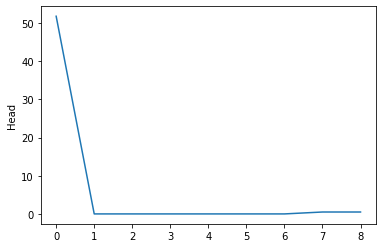

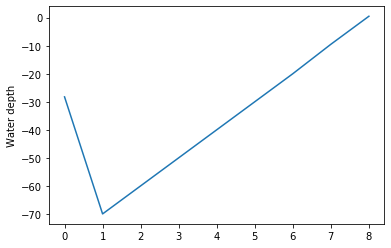

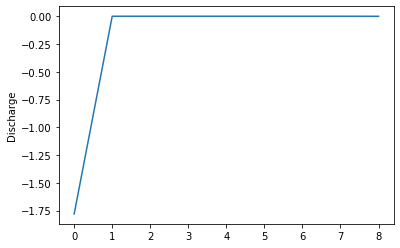

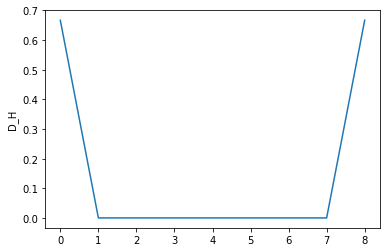

In [58]:
print("Node net fluxes = ",mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx + mg.at_node['input__discharge'][mg.core_nodes])
print("Node head = ",mg.at_node['hydraulic__head'])

figure()
plot(mg.at_node['hydraulic__head'][11:20])
ylabel('Head')

figure()
water_depth = mg.at_node['hydraulic__head'][11:20] - mg.at_node['junction__elevation'][11:20]
water_depth[water_depth>1.] = 1.
plot(water_depth)
ylabel('Water depth')

figure()
plot(Q[mg.active_links])
ylabel('Discharge')

figure()
plot(mg.at_link['hydraulic__diameter'][mg.active_links])
ylabel('D_H')

print('Discharge=',Q[mg.active_links])
print('D_H=',mg.at_link['hydraulic__diameter'][mg.active_links])

In [20]:
mg = RasterModelGrid((5,5),100)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')
mg.add_zeros('node','storage')
mg.at_node['storage']=10.*np.ones(mg.number_of_nodes)

mg.at_node['junction__elevation'] = -0.01*mg.node_x + 4.


w = mg.add_zeros('link','width')
mg.at_link['width']= 0.5*np.ones(mg.number_of_links)#.*np.random.rand(mg.number_of_active_links)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'] = w

mg.at_node['input__discharge'][12]=0.05

#Set up link elevation offsets
xc_min_head = mg.add_zeros('link', 'conduit_head__offset')
xc_min_tail = mg.add_zeros('link', 'conduit_tail__offset')
y_max = mg.add_zeros('link', 'maximum__depth')
mg.at_link['maximum__depth']= w#mg.at_link['hydraulic__diameter']#applicable for square conduits



#set heads at edges
h[mg.nodes_at_left_edge] = 4.2
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.#0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)


pfn = PresFlowNetwork(mg)


Number of links =  40
Number of nodes =  25
Number of active links =  18
Number of core nodes =  9


In [8]:
mg.calc_net_flux_at_node(Q)[mg.core_nodes]/mg.dx - mg.at_node['input__discharge'][mg.core_nodes]

array([  1.50350309e-01,   1.95539803e-09,   8.41032719e-02,
         1.50350310e-01,  -5.00000011e-02,   8.41032727e-02,
         1.50350309e-01,   1.95539803e-09,   8.41032719e-02])

In [21]:
for i in arange(500):
    print('Time iteration:', i)
    pfn.dyn_wave_solution(dt=5.)

Time iteration: 0
max change in h:  0.00624999846719
max change in h:  0.00312499998806
max change in h:  0.00156250035591
max change in h:  0.000781250332019
max change in h:  0.000390625209346
max change in h:  0.000195312607906
max change in h:  0.000675557188024
max change in h:  0.00305957032746
max change in h:  0.0105381863919
max change in h:  0.00725064368962
max change in h:  0.0041586203004
max change in h:  0.00222711783631
max change in h:  0.00115316599532
max change in h:  0.000586228797804
max change in h:  0.000294910608406
max change in h:  0.000147451708341
max change in h:  7.34562679073e-05
average dh= 0.0129024910041   average abs(dQ)= 0.0202490671414
Time iteration: 1
max change in h:  0.0183385479768
max change in h:  0.00936328553833
max change in h:  0.00471649483183
max change in h:  0.00235976505261
max change in h:  0.00117653968185
max change in h:  0.000585544663148
max change in h:  0.000291141915632
max change in h:  0.0001446891683
max change in h:  7.

max change in h:  0.00114275701644
max change in h:  0.000567247749253
max change in h:  0.000281553800715
max change in h:  0.000139744038729
max change in h:  6.93579033637e-05
average dh= 0.0277831768403   average abs(dQ)= 0.000363688020443
Time iteration: 21
max change in h:  0.0184983326994
max change in h:  0.00919559514918
max change in h:  0.00456769356744
max change in h:  0.00226793248017
max change in h:  0.00112579906238
max change in h:  0.000558772058395
max change in h:  0.000277317196227
max change in h:  0.000137626259291
max change in h:  6.82992629502e-05
average dh= 0.0274201741593   average abs(dQ)= 0.000363688026154
Time iteration: 22
max change in h:  0.0182260564411
max change in h:  0.00905961690631
max change in h:  0.00449977504786
max change in h:  0.00223400000523
max change in h:  0.00110884240104
max change in h:  0.000550297149648
max change in h:  0.000273081035665
max change in h:  0.000135508722703
max change in h:  6.72407526761e-05
average dh= 0.027

max change in h:  0.000127836981795
max change in h:  6.55436226999e-05
average dh= 0.019511763073   average abs(dQ)= 0.00402426878871
Time iteration: 44
max change in h:  0.0124744092639
max change in h:  0.00665698927516
max change in h:  0.00353972587685
max change in h:  0.00186753077877
max change in h:  0.000976142608598
max change in h:  0.000505471630082
max change in h:  0.000259508064442
max change in h:  0.000132240058352
max change in h:  6.69678416965e-05
average dh= 0.0192652219069   average abs(dQ)= 0.00339019094257
Time iteration: 45
max change in h:  0.0144787256196
max change in h:  0.0075188680498
max change in h:  0.00389391161919
max change in h:  0.00200652575673
max change in h:  0.00102795445341
max change in h:  0.000523587370316
max change in h:  0.000265282899267
max change in h:  0.000133797638694
max change in h:  6.72280338014e-05
average dh= 0.019083036097   average abs(dQ)= 0.00240031909813
Time iteration: 46
max change in h:  0.0158742108638
max change 

max change in h:  0.000515149223876
max change in h:  0.000256726617614
max change in h:  0.000127949445962
max change in h:  6.37730645798e-05
average dh= 0.0185969337162   average abs(dQ)= 0.000195475751501
Time iteration: 69
max change in h:  0.016626187639
max change in h:  0.00828873513056
max change in h:  0.00413028117283
max change in h:  0.00205762779609
max change in h:  0.00102499126866
max change in h:  0.00051060382037
max change in h:  0.000254379625919
max change in h:  0.000126742954711
max change in h:  6.31549865293e-05
average dh= 0.0185866487918   average abs(dQ)= 0.000219333657171
Time iteration: 70
max change in h:  0.0164961775678
max change in h:  0.00822119816445
max change in h:  0.00409509904709
max change in h:  0.00203930521251
max change in h:  0.00101546926291
max change in h:  0.000505670311484
max change in h:  0.000251831795962
max change in h:  0.000125431182755
max change in h:  6.24813786725e-05
average dh= 0.0185759373666   average abs(dQ)= 0.00024

max change in h:  0.00411741938194
max change in h:  0.00204445119633
max change in h:  0.00101467830705
max change in h:  0.00050356701972
max change in h:  0.000249965160503
max change in h:  0.000124124883591
max change in h:  6.16621061521e-05
average dh= 0.0155927524962   average abs(dQ)= 0.000223921718299
Time iteration: 95
max change in h:  0.0165154468922
max change in h:  0.00821152788463
max change in h:  0.0040771305098
max change in h:  0.00202276759361
max change in h:  0.00100323151094
max change in h:  0.000497581994834
max change in h:  0.000246847558265
max change in h:  0.000122501932358
max change in h:  6.08167441827e-05
average dh= 0.0155048337475   average abs(dQ)= 0.000262361185975
Time iteration: 96
max change in h:  0.0162958651115
max change in h:  0.00809749598732
max change in h:  0.00401880139825
max change in h:  0.00199307009832
max change in h:  0.000988079840472
max change in h:  0.00048980669829
max change in h:  0.000242829529484
max change in h:  0.0

max change in h:  5.18868600974e-07
average dh= 5.22771629656e-09   average abs(dQ)= 1.36113815666e-06
Time iteration: 150
max change in h:  1.81997778848e-07
average dh= 5.41415793367e-09   average abs(dQ)= 1.03010062423e-06
Time iteration: 151
max change in h:  1.98694293685e-07
average dh= 5.18237330597e-09   average abs(dQ)= 6.97915387604e-07
Time iteration: 152
max change in h:  6.21893939901e-07
average dh= 4.65942713162e-09   average abs(dQ)= 3.8792646704e-07
Time iteration: 153
max change in h:  9.12159153321e-07
average dh= 3.95214363686e-09   average abs(dQ)= 3.69857936587e-07
Time iteration: 154
max change in h:  1.07783776282e-06
average dh= 3.14896521972e-09   average abs(dQ)= 4.7823822375e-07
Time iteration: 155
max change in h:  1.13398737822e-06
average dh= 2.32172574287e-09   average abs(dQ)= 5.39726362718e-07
Time iteration: 156
max change in h:  1.09994582864e-06
average dh= 1.52710770345e-09   average abs(dQ)= 5.50583620189e-07
Time iteration: 157
max change in h:  

max change in h:  3.42510464435e-11
average dh= -1.72743980578e-13   average abs(dQ)= 4.61250603292e-11
Time iteration: 236
max change in h:  1.06814557199e-11
average dh= -1.78537966625e-13   average abs(dQ)= 3.43838696408e-11
Time iteration: 237
max change in h:  4.1795455985e-12
average dh= -1.70455707805e-13   average abs(dQ)= 2.27051192141e-11
Time iteration: 238
max change in h:  1.14801501638e-11
average dh= -1.5202444049e-13   average abs(dQ)= 1.2587245473e-11
Time iteration: 239
max change in h:  1.64157576421e-11
average dh= -1.2674897108e-13   average abs(dQ)= 1.34352759826e-11
Time iteration: 240
max change in h:  1.91398008553e-11
average dh= -9.78689419244e-14   average abs(dQ)= 1.72925103749e-11
Time iteration: 241
max change in h:  1.99298355597e-11
average dh= -6.81959195904e-14   average abs(dQ)= 1.91530201258e-11
Time iteration: 242
max change in h:  1.91409110784e-11
average dh= -4.00032167885e-14   average abs(dQ)= 1.92620882051e-11
Time iteration: 243
max change i

max change in h:  8.881784197e-16
average dh= 4.19976553534e-17   average abs(dQ)= 5.53468644854e-16
Time iteration: 331
max change in h:  6.66133814775e-16
average dh= 3.20239591018e-17   average abs(dQ)= 4.96410999691e-16
Time iteration: 332
max change in h:  4.4408920985e-16
average dh= 2.2505145895e-17   average abs(dQ)= 3.88037463369e-16
Time iteration: 333
max change in h:  2.22044604925e-16
average dh= 1.55469772858e-17   average abs(dQ)= 3.21560811832e-16
Time iteration: 334
max change in h:  0.0
average dh= 8.14067177865e-18   average abs(dQ)= 2.24337993687e-16
Time iteration: 335
max change in h:  2.22044604925e-16
average dh= -9.55061647052e-19   average abs(dQ)= 1.45067756515e-16
Time iteration: 336
max change in h:  2.22044604925e-16
average dh= -1.03823200037e-17   average abs(dQ)= 8.98698192446e-17
Time iteration: 337
max change in h:  0.0
average dh= -2.48585874107e-17   average abs(dQ)= 1.19278803173e-16
Time iteration: 338
max change in h:  0.0
average dh= -3.92741394

max change in h:  0.0
average dh= -3.89850189168e-17   average abs(dQ)= 9.42352388252e-18
Time iteration: 421
max change in h:  0.0
average dh= -3.93049790246e-17   average abs(dQ)= 9.39641882821e-18
Time iteration: 422
max change in h:  0.0
average dh= -3.91459627059e-17   average abs(dQ)= 9.39039548281e-18
Time iteration: 423
max change in h:  0.0
average dh= -3.90023661515e-17   average abs(dQ)= 9.3843721374e-18
Time iteration: 424
max change in h:  0.0
average dh= -3.88587695971e-17   average abs(dQ)= 9.37985462835e-18
Time iteration: 425
max change in h:  0.0
average dh= -3.86987895432e-17   average abs(dQ)= 9.3753371193e-18
Time iteration: 426
max change in h:  0.0
average dh= -3.90486254442e-17   average abs(dQ)= 9.3693137739e-18
Time iteration: 427
max change in h:  0.0
average dh= -3.93994250805e-17   average abs(dQ)= 9.36630210119e-18
Time iteration: 428
max change in h:  0.0
average dh= -3.92558285261e-17   average abs(dQ)= 9.31058615622e-18
Time iteration: 429
max change in

In [10]:
#h_new_solver = h.copy()
#Q_new_solver = Q.copy()
#h[mg.core_nodes]
#mg.at_link['hydraulic__diameter']
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])

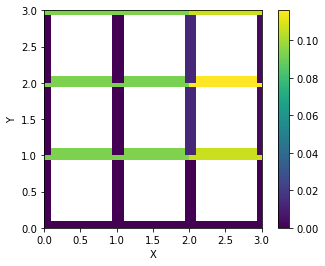

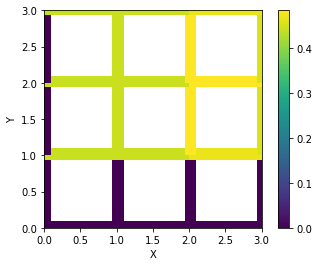

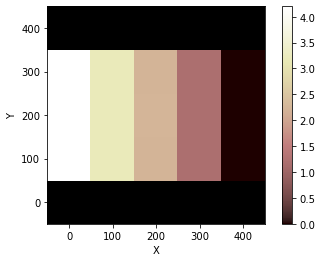

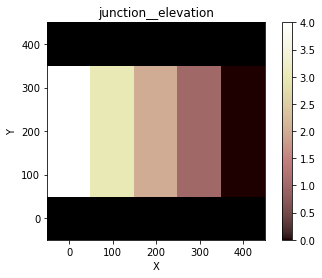

In [15]:
figure()
plot_links(mg, 'conduit__discharge',magnitude=True)
figure()
plot_links(mg, 'hydraulic__diameter')
figure()
imshow_grid_at_node(mg, h)
figure()
imshow_grid_at_node(mg, 'junction__elevation')


In [9]:
FUDGE=0.0001
active_links = mg.active_links
head_nodes = mg.node_at_link_head[active_links]
tail_nodes = mg.node_at_link_tail[active_links]
h_head = mg.at_node['hydraulic__head'][head_nodes]
h_tail = mg.at_node['hydraulic__head'][tail_nodes]
#Calculate flow depths using offset and junction elevations
y_head = h_head - mg.at_node['junction__elevation'][head_nodes] \
         - mg.at_link['conduit_head__offset'][active_links]
y_tail = h_tail - mg.at_node['junction__elevation'][tail_nodes] \
          - mg.at_link['conduit_tail__offset'][active_links]
y_head[y_head>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_head>mg.at_link['maximum__depth'][active_links]]
y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
y_avg = 0.5*(y_head + y_tail)
A_avg = mg.at_link['width'][active_links] * y_avg
y_avg[y_avg<FUDGE] = FUDGE
A_avg[A_avg<FUDGE] = FUDGE

In [10]:
h_head>h_tail

array([False, False, False, False, False, False, False, False, False], dtype=bool)

In [22]:
#y_tail[y_tail>mg.at_link['maximum__depth'][active_links]] = 
#mg.at_link['maximum__depth'][active_links][y_tail>mg.at_link['maximum__depth'][active_links]]
d_h_square(mg.at_link['width'][active_links], y_avg)

array([  3.96936126e-01,   3.53636005e-04,   3.99594057e-04,
         3.99687423e-04,   3.99814040e-04,   3.99715864e-04,
         3.99694894e-04,   4.90132384e-01,   3.99793756e-04,
         3.96927434e-04,   3.99777355e-04,   3.99802869e-04,
         3.99787176e-04,   3.97200621e-04,   2.81319838e-01,
         3.99646193e-04,   3.99446218e-04,   3.99054260e-04])

In [21]:
def d_h_square(width, flow_depth):
    d_H = np.zeros(np.size(width))
    is_full_pipe = np.isclose(width,flow_depth)
    d_H[is_full_pipe] = width[is_full_pipe]
    d_H[~is_full_pipe] = 4.*width[~is_full_pipe]*flow_depth[~is_full_pipe] / (2.*flow_depth[~is_full_pipe] + width[~is_full_pipe])
    return d_H

In [17]:
mg.at_link['hydraulic__diameter'][mg.active_links]

array([ 0.75,  0.75,  0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,
        0.75,  0.5 ,  0.75,  0.75,  0.75,  0.75,  0.75,  0.75,  0.5 ])

In [11]:
pfn.run_one_step()

Number of iterations = 1 tolerance = nan  iteration time= 0.016219377517700195


/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:186: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:267: RuntimeWarning: divide by zero encountered in double_scalars
  ADA_ij[i][j] = -1./(a[this_link]*r[this_link]*np.fabs(self.Q[this_link])**(a[this_link]-1))
/home/mcoving/anaconda3/envs/landlab_dev/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:277: RuntimeWarning: divide by zero encountered in true_divide
  dQ= -(1./a[self.grid.active_links])*self.Q[self.grid.active_links] - 1./(a[self.grid.active_links]*r[self.grid.active_links]*np.fabs(self.Q[self.grid.active_links])**(a[self.grid.active_link

In [5]:
d_h.copy()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [54]:
mg.at_node['junction__elevation']

array([ 4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,
        1.,  0.,  4.,  3.,  2.,  1.,  0.,  4.,  3.,  2.,  1.,  0.])